# PROYECTO TALENTO TECH

# Paquetes y métodos propios

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

from itertools import combinations
import warnings

In [ ]:
%load_ext jupyter_black

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [ ]:
warnings.filterwarnings("ignore")


def cramers_v(x, y):
    """
    Calcula el estadístico V de Cramer para asociación categórica-categórica.
    Los valores van de 0 (sin asociación) a 1 (asociación perfecta).
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


def theils_u(x, y):
    """
    Calcula el estadístico U de Theil (coeficiente de incertidumbre).
    Medida asimétrica - U(x|y) != U(y|x)
    """
    from collections import Counter
    from scipy import stats as ss
    
    s_xy = entropia_condicional(x, y)
    contador_x = Counter(x)
    total_ocurrencias = sum(contador_x.values())
    p_x = list(map(lambda n: n / total_ocurrencias, contador_x.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def entropia_condicional(x, y):
    """Calcula la entropía condicional"""
    from collections import Counter
    from scipy import stats as ss

    contador_y = Counter(y)
    contador_xy = Counter(list(zip(x, y)))
    total_ocurrencias = sum(contador_y.values())
    entropia = 0
    for xy in contador_xy.keys():
        p_xy = contador_xy[xy] / total_ocurrencias
        p_y = contador_y[xy[1]] / total_ocurrencias
        entropia += p_xy * np.log(p_xy / p_y)
    return entropia / -1


def ratio_correlacion(categorias, mediciones):
    """
    Calcula el ratio de correlación (eta) para asociación categórica-numérica.
    categorias: variable categórica
    mediciones: variable numérica
    """
    fcat, _ = pd.factorize(categorias)
    num_cat = np.max(fcat) + 1
    array_promedio_y = np.zeros(num_cat)
    array_n = np.zeros(num_cat)
    for i in range(0, num_cat):
        medidas_cat = mediciones[np.argwhere(fcat == i).flatten()]
        array_n[i] = len(medidas_cat)
        array_promedio_y[i] = np.average(medidas_cat)
    promedio_total_y = np.sum(np.multiply(array_promedio_y, array_n)) / np.sum(array_n)
    numerador = np.sum(
        np.multiply(array_n, np.power(np.subtract(array_promedio_y, promedio_total_y), 2))
    )
    denominador = np.sum(np.power(np.subtract(mediciones, promedio_total_y), 2))
    if denominador == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerador / denominador)
    return eta


def matriz_correlacion_categoricas(df, cols_categoricas, cols_numericas=None):
    """
    Crea una matriz de correlación para variables categóricas usando V de Cramer
    y correlaciones mixtas para pares categórico-numéricos
    """
    if cols_numericas is None:
        cols_numericas = []

    todas_cols = cols_categoricas + cols_numericas
    n_vars = len(todas_cols)
    matriz_corr = np.ones((n_vars, n_vars))

    for i in range(n_vars):
        for j in range(i + 1, n_vars):
            col1, col2 = todas_cols[i], todas_cols[j]

            # Ambas categóricas
            if col1 in cols_categoricas and col2 in cols_categoricas:
                matriz_corr[i, j] = cramers_v(df[col1], df[col2])

            # Una categórica, una numérica
            elif col1 in cols_categoricas and col2 in cols_numericas:
                matriz_corr[i, j] = ratio_correlacion(df[col1], df[col2])
            elif col1 in cols_numericas and col2 in cols_categoricas:
                matriz_corr[i, j] = ratio_correlacion(df[col2], df[col1])

            # Ambas numéricas (correlación de Pearson regular)
            elif col1 in cols_numericas and col2 in cols_numericas:
                matriz_corr[i, j] = df[col1].corr(df[col2])

            # Hacer la matriz simétrica
            matriz_corr[j, i] = matriz_corr[i, j]

    return pd.DataFrame(matriz_corr, index=todas_cols, columns=todas_cols)


def graficar_mapa_calor_correlacion_categoricas(
    matriz_corr, titulo="Matriz de Asociación Categórica", tamano_fig=(7, 7), anotar=True
):
    """Grafica un mapa de calor de correlaciones categóricas"""
    plt.figure(figsize=tamano_fig)
    mascara = np.triu(np.ones_like(matriz_corr, dtype=bool))
    sns.heatmap(
        matriz_corr,
        mask=mascara,
        annot=anotar,
        cmap="RdYlGn",
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        fmt=".3f",
    )
    plt.title(titulo, fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()


def analizar_asociaciones_categoricas(
    df, cols_categoricas, cols_numericas=None, umbral=0.3, tamano_fig=(7, 7), anotar=True
):
    """
    Análisis exhaustivo de asociaciones de variables categóricas
    """
    print("ANÁLISIS DE ASOCIACIÓN DE VARIABLES CATEGÓRICAS")
    print("=" * 60)

    # Crear matriz de correlación
    matriz_corr = matriz_correlacion_categoricas(df, cols_categoricas, cols_numericas)

    # Graficar mapa de calor
    graficar_mapa_calor_correlacion_categoricas(matriz_corr, tamano_fig=tamano_fig, anotar=anotar)

    # Encontrar las asociaciones más fuertes
    print(f"\nASOCIACIONES MÁS FUERTES (> {umbral}):")
    print("-" * 40)

    pares_fuertes = []
    n_vars = len(matriz_corr)

    for i in range(n_vars):
        for j in range(i + 1, n_vars):
            correlacion = matriz_corr.iloc[i, j]
            if abs(correlacion) > umbral:
                var1, var2 = matriz_corr.index[i], matriz_corr.index[j]

                # Determinar tipo de asociación
                if var1 in cols_categoricas and var2 in cols_categoricas:
                    tipo_asoc = "V de Cramer"
                elif (var1 in cols_categoricas) != (var2 in cols_categoricas):
                    tipo_asoc = "Ratio de Correlación (η)"
                else:
                    tipo_asoc = "Pearson"

                pares_fuertes.append(
                    {
                        "Variable 1": var1,
                        "Variable 2": var2,
                        "Asociación": correlacion,
                        "Tipo": tipo_asoc,
                    }
                )

    if pares_fuertes:
        df_fuertes = pd.DataFrame(pares_fuertes)
        df_fuertes = df_fuertes.sort_values("Asociación", key=abs, ascending=False)
        print(df_fuertes.to_string(index=False))
    else:
        print(f"No se encontraron asociaciones por encima del umbral {umbral}")

    return matriz_corr, pares_fuertes


# EJEMPLO DE USO PARA EL DATASET AMES:
"""
# Define tus variables categóricas y numéricas
variables_categoricas = [
    'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
    'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
    'SaleType', 'SaleCondition'
]

# Algunas variables numéricas clave para análisis mixto
variables_numericas = [
    'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
    'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
    'YrSold', 'SalePrice'
]

# Ejecutar el análisis
matriz_correlacion, asociaciones_fuertes = analizar_asociaciones_categoricas(
    ames_kaggle,
    variables_categoricas[:10],  # Empezar con las primeras 10 para evitar salida abrumadora
    variables_numericas[:5],     # Incluir algunas variables numéricas
    umbral=0.3
)

# Para solo asociaciones categórica-categórica:
matriz_solo_cat = matriz_correlacion_categoricas(ames_kaggle, variables_categoricas[:10])
graficar_mapa_calor_correlacion_categoricas(matriz_solo_cat, "Asociación de Variables Categóricas (V de Cramer)")
"""


print("¡Funciones listas! Usa el código de ejemplo al final para analizar tu dataset.")
print("\nMétricas Clave Explicadas:")
print("• V de Cramer: Categórica ↔ Categórica (0 = sin asociación, 1 = perfecta)")
print(
    "• Ratio de Correlación (η): Categórica ↔ Numérica (0 = sin asociación, 1 = perfecta)"
)
print("• Valores > 0.3 típicamente indican asociaciones moderadas a fuertes")

Functions ready! Use the example code at the bottom to analyze your dataset.

Key Metrics Explained:
• Cramer's V: Categorical ↔ Categorical (0 = no association, 1 = perfect)
• Correlation Ratio (η): Categorical ↔ Numerical (0 = no association, 1 = perfect)
• Values > 0.3 typically indicate moderate-to-strong associations


In [ ]:
# Asignar un valor a ciertos rangos de frecuencia acumulada = Pareto + metodología ABC
def asignacion_pareto(variable, dataframe, limites=[70, 90], valores=[3, 2, 1]):
    # Calcular frecuencia y frecuencia acumulada
    frecuencia = dataframe[variable].value_counts()
    frecuencia_acumulada = frecuencia.cumsum() / frecuencia.sum() * 100

    # Crear la frecuencia acumulada previa (shift=una posición, fill_value=0 es la primera frecuencia acumulada)
    frecuencia_acumulada_previa = frecuencia_acumulada.shift(1, fill_value=0)

    # Definir las condiciones basadas en la frecuencia acumulada PREVIA
    condiciones = [
        frecuencia_acumulada_previa < limites[0],  # Si la previa es < 70%, es A
        (frecuencia_acumulada_previa >= limites[0]) & (frecuencia_acumulada_previa < limites[1]),  # Si la previa está entre 70-90%, es B
        frecuencia_acumulada_previa >= limites[1],  # Si la previa es >= 90%, es C
    ]

    # Asignar clasificación
    clasificacion = np.select(condiciones, valores)

    # Aplicar en la variable y retornar
    return dataframe[variable].map(pd.Series(clasificacion, index=frecuencia.index))

In [ ]:
# Método propio para graficar ojivas
def ogiveplot(data, x, bins=10, show_hist=False):
    """
    Grafica una ojiva (polígono de frecuencia acumulada) para una columna numérica en un DataFrame.

    Parámetros:
    -----------
    data : DataFrame
        El DataFrame de pandas que contiene los datos.
    x : str
        El nombre de la columna numérica a graficar.
    bins : int o secuencia
        Número de intervalos o bordes de intervalos específicos.
    color_hist : str
        Color de la línea del histograma acumulativo (estilo paso).
    color_line : str
        Color de la línea de la ojiva.
    show_hist : bool
        Si es True, muestra el histograma acumulativo de estilo paso debajo de la línea.
    """
    valores = data[x].dropna()

    # Opcional: dibujar histograma acumulativo de estilo paso
    if show_hist:
        sns.histplot(
            valores,
            bins=bins,
            stat="count",
            cumulative=True,
            element="step",
            fill=False,
            color="gray",
            alpha=0.5,
        )

    # Calcular conteos y bordes de intervalos
    conteos, bordes_intervalos = np.histogram(valores, bins=bins)
    conteos_acumulados = np.cumsum(conteos)

    # Agregar límite inferior (0 acumulativo) y mantener último límite superior
    limites_x = np.concatenate(([bordes_intervalos[0]], bordes_intervalos[1:]))
    limites_y = np.concatenate(([0], conteos_acumulados))

    # Graficar línea suave de ojiva
    sns.lineplot(x=limites_x, y=limites_y, marker="o")

    # Etiquetas
    plt.title(f"Ojiva (Frecuencia Acumulada) para '{x}'")
    plt.xlabel(x)
    plt.ylabel("Frecuencia Acumulada")

In [ ]:
# Graficar los Pareto por pares de variables
def plot_pareto_heatmap(df, var1, var2, figsize=(10, 10)):
    """
    Crea un mapa de calor mostrando sumas de clasificaciones de Pareto entre dos variables

    Parámetros:
    df: DataFrame que contiene tanto las variables originales como sus clasificaciones de Pareto
    var1: Nombre de la primera variable (sin sufijo _P)
    var2: Nombre de la segunda variable (sin sufijo _P)
    figsize: Tupla para el tamaño de la figura
    """
    # Crear tabla pivote con categorías originales pero suma de valores de Pareto
    tabla_pivote_suma = pd.crosstab(
        df[var1],  # Categorías originales como índice
        df[var2],  # Categorías originales como columnas
        values=df[f"{var1}_P"] + df[f"{var2}_P"],  # Suma de valores de Pareto
        aggfunc="mean", # Usando media ya que estamos sumando los valores
    )

    # Graficar mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(
        tabla_pivote_suma,
        annot=True,
        # fmt='.2f',
        cmap="crest",
    )
    plt.title(f"Clasificación de Pareto: {var1} vs {var2}")
    plt.tight_layout()
    plt.show()

# Diagramas de Pareto y metodología ABC

## Carga de conjunto y selección de variables

In [ ]:
intra_df = pd.read_csv(
    "/Users/carolinatorreslozano/Documents/VirtualEnvironmentsVSCode/my_env/bootcampia/intrafamiliar_limpiofinal.csv"
)

In [ ]:
intra_df.head()

Año del hecho Sexo de la victima Grupo de Edad judicial País de Nacimiento  \
0           2015             Hombre              (10 a 13)           Colombia   
1           2015             Hombre              (00 a 04)           Colombia   
2           2015             Hombre              (00 a 04)           Colombia   
3           2015             Hombre              (00 a 04)           Colombia   
4           2015             Hombre              (25 a 28)           Colombia   

       Escolaridad Estado Civil Tipo de Discapacidad      Pertenencia Étnica  \
0         Primaria  Soltero (a)              Ninguna         Sin información   
1  Sin escolaridad    No aplica              Ninguna  Sin pertenencia étnica   
2  Sin escolaridad    No aplica              Ninguna  Sin pertenencia étnica   
3  Sin escolaridad    No aplica              Ninguna  Sin pertenencia étnica   
4  Sin información  Unión libre              Ninguna         Sin información   

  Identidad de Género Pertenencia Grupal Mes del hecho Dia del hecho  \
0     Sin Información    Sin información     Diciembre        Martes   
1           No Aplica    Sin información         Marzo     Miércoles   
2           No Aplica    Sin información         Junio        Jueves   
3           No Aplica    Sin información         Enero        Sábado   
4     Sin Información    Sin información          Mayo        Martes   

  Rango de Hora del Hecho X 3 Horas  Código Dane Municipio  \
0                   (18:00 a 20:59)                  11001   
1                   (18:00 a 20:59)                  25754   
2                   Sin información                  25754   
3                   (06:00 a 08:59)                  54001   
4                   (09:00 a 11:59)                  11001   

  Municipio del hecho DANE Departamento del hecho DANE      Zona del Hecho  \
0             Bogotá, D.C.                Bogotá, D.C.  Cabecera municipal   
1                   Soacha                Cundinamarca  Cabecera municipal   
2                   Soacha                Cundinamarca  Cabecera municipal   
3                   Cúcuta          Norte de Santander  Cabecera municipal   
4             Bogotá, D.C.                Bogotá, D.C.  Cabecera municipal   

  Escenario del Hecho   Actividad Durante el Hecho  \
0         Vía Pública  Desplazamiento / Transporte   
1            Vivienda    Tiempo Libre / Recreación   
2     Sin Información  Desplazamiento / Transporte   
3            Vivienda  Desplazamiento / Transporte   
4         Vía Pública  Desplazamiento / Transporte   

  Mecanismo Causal de la Lesión no Fatal Sexo del Agresor  \
0                               Abrasivo           Hombre   
1                            Contundente            Mujer   
2                         Por determinar            Mujer   
3                            Contundente            Mujer   
4                            Contundente           Hombre   

                 Presunto Agresor Detallado  \
0                                     Padre   
1                                     Madre   
2  Otros familiares civiles o consanguíneos   
3                                Abuelo (a)   
4                               Hermano (a)   

  Factor Desencadenante de la Agresión  
0              Intolerancia / Machismo  
1              Intolerancia / Machismo  
2              Intolerancia / Machismo  
3              Intolerancia / Machismo  
4              Intolerancia / Machismo

In [ ]:
intra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   Año del hecho                           236840 non-null  int64 
 1   Sexo de la victima                      236840 non-null  object
 2   Grupo de Edad judicial                  236840 non-null  object
 3   País de Nacimiento                      236840 non-null  object
 4   Escolaridad                             236840 non-null  object
 5   Estado Civil                            236840 non-null  object
 6   Tipo de Discapacidad                    236840 non-null  object
 7   Pertenencia Étnica                      236840 non-null  object
 8   Identidad de Género                     236840 non-null  object
 9   Pertenencia Grupal                      236840 non-null  object
 10  Mes del hecho                           236840 non-null 

In [ ]:
intrafa = intra_df.copy()

In [ ]:
intrafa.columns

Index(['Año del hecho', 'Sexo de la victima', 'Grupo de Edad judicial',
       'País de Nacimiento', 'Escolaridad', 'Estado Civil',
       'Tipo de Discapacidad', 'Pertenencia Étnica', 'Identidad de Género',
       'Pertenencia Grupal', 'Mes del hecho', 'Dia del hecho',
       'Rango de Hora del Hecho X 3 Horas', 'Código Dane Municipio',
       'Municipio del hecho DANE', 'Departamento del hecho DANE',
       'Zona del Hecho', 'Escenario del Hecho', 'Actividad Durante el Hecho',
       'Mecanismo Causal de la Lesión no Fatal', 'Sexo del Agresor',
       'Presunto Agresor Detallado', 'Factor Desencadenante de la Agresión'],
      dtype='object')

In [ ]:
# Columnas seleccionadas
seleccionadas_13 = [
    "Año del hecho",
    "Sexo de la victima",
    "Grupo de Edad judicial",
    "País de Nacimiento",
    "Escolaridad",
    "Identidad de Género",
    "Pertenencia Grupal",
    "Departamento del hecho DANE",
    "Escenario del Hecho",
    "Actividad Durante el Hecho",
    "Sexo del Agresor",
    "Presunto Agresor Detallado",
    "Factor Desencadenante de la Agresión",
]

In [ ]:
intrafamiliar = intrafa[seleccionadas_13]
intrafamiliar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   Año del hecho                         236840 non-null  int64 
 1   Sexo de la victima                    236840 non-null  object
 2   Grupo de Edad judicial                236840 non-null  object
 3   País de Nacimiento                    236840 non-null  object
 4   Escolaridad                           236840 non-null  object
 5   Identidad de Género                   236840 non-null  object
 6   Pertenencia Grupal                    236840 non-null  object
 7   Departamento del hecho DANE           236840 non-null  object
 8   Escenario del Hecho                   236840 non-null  object
 9   Actividad Durante el Hecho            236840 non-null  object
 10  Sexo del Agresor                      236840 non-null  object
 11  Presunto Agre

## Pareto

In [ ]:
intrafamiliar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   Año del hecho                         236840 non-null  int64 
 1   Sexo de la victima                    236840 non-null  object
 2   Grupo de Edad judicial                236840 non-null  object
 3   País de Nacimiento                    236840 non-null  object
 4   Escolaridad                           236840 non-null  object
 5   Identidad de Género                   236840 non-null  object
 6   Pertenencia Grupal                    236840 non-null  object
 7   Departamento del hecho DANE           236840 non-null  object
 8   Escenario del Hecho                   236840 non-null  object
 9   Actividad Durante el Hecho            236840 non-null  object
 10  Sexo del Agresor                      236840 non-null  object
 11  Presunto Agre

### Año del hecho: descriptivo

In [ ]:
# Aplicar Pareto a Año del hecho
#intrafamiliar["Año del hecho_P"] = asignacion_pareto(
#    variable="Año del hecho", dataframe=intrafamiliar
#)

<span style="color:green">**Preguntas:**</span> ¿A esta le vamos a aplicar Pareto? ¿No vamos a utilzar todos los años?

### Sexo de la víctima: descriptiva

In [ ]:
# Aplicar Pareto a Sexo de la victima
#intrafamiliar["Sexo de la victima_P"] = asignacion_pareto(
#    variable="Sexo de la victima", dataframe=intrafamiliar
#)

<span style="color:green">**Preguntas:**</span> Como son solo dos, ¿usamos Pareto?

### Grupo de Edad judicial: modelo

In [ ]:
intrafamiliar["Grupo de Edad judicial"].value_counts(normalize=True).cumsum().sort_index()

Grupo de Edad judicial
(00 a 04)          0.769038
(05 a 09)          0.384369
(10 a 13)          0.205924
(14 a 17)          0.112498
(18 a 19)          0.908706
(20 a 24)          0.296424
(25 a 28)          0.538271
(29 a 34)          0.470782
(35 a 39)          0.601351
(40 a 44)          0.658377
(45 a 49)          0.823324
(50 a 54)          0.713841
(55 a 59)          0.872728
(60 a 64)          0.940006
(65 a 69)          0.963372
(70 a 74)          0.979286
(75 a 79)          0.999979
(80 y más)         0.989706
Sin información    1.000000
Name: proportion, dtype: float64

In [ ]:
edad_judicial = pd.DataFrame(intrafamiliar["Grupo de Edad judicial"].value_counts()).reset_index().sort_values(by='Grupo de Edad judicial')

In [ ]:
edad_judicial

Grupo de Edad judicial  count  acumulada  acumulada porcentaje
9               (00 a 04)  13073      13073              0.055198
3               (05 a 09)  20829      33902              0.143143
1               (10 a 13)  22127      56029              0.236569
0               (14 a 17)  26644      82673              0.349067
12              (18 a 19)   8521      91194              0.385045
2               (20 a 24)  21434     112628              0.475545
5               (25 a 28)  15984     128612              0.543033
4               (29 a 34)  20466     149078              0.629446
6               (35 a 39)  14940     164018              0.692527
7               (40 a 44)  13506     177524              0.749552
10              (45 a 49)  12857     190381              0.803838
8               (50 a 54)  13136     203517              0.859302
11              (55 a 59)  11701     215218              0.908706
13              (60 a 64)   7413     222631              0.940006
14              (65 a 69)   5534     228165              0.963372
15              (70 a 74)   3769     231934              0.979286
17              (75 a 79)   2433     234367              0.989558
16             (80 y más)   2468     236835              0.999979
18        Sin información      5     236840              1.000000

In [ ]:
edad_judicial['acumulada'] = edad_judicial['count'].cumsum()

In [ ]:
82673	/ 236840

0.3490668805944942

In [ ]:
edad_judicial['acumulada porcentaje'] = edad_judicial['acumulada'] / 236840

In [ ]:
edad_judicial = edad_judicial.drop(columns='acumulada_pct')

In [ ]:
edad_judicial.to_csv('edad_judicial.csv')

In [ ]:
intrafamiliar["Grupo de Edad judicial"].value_counts().sort_index()

Grupo de Edad judicial
(00 a 04)          13073
(05 a 09)          20829
(10 a 13)          22127
(14 a 17)          26644
(18 a 19)           8521
(20 a 24)          21434
(25 a 28)          15984
(29 a 34)          20466
(35 a 39)          14940
(40 a 44)          13506
(45 a 49)          12857
(50 a 54)          13136
(55 a 59)          11701
(60 a 64)           7413
(65 a 69)           5534
(70 a 74)           3769
(75 a 79)           2433
(80 y más)          2468
Sin información        5
Name: count, dtype: int64

In [ ]:
# Aplicar Pareto a Identidad de Género
intrafamiliar["Grupo de Edad judicial_P"] = asignacion_pareto(
    variable="Grupo de Edad judicial", dataframe=intrafamiliar
)

### País de Nacimiento: descartado

In [ ]:
intrafamiliar["País de Nacimiento"].value_counts(normalize=True)

País de Nacimiento
Colombia                0.983132
Venezuela               0.013287
Sin información         0.002280
Ecuador                 0.000304
Estados Unidos          0.000245
España                  0.000194
Perú                    0.000080
Panamá                  0.000046
México                  0.000042
Argentina               0.000034
Chile                   0.000034
Brasil                  0.000034
Canadá                  0.000025
Bolivia                 0.000025
Costa Rica              0.000025
Italia                  0.000021
China                   0.000017
República Dominicana    0.000017
Francia                 0.000017
Cuba                    0.000017
Suiza                   0.000013
Países Bajos            0.000008
Japón                   0.000008
Honduras                0.000008
Reino Unido             0.000008
Guatemala               0.000008
Australia               0.000004
Tailandia               0.000004
Polonia                 0.000004
Uruguay                 

In [ ]:
# Aplicar Pareto a Identidad de Género
#intrafamiliar["País de Nacimiento_P"] = asignacion_pareto(
#    variable="País de Nacimiento", dataframe=intrafamiliar
#)

In [ ]:
#intrafamiliar["País de Nacimiento_P"].value_counts()

<span style="color:green">**Preguntas:**</span> El 98 % es de Colombia. ¿Vale la pena? ¿Serían Pareto A y B o A y C?

### Escolaridad: modelo

In [ ]:
# Aplicar Pareto a Escolaridad
intrafamiliar["Escolaridad_P"] = asignacion_pareto(
    variable="Escolaridad", dataframe=intrafamiliar
)

In [ ]:
# Revisar que Pareto haya quedado bien
intrafamiliar[["Escolaridad", "Escolaridad_P"]].value_counts()

Escolaridad            Escolaridad_P
Primaria               3                74761
Secundaria             3                72544
Preescolar             3                45054
Técnica o Tecnológica  2                22224
Sin escolaridad        1                15681
Sin información        1                 5670
Profesional            1                  629
Posgrado               1                  277
Name: count, dtype: int64

### Identidad de Género: descartado

In [ ]:
intrafamiliar["Identidad de Género"].value_counts(normalize=True)

Identidad de Género
Sin Información    0.703694
Femenino           0.124375
No Aplica          0.086873
Masculino          0.083635
Población Trans    0.001423
Name: proportion, dtype: float64

In [ ]:
# Aplicar Pareto a Identidad de Género
#intrafamiliar["Identidad de Género_P"] = asignacion_pareto(
#    variable="Identidad de Género", dataframe=intrafamiliar
#)

<span style="color:green">**Preguntas:**</span> Como el 70 % no sabe o no informa, ¿vale la pena esta columna? ¿Y si la llenamos con la de sexo y así podríamos quitar una? ¿Le aplicamos Pareto? ¿Con qué valores?

### Pertenencia Grupal: descartado

In [ ]:
intrafamiliar["Pertenencia Grupal"].value_counts(normalize=True)

Pertenencia Grupal
Ninguno                                                            0.766952
Sin información                                                    0.130974
Persona adicta a una droga natural o sintética                     0.025186
Consumidores de sustancias psicoactivas (drogas, alcohol, etc.)    0.021660
Étnico                                                             0.011962
Mujer cabeza de hogar o de familia                                 0.009365
Campesinos (as) y/o trabajadores (as) del campo                    0.008689
Custodia                                                           0.005366
OSIGD                                                              0.004547
ICBF                                                               0.004425
Niños, niñas, adolescentes abandonados                             0.002918
Persona en condición de desplazamiento                             0.002445
Pertenencia múltiple                                               0.

In [ ]:
intrafamiliar["Pertenencia Grupal"].value_counts(normalize=True).cumsum().sort_index()

Pertenencia Grupal
Adolescentes en conflicto con la ley                               0.999878
Cabezas Rapadas                                                    0.999987
Campesinos (as) y/o trabajadores (as) del campo                    0.974789
Comunidad LGBTI                                                    0.998366
Conductores de vehículos de servicio público                       0.999814
Consumidores de sustancias psicoactivas (drogas, alcohol, etc.)    0.944773
Custodia                                                           0.980155
Defensores de derechos humanos                                     0.999992
Desmovilizados o reinsertados                                      0.999434
Desplazados (as)                                                   0.999962
Ejercicio del trabajo sexual                                       0.999928
Funcionarios judiciales                                            0.999945
Geriátrico                                                         0.

In [ ]:
pertenencia_grupal = pd.DataFrame(intrafamiliar["Pertenencia Grupal"].value_counts()).reset_index().sort_values(by='Pertenencia Grupal')

In [ ]:
pertenencia_grupal = pertenencia_grupal.sort_values(by='count', ascending=False)

In [ ]:
pertenencia_grupal

Pertenencia Grupal   count  acumulada  \
0                                             Ninguno  181645     181645   
1                                     Sin información   31020     212665   
2      Persona adicta a una droga natural o sintética    5965     218630   
3   Consumidores de sustancias psicoactivas (droga...    5130     223760   
4                                              Étnico    2833     226593   
5                  Mujer cabeza de hogar o de familia    2218     228811   
6     Campesinos (as) y/o trabajadores (as) del campo    2058     230869   
7                                            Custodia    1271     232140   
8                                               OSIGD    1077     233217   
9                                                ICBF    1048     234265   
10             Niños, niñas, adolescentes abandonados     691     234956   
11             Persona en condición de desplazamiento     579     235535   
12                               Pertenencia múltiple     289     235824   
13                                               Otro     157     235981   
14                 Persona con capacidades diferentes     149     236130   
15                     Persona privada de la libertad     124     236254   
16                Personas con capacidades diferentes     118     236372   
17                                    Comunidad LGBTI      81     236453   
18                                 Maestro o Educador      74     236527   
19                                         Geriátrico      61     236588   
20                                   Servidor público      41     236629   
21  Herido y/o enfermo bajo protección sanitaria o...      27     236656   
22                                       Tribu urbana      25     236681   
23                      Desmovilizados o reinsertados      25     236706   
24          Rehabilitación y pabellones psiquiátricos      20     236726   
25                                          Religioso      18     236744   
26                      Persona en situación de calle      14     236758   
27                                         Periodismo      12     236770   
28                     Persona habitante de  la calle      10     236780   
31               Persona en situación de prostitución       8     236788   
30       Conductores de vehículos de servicio público       8     236796   
29                              Habitante de la calle       8     236804   
33                                       Prostitución       7     236811   
32               Adolescentes en conflicto con la ley       7     236818   
34                       Ejercicio del trabajo sexual       5     236823   
36                                   Desplazados (as)       4     236827   
35                            Funcionarios judiciales       4     236831   
38                                    Cabezas Rapadas       3     236834   
37                      Persona habitante de la calle       3     236837   
39                     Defensores de derechos humanos       1     236838   
40                                              Líder       1     236839   
41  Persona que ejerce actividades gremiales o sin...       1     236840   

    acumulada porcentaje  
0               0.766952  
1               0.897927  
2               0.923113  
3               0.944773  
4               0.956735  
5               0.966099  
6               0.974789  
7               0.980155  
8               0.984703  
9               0.989128  
10              0.992045  
11              0.994490  
12              0.995710  
13              0.996373  
14              0.997002  
15              0.997526  
16              0.998024  
17              0.998366  
18              0.998678  
19              0.998936  
20              0.999109  
21              0.999223  
22              0.999329  
23              0.999434  
24              0.999519  
25              0.999595  
26              0.999654  
27        

In [ ]:
pertenencia_grupal['acumulada'] = pertenencia_grupal['count'].cumsum()

In [ ]:
pertenencia_grupal['acumulada porcentaje'] = pertenencia_grupal['acumulada'] / 236840

In [ ]:
pertenencia_grupal = pertenencia_grupal.drop(columns='acumulada_pct')

In [ ]:
pertenencia_grupal.to_csv('pertenencia_grupal.csv')

In [ ]:
# Aplicar Pareto a Pertenencia Grupal
#intrafamiliar["Pertenencia Grupal_P"] = asignacion_pareto(
#    variable="Pertenencia Grupal", dataframe=intrafamiliar
#)

<span style="color:green">**Preguntas:**</span> El 90 % cubre Ninguno o Sin información. ¿Vale la pena?

### Departamento del hecho DANE: modelo

In [ ]:
intrafamiliar["Departamento del hecho DANE"].value_counts(normalize=True)

Departamento del hecho DANE
Bogotá, D.C.                                                0.259365
Antioquia                                                   0.131257
Cundinamarca                                                0.081646
Valle del Cauca                                             0.062211
Santander                                                   0.049422
Atlántico                                                   0.045123
Tolima                                                      0.034800
Boyacá                                                      0.034196
Meta                                                        0.031773
Norte de Santander                                          0.027643
Huila                                                       0.025616
Bolívar                                                     0.023754
Magdalena                                                   0.021791
Cauca                                                       0.019135
Nariño

In [ ]:
# Aplicar Pareto a Departamento del hecho DANE
intrafamiliar["Departamento del hecho DANE_P"] = asignacion_pareto(
    variable="Departamento del hecho DANE", dataframe=intrafamiliar
)

<span style="color:green">**Preguntas:**</span> ¿A esta también se le aplica Pareto?

### Escenario del Hecho: pendiente

In [ ]:
intrafamiliar["Escenario del Hecho"].value_counts(normalize=True)

Escenario del Hecho
Vivienda                                                                                           0.756722
Vía Pública                                                                                        0.166572
Sin Información                                                                                    0.015817
Lugares Recreativos                                                                                0.013359
Lugares De Hospedaje (Hoteles,Campamentos Y Otros Tipos De Hospedaje No Permanente,Moteles,Etc)    0.012739
Establecimiento Comercial (Tienda,Centro Comercial,Almacén,Plaza De Mercado)                       0.011700
Centros Educativos                                                                                 0.005172
Espacios Abiertos                                                                                  0.004784
Otros                                                                                              0.003103
Centro D

In [ ]:
# Aplicar Pareto a Escenario del Hecho
intrafamiliar["Escenario del Hecho_P"] = asignacion_pareto(
    variable="Escenario del Hecho", dataframe=intrafamiliar
)

In [ ]:
# Revisar que Pareto haya quedado bien
intrafamiliar[["Escenario del Hecho", "Escenario del Hecho_P"]].value_counts()

Escenario del Hecho                                                                              Escenario del Hecho_P
Vivienda                                                                                         3                        179222
Vía Pública                                                                                      2                         39451
Sin Información                                                                                  1                          3746
Lugares Recreativos                                                                              1                          3164
Lugares De Hospedaje (Hoteles,Campamentos Y Otros Tipos De Hospedaje No Permanente,Moteles,Etc)  1                          3017
Establecimiento Comercial (Tienda,Centro Comercial,Almacén,Plaza De Mercado)                     1                          2771
Centros Educativos                                                                               1         

### Actividad Durante el Hecho: modelo

In [ ]:
intrafamiliar["Actividad Durante el Hecho"].value_counts(normalize=True)

Actividad Durante el Hecho
Actividades Vitales / Cuidado Personal          0.317248
Desplazamiento / Transporte                     0.255126
Trabajo Doméstico No Remunerado                 0.225832
Otra / Sin Información                          0.086552
Tiempo Libre / Recreación                       0.037173
Violencia / Conflicto / Actividades Ilícitas    0.031198
Cuidado De Personas                             0.026921
Estudio Y Aprendizaje                           0.012954
Trabajo Remunerado                              0.006979
Situaciones Legales O Forzadas                  0.000017
Name: proportion, dtype: float64

In [ ]:
# Aplicar Pareto a Actividad Durante el Hecho
intrafamiliar["Actividad Durante el Hecho_P"] = asignacion_pareto(
    variable="Actividad Durante el Hecho", dataframe=intrafamiliar
)

### Sexo del Agresor: descriptivo (con todas las categorías) y modelo (H, M, Otros)

In [ ]:
intrafamiliar["Sexo del Agresor"].value_counts(normalize=True)

Sexo del Agresor
Hombre             0.680489
Mujer              0.308888
Sin información    0.010518
Intersexual        0.000080
Transgénero        0.000017
No Binario         0.000008
Name: proportion, dtype: float64

In [ ]:
# Aplicar Pareto a Sexo del Agresor
intrafamiliar["Sexo del Agresor_P"] = asignacion_pareto(
    variable="Sexo del Agresor", dataframe=intrafamiliar
)

### Presunto Agresor Detallado: modelo

In [ ]:
intrafamiliar["Presunto Agresor Detallado"].value_counts(normalize=True)

Presunto Agresor Detallado
Hermano (a)                                 0.178192
Padre                                       0.145280
Madre                                       0.117991
Hijo (a)                                    0.111890
Cuñado (a)                                  0.084943
Otros familiares civiles o consanguíneos    0.077027
Tío (a)                                     0.050802
Padrastro                                   0.048138
Primo (a)                                   0.042961
Sobrino (a)                                 0.040622
Yerno                                       0.021821
Suegro (a)                                  0.016788
Encargado del cuidado                       0.014503
Abuelo (a)                                  0.011303
Nieto (a)                                   0.009720
Nuera                                       0.009462
Madrastra                                   0.009150
Sin información                             0.008613
Profesor (a)       

In [ ]:
# Aplicar Pareto a Presunto Agresor Detallado
intrafamiliar["Presunto Agresor Detallado_P"] = asignacion_pareto(
    variable="Presunto Agresor Detallado", dataframe=intrafamiliar
)

### Factor Desencadenante de la Agresión: descriptiva (todas) y modelo (I, C, Otros)

In [ ]:
intrafamiliar["Factor Desencadenante de la Agresión"].value_counts(normalize=True)

Factor Desencadenante de la Agresión
Intolerancia / Machismo                           0.708411
Consumo de alcohol y/o sustancias psicoactivas    0.157511
Sin información                                   0.071276
Celos, desconfianza, infidelidad                  0.032587
Otras                                             0.015344
Económicas                                        0.009196
Abandono                                          0.003061
Enfermedad física o mental                        0.002609
Desamor                                           0.000004
Name: proportion, dtype: float64

In [ ]:
# Aplicar Pareto a Factor Desencadenante de la Agresión
intrafamiliar["Factor Desencadenante de la Agresión_P"] = asignacion_pareto(
    variable="Factor Desencadenante de la Agresión", dataframe=intrafamiliar
)

## Total Pareto y Nivel de riesgo

In [ ]:
intrafamiliar.head()

Año del hecho Sexo de la victima Grupo de Edad judicial País de Nacimiento  \
0           2015             Hombre              (10 a 13)           Colombia   
1           2015             Hombre              (00 a 04)           Colombia   
2           2015             Hombre              (00 a 04)           Colombia   
3           2015             Hombre              (00 a 04)           Colombia   
4           2015             Hombre              (25 a 28)           Colombia   

       Escolaridad Identidad de Género Pertenencia Grupal  \
0         Primaria     Sin Información    Sin información   
1  Sin escolaridad           No Aplica    Sin información   
2  Sin escolaridad           No Aplica    Sin información   
3  Sin escolaridad           No Aplica    Sin información   
4  Sin información     Sin Información    Sin información   

  Departamento del hecho DANE Escenario del Hecho  \
0                Bogotá, D.C.         Vía Pública   
1                Cundinamarca            Vivienda   
2                Cundinamarca     Sin Información   
3          Norte de Santander            Vivienda   
4                Bogotá, D.C.         Vía Pública   

    Actividad Durante el Hecho Sexo del Agresor  \
0  Desplazamiento / Transporte           Hombre   
1    Tiempo Libre / Recreación            Mujer   
2  Desplazamiento / Transporte            Mujer   
3  Desplazamiento / Transporte            Mujer   
4  Desplazamiento / Transporte           Hombre   

                 Presunto Agresor Detallado  \
0                                     Padre   
1                                     Madre   
2  Otros familiares civiles o consanguíneos   
3                                Abuelo (a)   
4                               Hermano (a)   

  Factor Desencadenante de la Agresión  Grupo de Edad judicial_P  \
0              Intolerancia / Machismo                         3   
1              Intolerancia / Machismo                         2   
2              Intolerancia / Machismo                         2   
3              Intolerancia / Machismo                         2   
4              Intolerancia / Machismo                         3   

   Escolaridad_P  Departamento del hecho DANE_P  Escenario del Hecho_P  \
0              3                              3                      2   
1              1                              3                      3   
2              1                              3                      1   
3              1                              2                      3   
4              1                              3                      2   

   Actividad Durante el Hecho_P  Sexo del Agresor_P  \
0                             3                   3   
1                             2                   3   
2                             3                   3   
3                             3                   3   
4                             3                   3   

   Presunto Agresor Detallado_P  Factor Desencadenante de la Agresión_P  
0                             3                                       3  
1                             3                                       3  
2                             3                                       3  
3                             1                                       3  
4                             3                                       3

In [ ]:
intrafamiliar['Total Pareto'] = intrafamiliar[intrafamiliar_pareto.columns].sum(axis=1)

In [ ]:
intrafamiliar['Total Pareto'].head()

0    23
1    20
2    19
3    18
4    21
Name: Total Pareto, dtype: int64

In [ ]:
intrafamiliar.sample(10)

Año del hecho Sexo de la victima Grupo de Edad judicial  \
177827           2022             Hombre              (18 a 19)   
135229           2019              Mujer              (25 a 28)   
201526           2023             Hombre              (45 a 49)   
63347            2017              Mujer              (25 a 28)   
116476           2019             Hombre              (29 a 34)   
89733            2018             Hombre              (20 a 24)   
44267            2016              Mujer              (60 a 64)   
228179           2024              Mujer              (35 a 39)   
22369            2015             Hombre              (29 a 34)   
76290            2017             Hombre              (50 a 54)   

       País de Nacimiento            Escolaridad Identidad de Género  \
177827           Colombia             Secundaria     Sin Información   
135229           Colombia               Primaria     Sin Información   
201526           Colombia             Secundaria           Masculino   
63347            Colombia             Secundaria     Sin Información   
116476           Colombia  Técnica o Tecnológica     Sin Información   
89733            Colombia               Primaria     Población Trans   
44267            Colombia             Secundaria     Sin Información   
228179           Colombia             Secundaria            Femenino   
22369            Colombia               Primaria     Sin Información   
76290            Colombia  Técnica o Tecnológica     Sin Información   

                                       Pertenencia Grupal  \
177827                                            Ninguno   
135229                                            Ninguno   
201526                                    Sin información   
63347                                             Ninguno   
116476                                            Ninguno   
89733                                     Comunidad LGBTI   
44267                                             Ninguno   
228179                                             Étnico   
22369                                     Sin información   
76290   Consumidores de sustancias psicoactivas (droga...   

       Departamento del hecho DANE Escenario del Hecho  \
177827                Bogotá, D.C.            Vivienda   
135229                       Huila            Vivienda   
201526                   Antioquia            Vivienda   
63347                      Bolívar            Vivienda   
116476                   Atlántico            Vivienda   
89733                        Huila            Vivienda   
44267                    Antioquia            Vivienda   
228179                     Bolívar         Vía Pública   
22369                    Antioquia            Vivienda   
76290                 Bogotá, D.C.            Vivienda   

                    Actividad Durante el Hecho Sexo del Agresor  \
177827             Desplazamiento / Transporte           Hombre   
135229             Desplazamiento / Transporte           Hombre   
201526             Desplazamiento / Transporte           Hombre   
63347              Desplazamiento / Transporte           Hombre   
116476  Actividades Vitales / Cuidado Personal           Hombre   
89733   Actividades Vitales / Cuidado Personal            Mujer   
44267          Trabajo Doméstico No Remunerado           Hombre   
228179             Desplazamiento / Transporte           Hombre   
22369                Tiempo Libre / Recreación           Hombre   
76290   Actividades Vitales / Cuidado Personal            Mujer   

                      Presunto Agresor Detallado  \
177827                               Hermano (a)   
135229                                   Tío (a)   
201526                                   Tío (a)   
63347                                  Primo (a)   
116476                                     Padre   
89733                                    Tío (a)   
44267                                   Hijo (a)   
228179      

In [ ]:
intrafamiliar['Total Pareto'].value_counts().sort_index(ascending=False)

Total Pareto
24    38410
23    50334
22    52168
21    40175
20    26026
19    15260
18     7470
17     3271
16     1452
15      607
14      962
13      428
12      229
11       37
10       11
Name: count, dtype: int64

In [ ]:
intrafamiliar['Total Pareto'].value_counts(normalize=True).sort_index(ascending=False)

Total Pareto
24    0.162177
23    0.212523
22    0.220267
21    0.169629
20    0.109889
19    0.064432
18    0.031540
17    0.013811
16    0.006131
15    0.002563
14    0.004062
13    0.001807
12    0.000967
11    0.000156
10    0.000046
Name: proportion, dtype: float64

In [ ]:
intrafamiliar['Total Pareto'].value_counts(normalize=True).sort_index(ascending=False).cumsum()

Total Pareto
24    0.162177
23    0.374700
22    0.594967
21    0.764596
20    0.874485
19    0.938917
18    0.970457
17    0.984268
16    0.990399
15    0.992961
14    0.997023
13    0.998830
12    0.999797
11    0.999954
10    1.000000
Name: proportion, dtype: float64

In [ ]:
intrafamiliar['Porcentaje de riesgo'] = (intrafamiliar['Total Pareto'] - 10) / (24 - 10)

In [ ]:
intrafamiliar['Porcentaje de riesgo'].value_counts(normalize=True)

Porcentaje de riesgo
0.857143    0.220267
0.928571    0.212523
0.785714    0.169629
1.000000    0.162177
0.714286    0.109889
0.642857    0.064432
0.571429    0.031540
0.500000    0.013811
0.428571    0.006131
0.285714    0.004062
0.357143    0.002563
0.214286    0.001807
0.142857    0.000967
0.071429    0.000156
0.000000    0.000046
Name: proportion, dtype: float64

In [ ]:
intrafamiliar = intrafamiliar.drop(columns='Nivel de riesgo')

In [ ]:
intrafamiliar.sample(10)

Año del hecho Sexo de la victima Grupo de Edad judicial  \
102062           2018              Mujer              (50 a 54)   
23731            2015              Mujer              (14 a 17)   
92045            2018             Hombre              (60 a 64)   
127147           2019              Mujer              (50 a 54)   
68508            2017              Mujer              (60 a 64)   
207419           2023              Mujer              (55 a 59)   
8710             2015             Hombre              (00 a 04)   
19130            2015             Hombre              (14 a 17)   
104037           2018              Mujer              (05 a 09)   
37385            2016              Mujer              (20 a 24)   

       País de Nacimiento            Escolaridad Identidad de Género  \
102062           Colombia             Secundaria     Sin Información   
23731            Colombia               Primaria     Sin Información   
92045            Colombia               Primaria     Sin Información   
127147           Colombia               Primaria     Sin Información   
68508            Colombia  Técnica o Tecnológica     Sin Información   
207419           Colombia  Técnica o Tecnológica            Femenino   
8710             Colombia        Sin escolaridad           No Aplica   
19130            Colombia               Primaria     Sin Información   
104037           Colombia             Preescolar           No Aplica   
37385            Colombia  Técnica o Tecnológica     Sin Información   

                                       Pertenencia Grupal  \
102062                                            Ninguno   
23731                                     Sin información   
92045                                              Étnico   
127147                                            Ninguno   
68508   Consumidores de sustancias psicoactivas (droga...   
207419                                    Sin información   
8710                                      Sin información   
19130                                     Sin información   
104037                                            Ninguno   
37385                                             Ninguno   

       Departamento del hecho DANE  Escenario del Hecho  \
102062                      Nariño             Vivienda   
23731              Valle del Cauca             Vivienda   
92045                       Caldas             Vivienda   
127147                       Sucre             Vivienda   
68508                 Bogotá, D.C.  Lugares Recreativos   
207419                       Sucre             Vivienda   
8710                          Meta      Sin Información   
19130                       Boyacá             Vivienda   
104037                Bogotá, D.C.             Vivienda   
37385                       Nariño          Vía Pública   

                    Actividad Durante el Hecho Sexo del Agresor  \
102062         Trabajo Doméstico No Remunerado           Hombre   
23731   Actividades Vitales / Cuidado Personal            Mujer   
92045   Actividades Vitales / Cuidado Personal           Hombre   
127147         Trabajo Doméstico No Remunerado           Hombre   
68508          Trabajo Doméstico No Remunerado           Hombre   
207419         Trabajo Doméstico No Remunerado           Hombre   
8710                    Otra / Sin Información            Mujer   
19130                      Cuidado De Personas           Hombre   
104037         Trabajo Doméstico No Remunerado           Hombre   
37385              Desplazamiento / Transporte           Hombre   

                      Presunto Agresor Detallado  \
102062                               Hermano (a)   
23731                                      Madre   
92045                                Sobrino (a)   
127147                                     Madre   
68508                                Hermano (a)   
207419                               Hermano (a)   
8710                       Encargado del cuidado   
1

In [ ]:
intrafamiliar[['Total Pareto', 'Nivel de riesgo']]

Total Pareto  Nivel de riesgo
0                 23         0.928571
1                 20         0.714286
2                 19         0.642857
3                 18         0.571429
4                 21         0.785714
...              ...              ...
236835            21         0.785714
236836            20         0.714286
236837            21         0.785714
236838            23         0.928571
236839            23         0.928571

[236840 rows x 2 columns]

## Gráficas Pareto

In [ ]:
intrafamiliar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   Año del hecho                           236840 non-null  int64 
 1   Sexo de la victima                      236840 non-null  object
 2   Grupo de Edad judicial                  236840 non-null  object
 3   País de Nacimiento                      236840 non-null  object
 4   Escolaridad                             236840 non-null  object
 5   Identidad de Género                     236840 non-null  object
 6   Pertenencia Grupal                      236840 non-null  object
 7   Departamento del hecho DANE             236840 non-null  object
 8   Escenario del Hecho                     236840 non-null  object
 9   Actividad Durante el Hecho              236840 non-null  object
 10  Sexo del Agresor                        236840 non-null 

### Intrafamiliar Pareto

In [ ]:
# Crear dataframe solo con las variables Pareto
intrafamiliar_pareto = intrafamiliar.select_dtypes(exclude="object")
intrafamiliar_pareto = intrafamiliar_pareto.drop(columns=["Año del hecho", 'Total Pareto'])
intrafamiliar_pareto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 9 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Grupo de Edad judicial_P                236840 non-null  int64  
 1   Escolaridad_P                           236840 non-null  int64  
 2   Departamento del hecho DANE_P           236840 non-null  int64  
 3   Escenario del Hecho_P                   236840 non-null  int64  
 4   Actividad Durante el Hecho_P            236840 non-null  int64  
 5   Sexo del Agresor_P                      236840 non-null  int64  
 6   Presunto Agresor Detallado_P            236840 non-null  int64  
 7   Factor Desencadenante de la Agresión_P  236840 non-null  int64  
 8   Porcentaje de riesgo                    236840 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 16.3 MB


### Grupo de Edad judicial

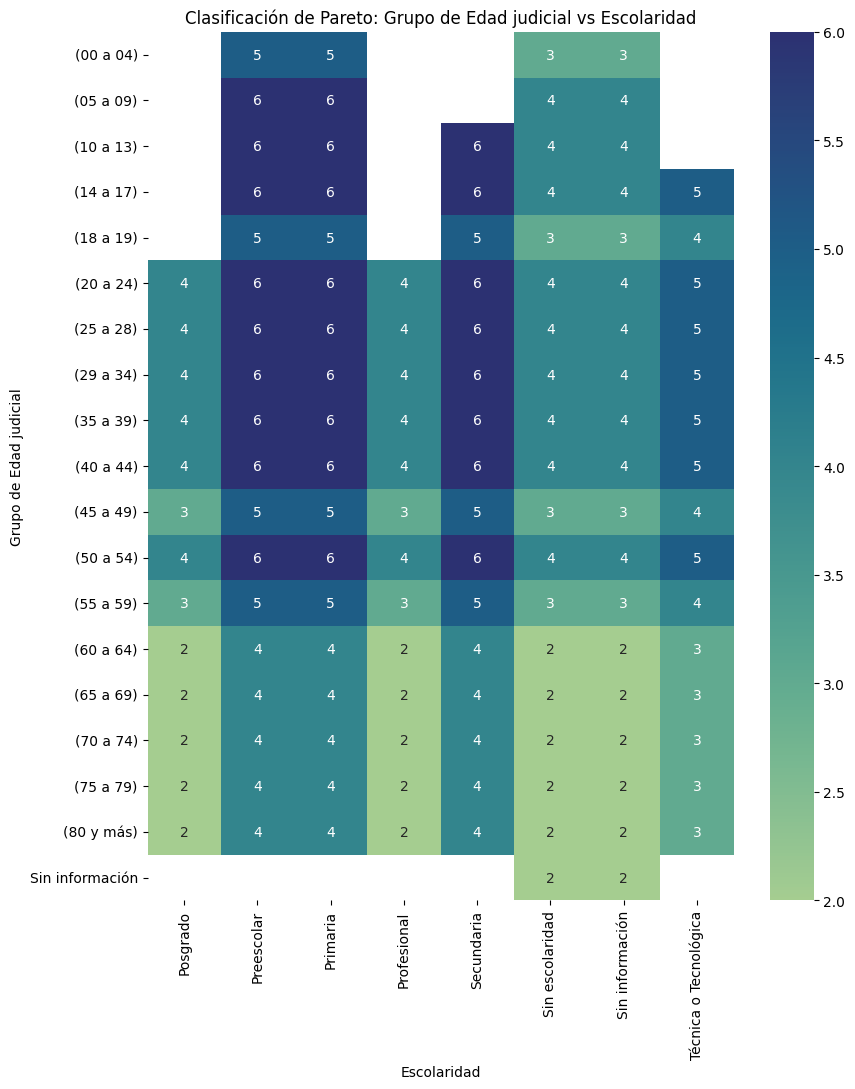

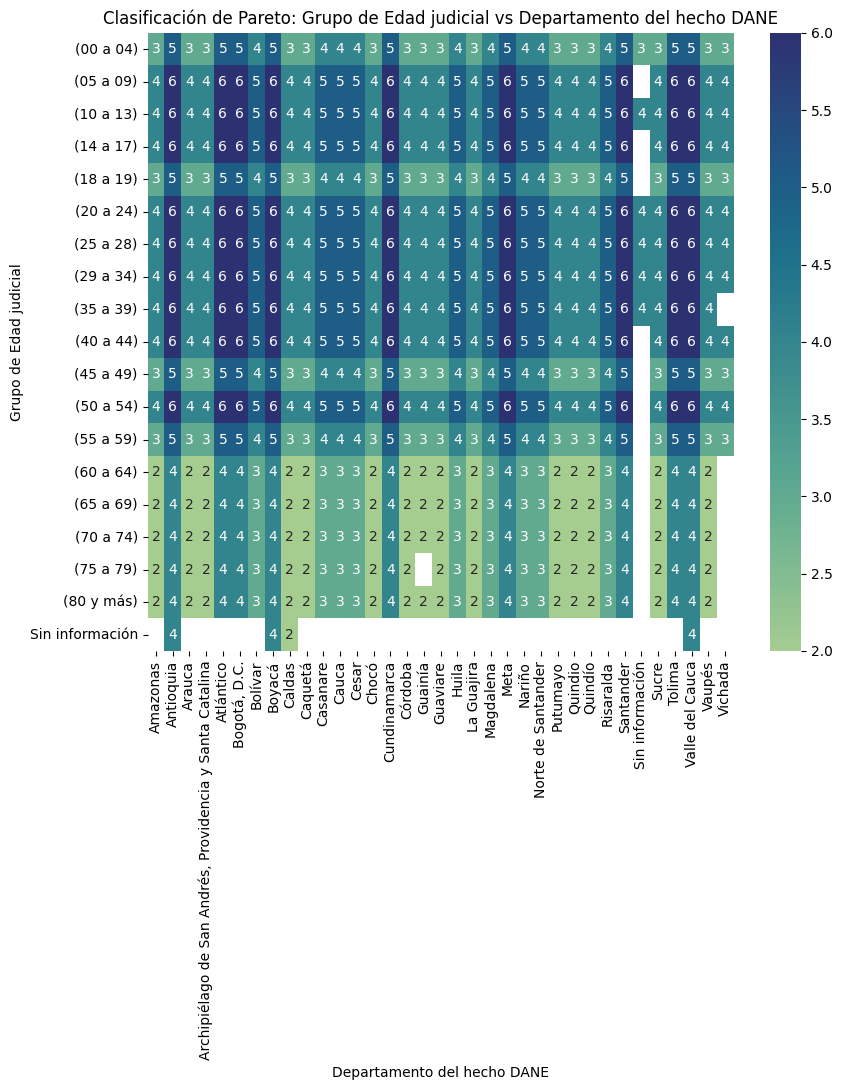

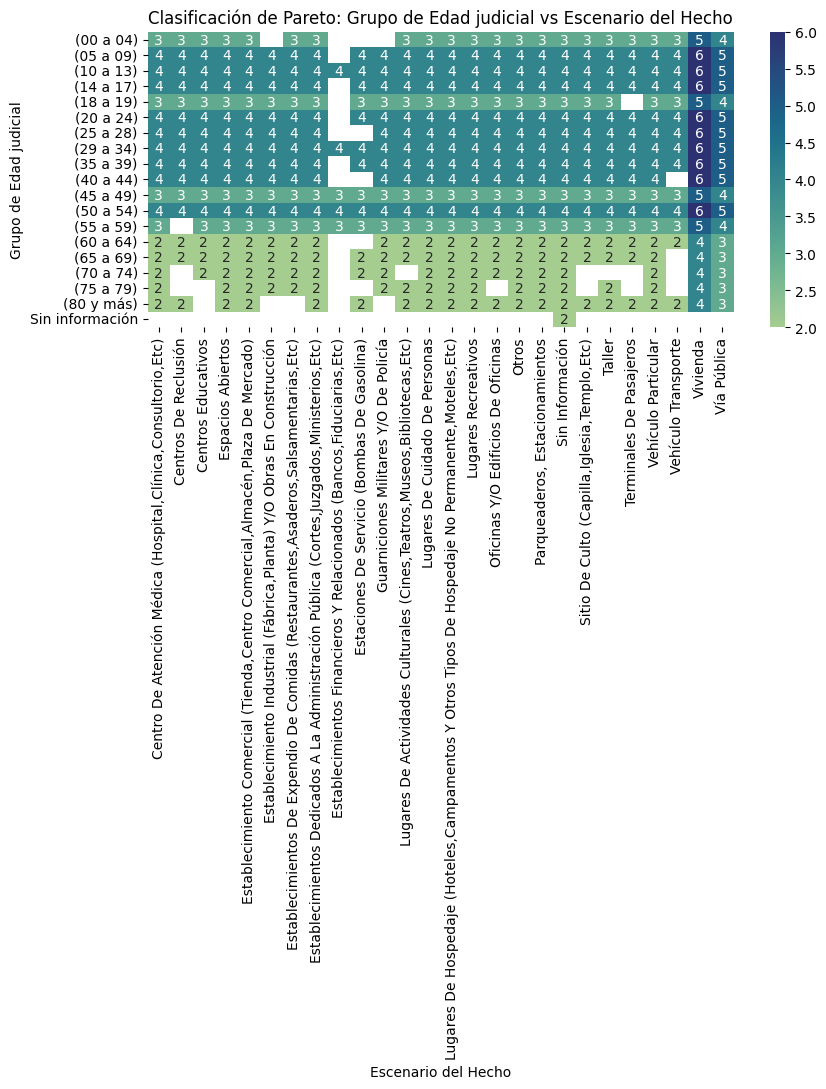

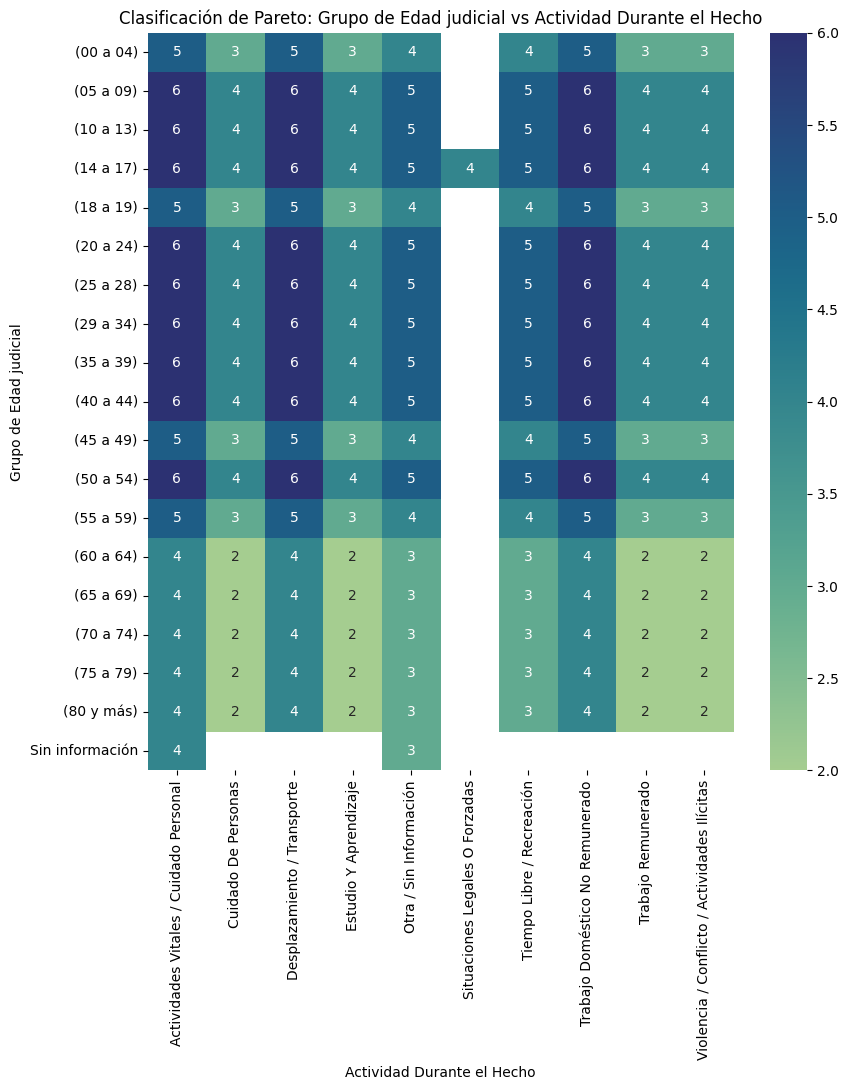

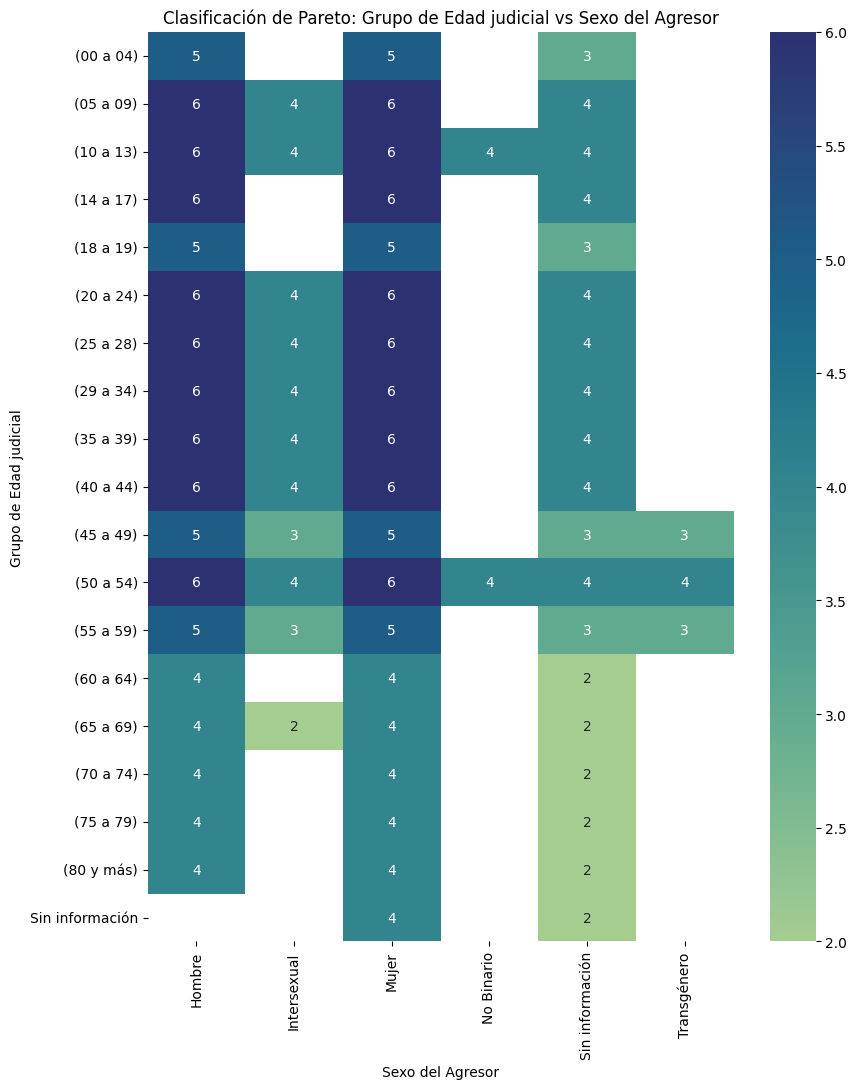

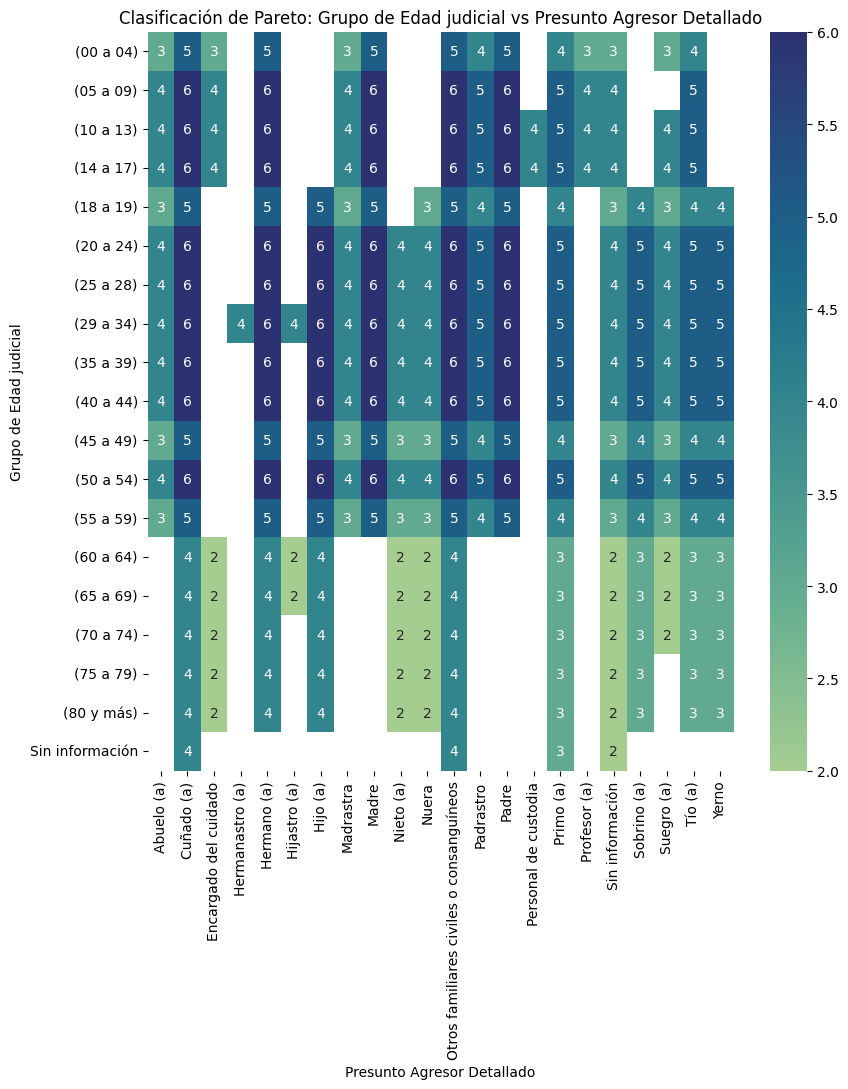

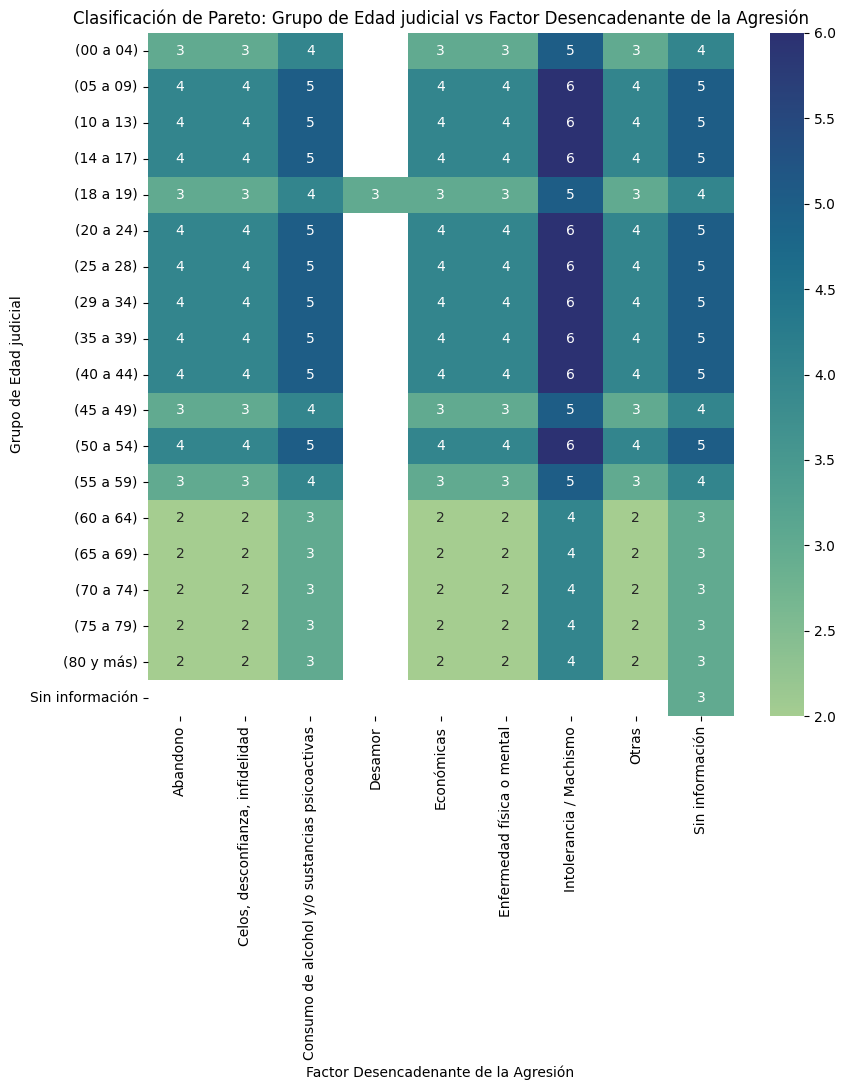

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Grupo de Edad judicial"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(9, 11))

### Escolaridad

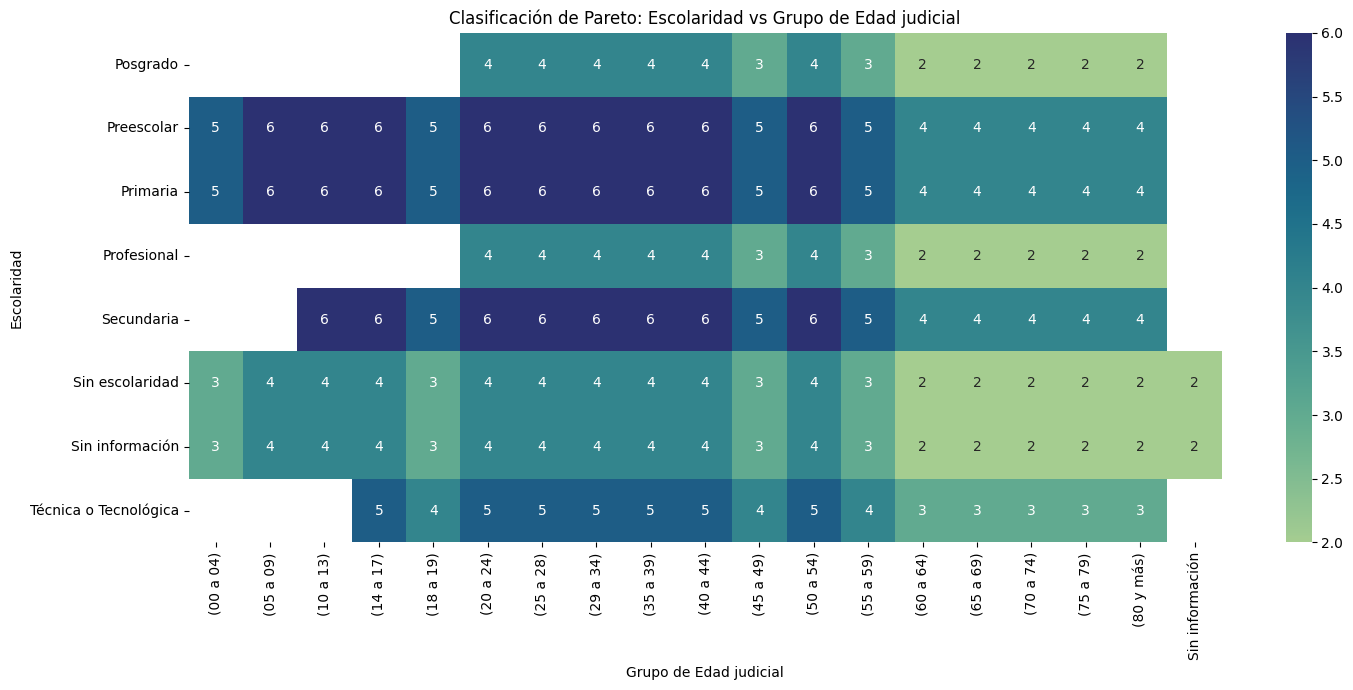

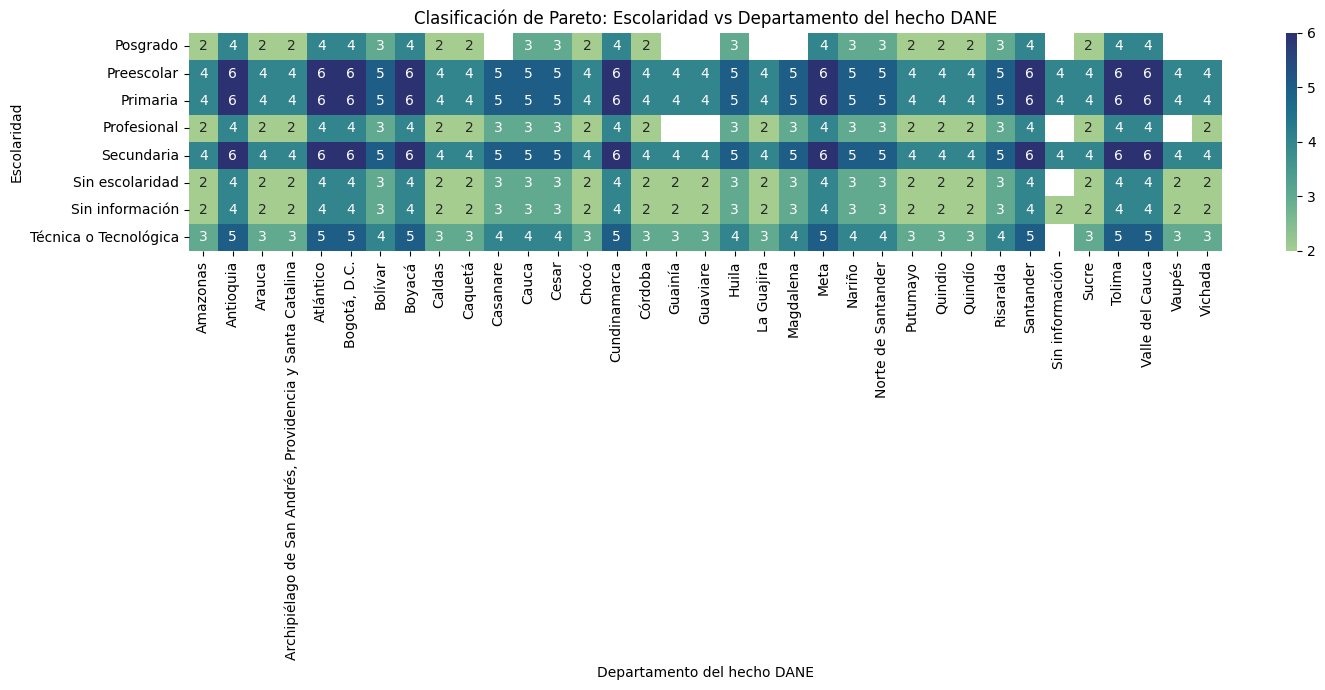

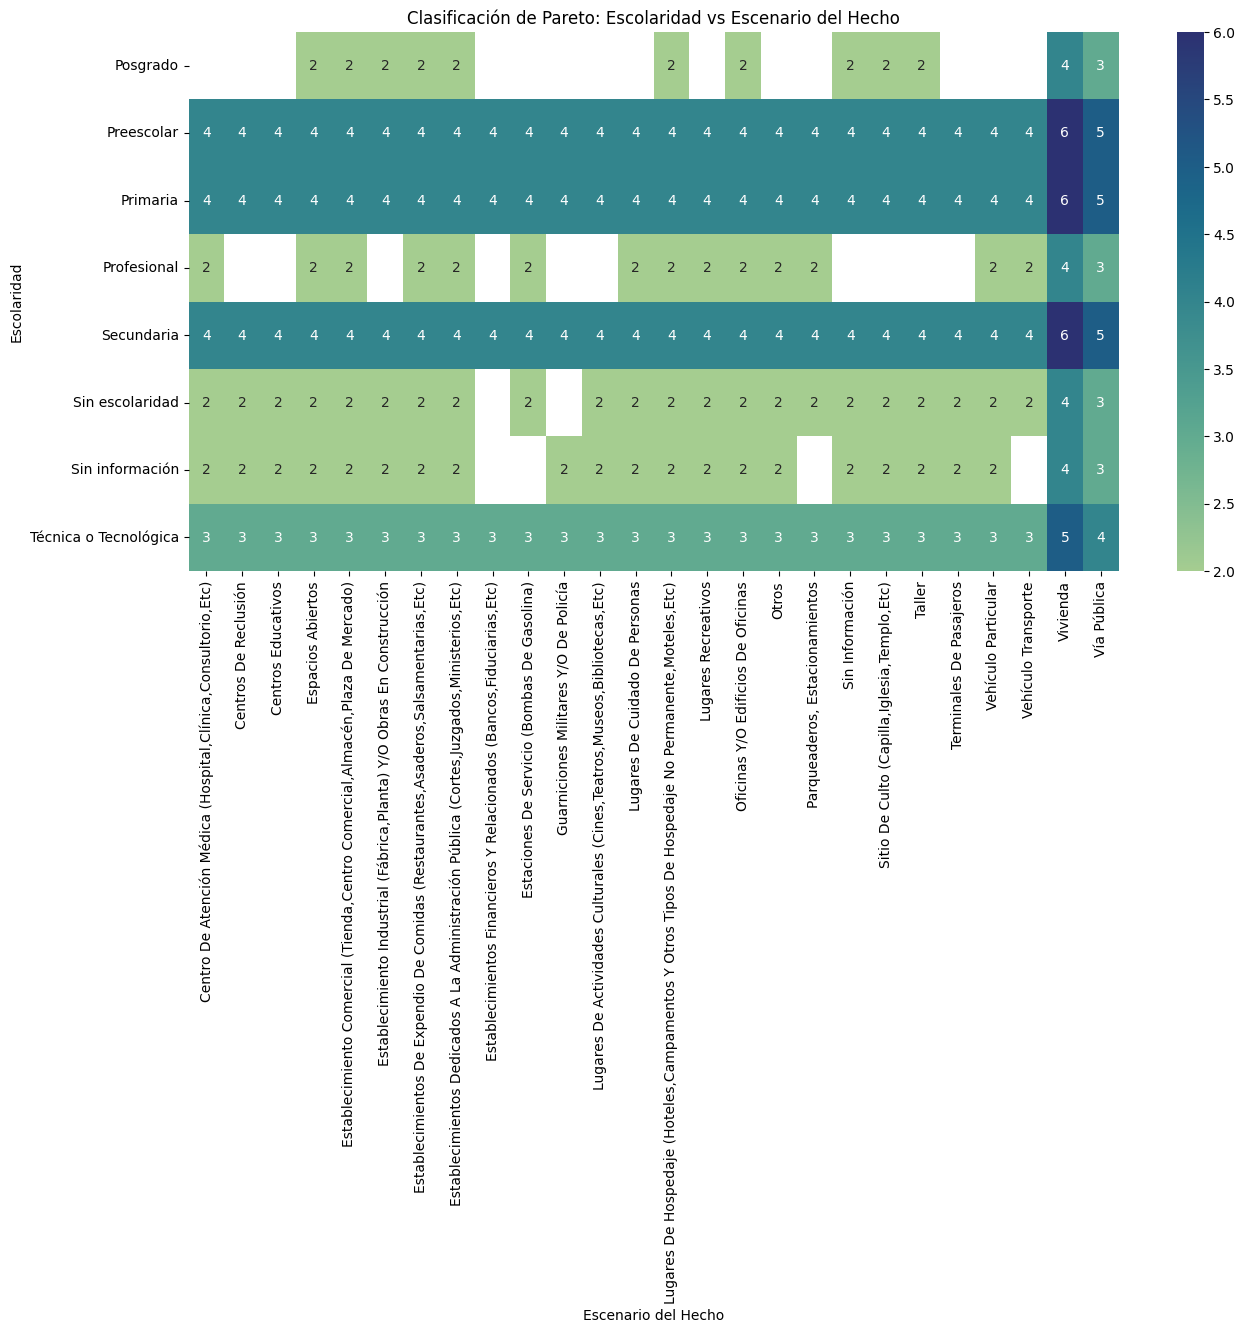

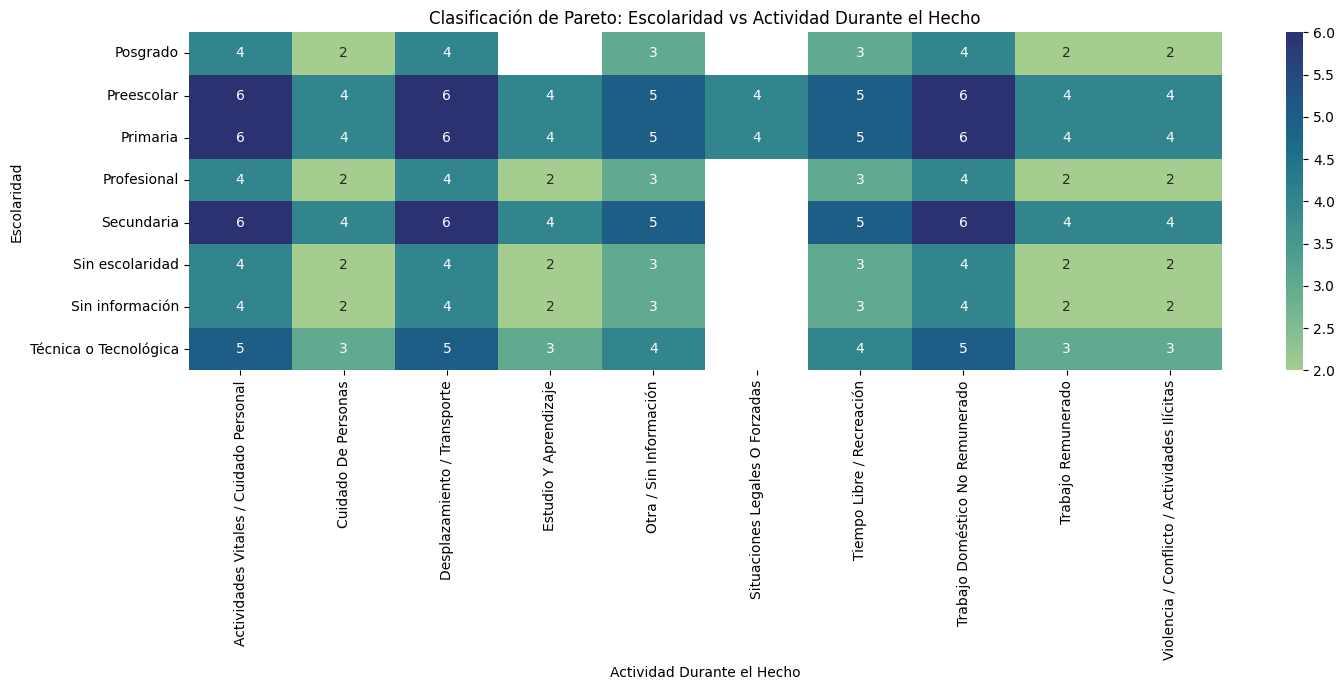

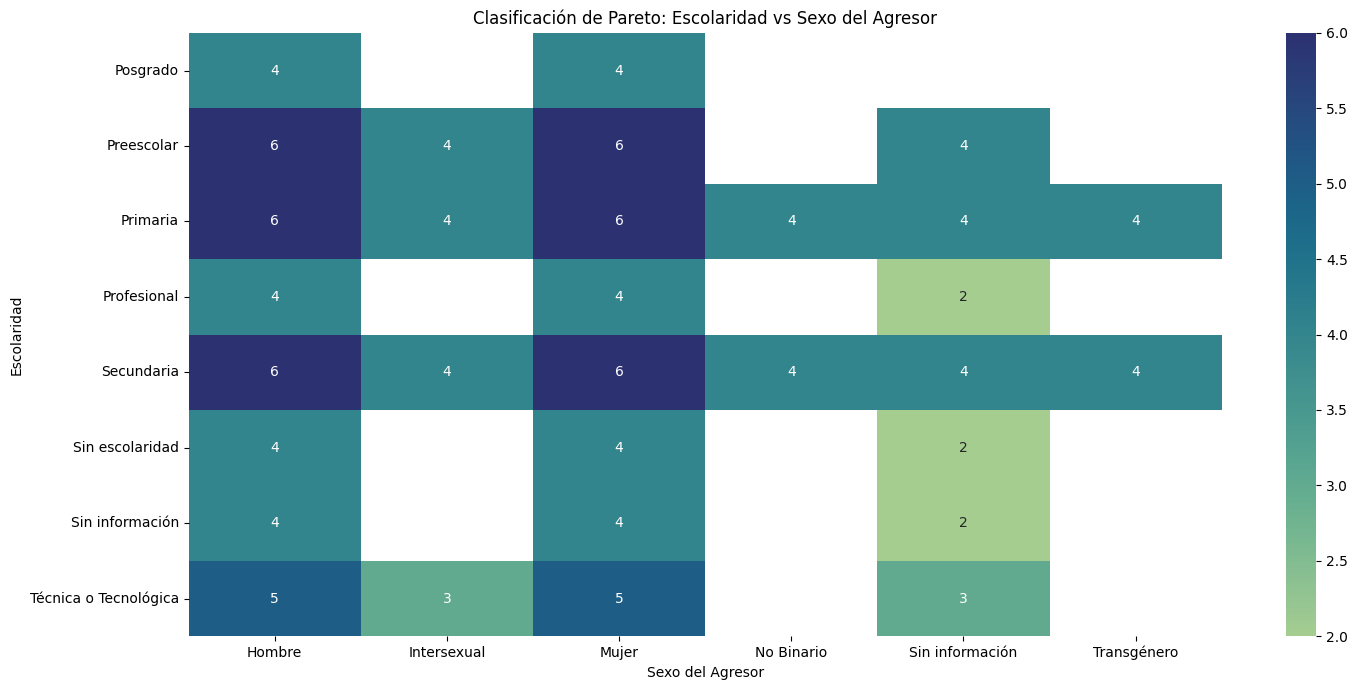

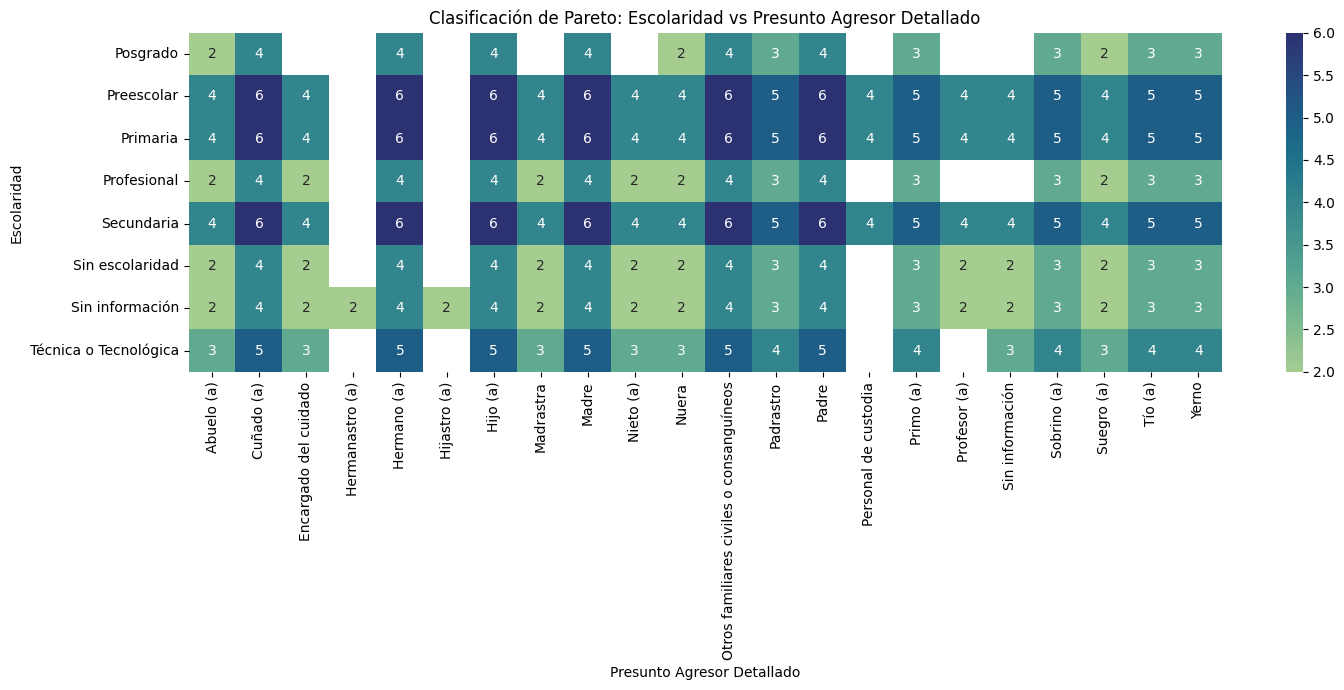

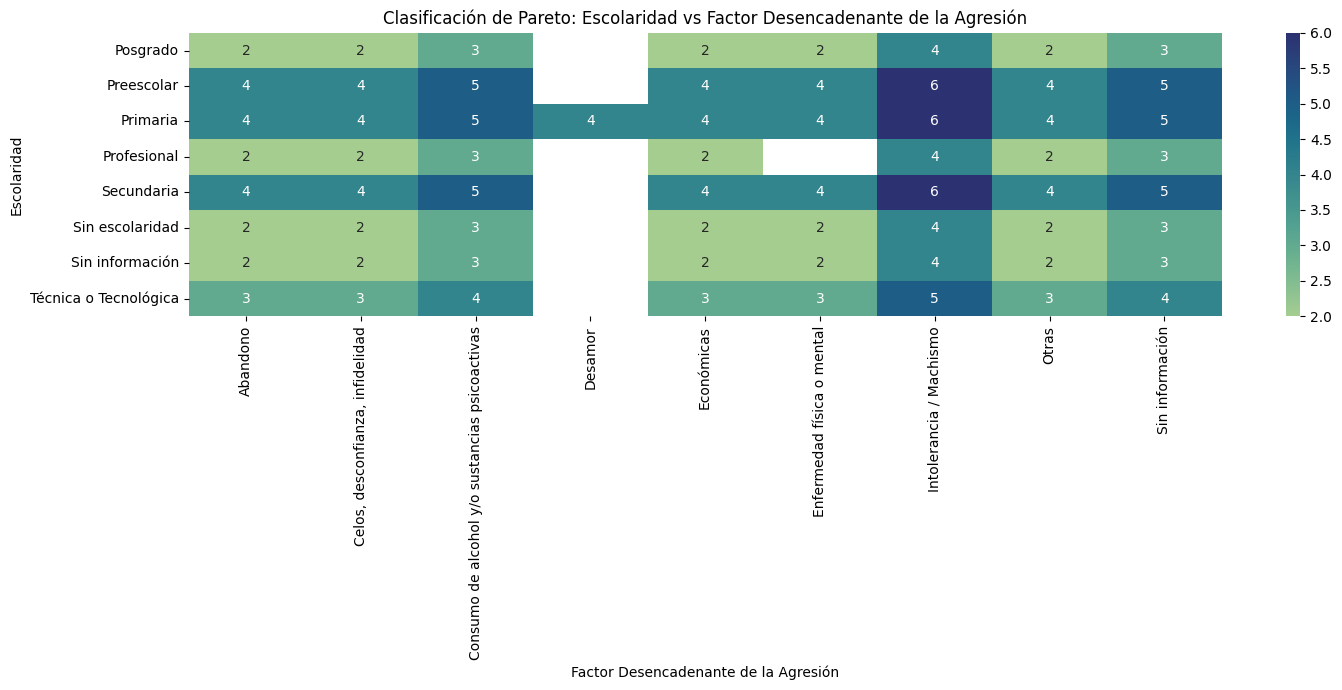

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Escolaridad"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(15, 7))

### Departamento del hecho DANE

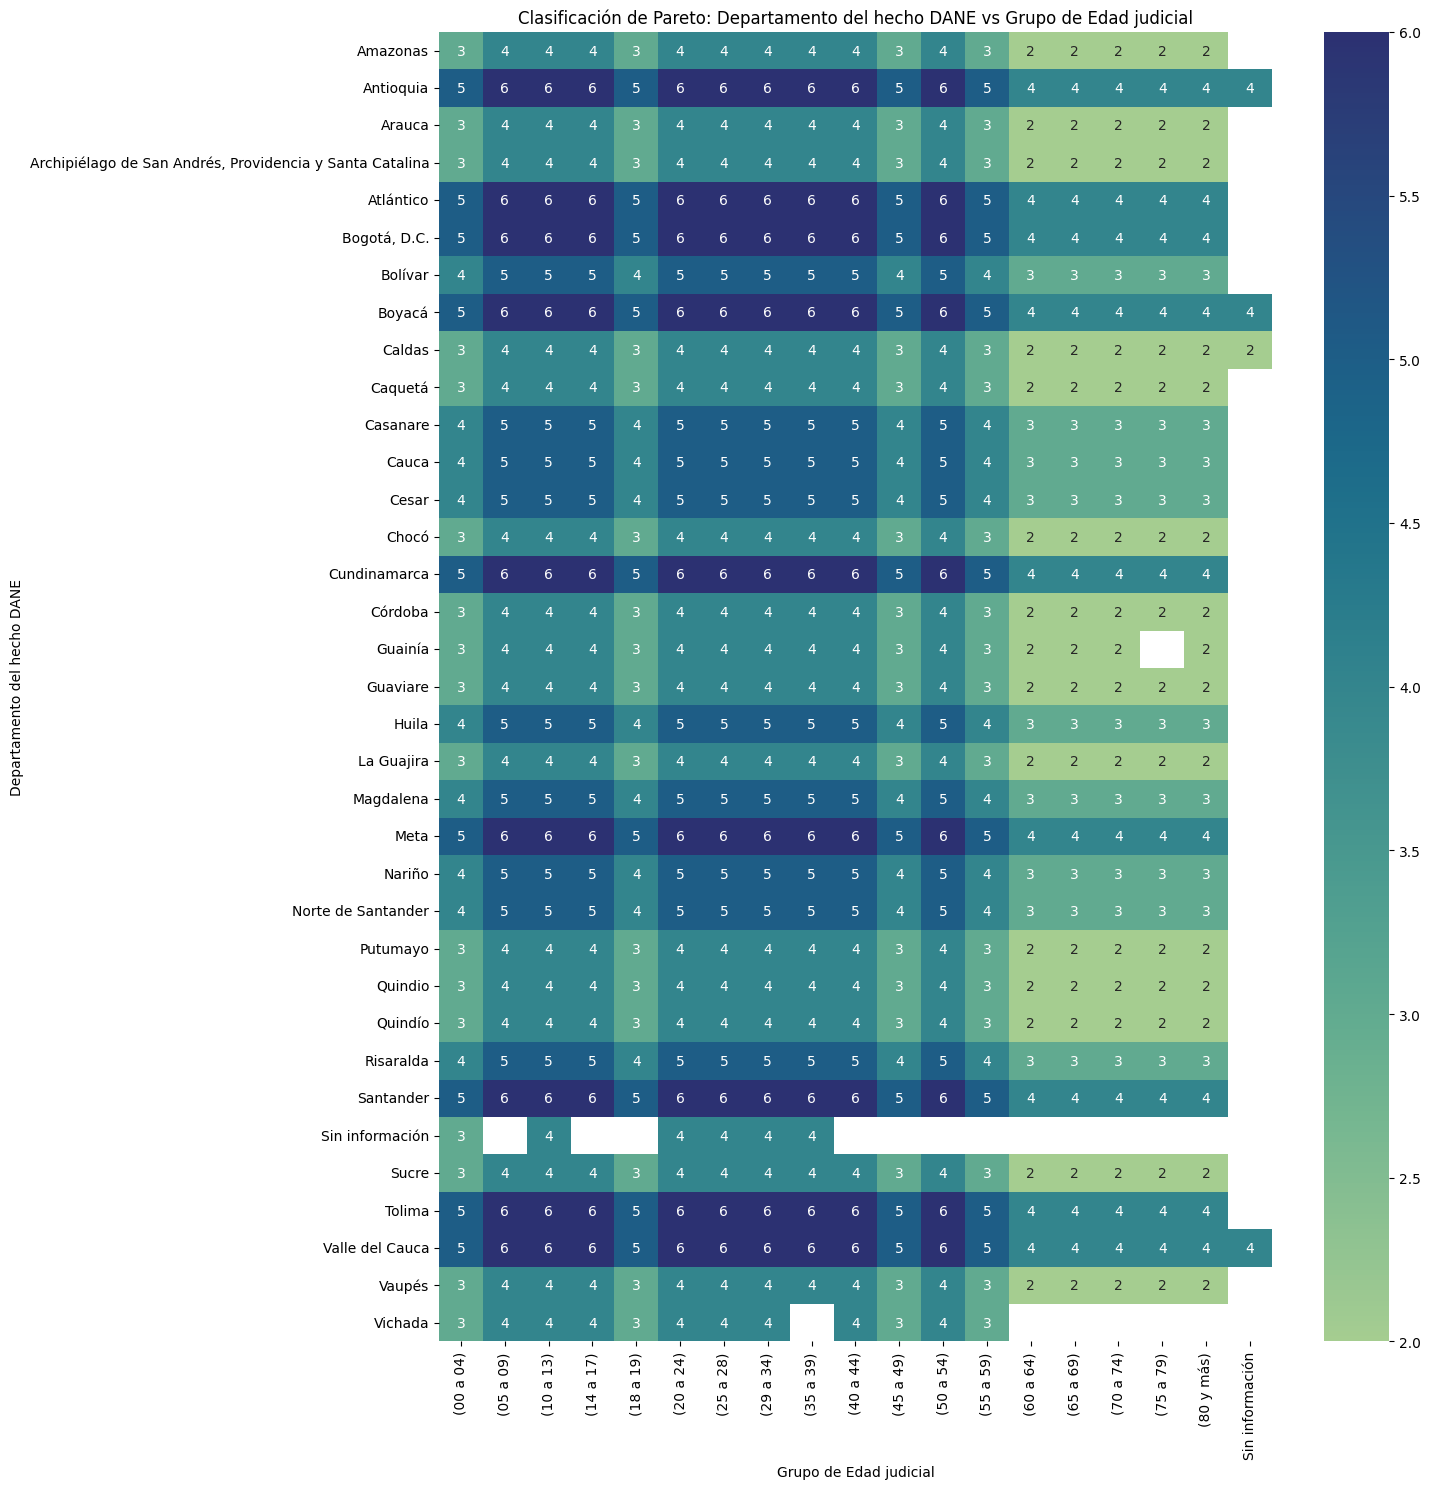

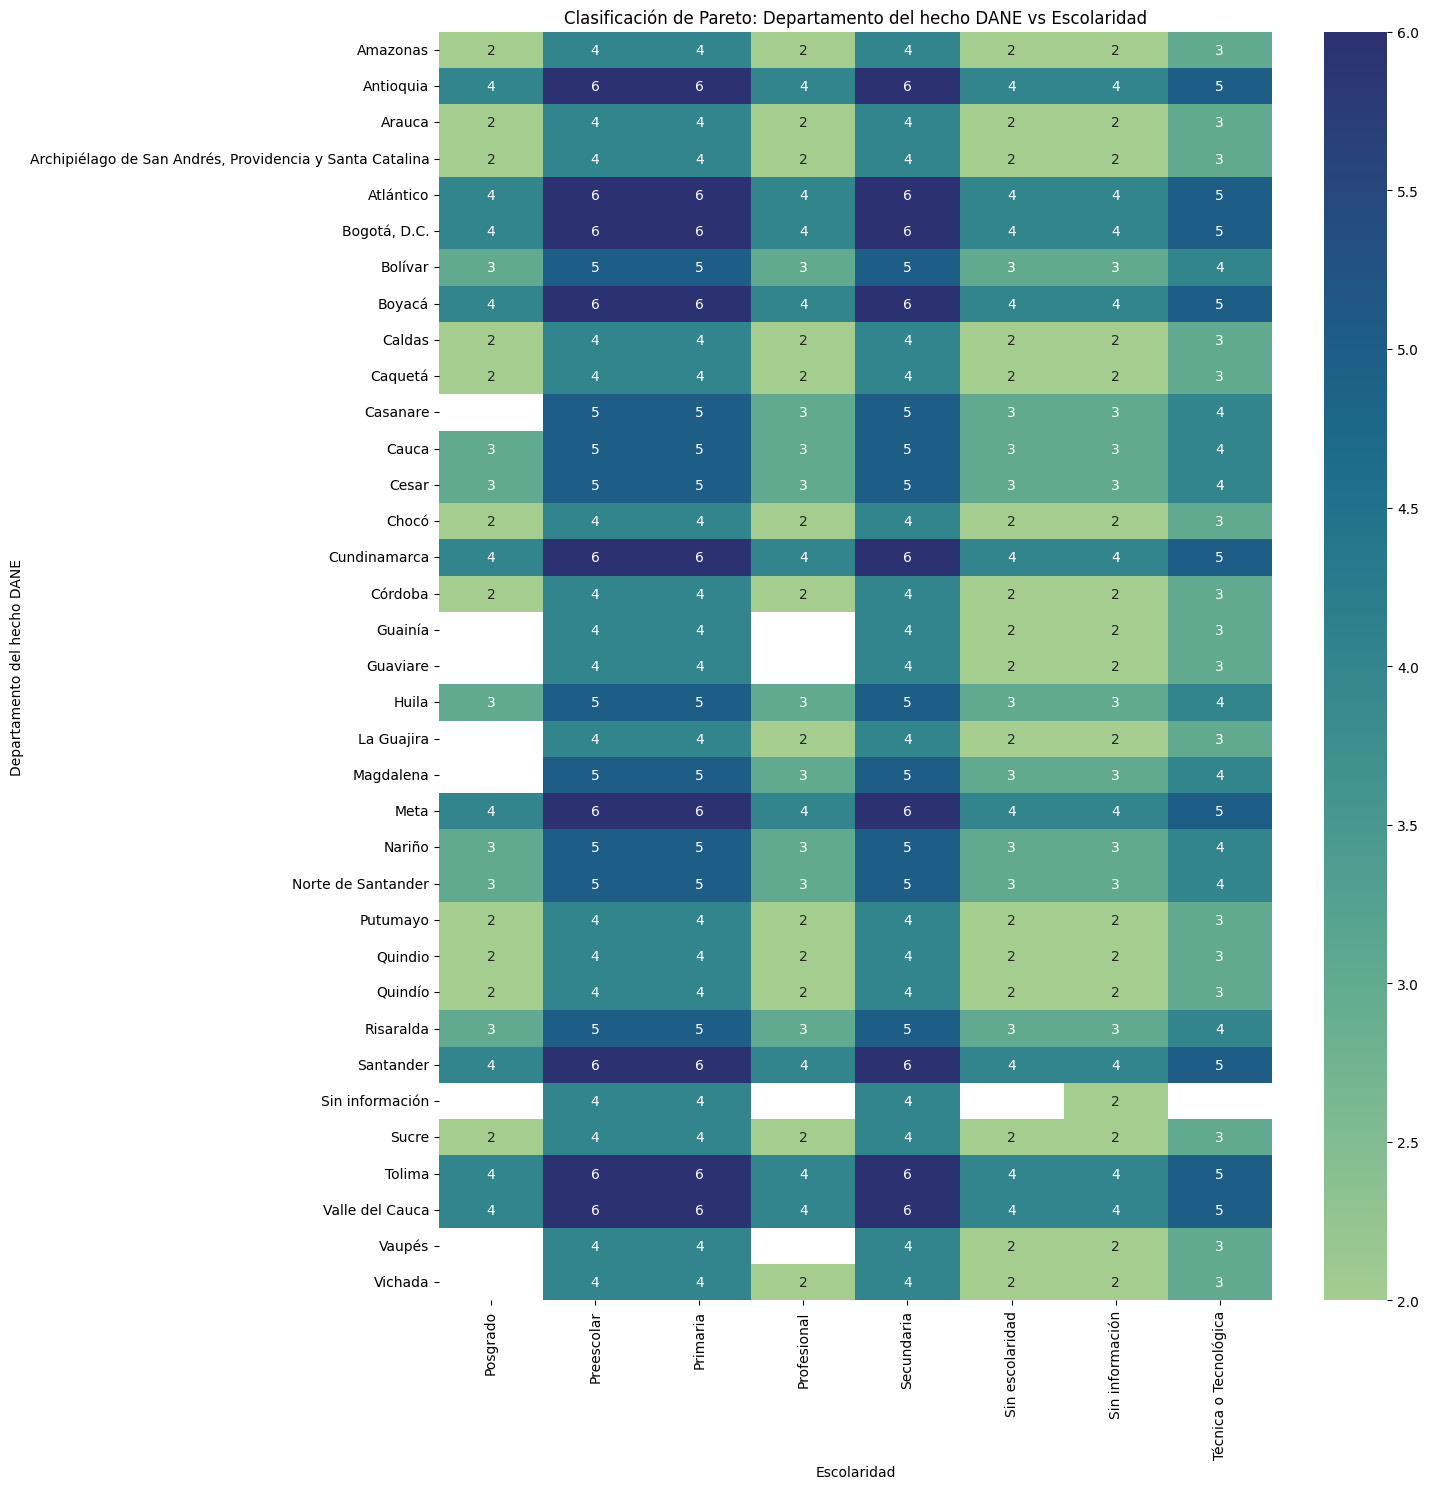

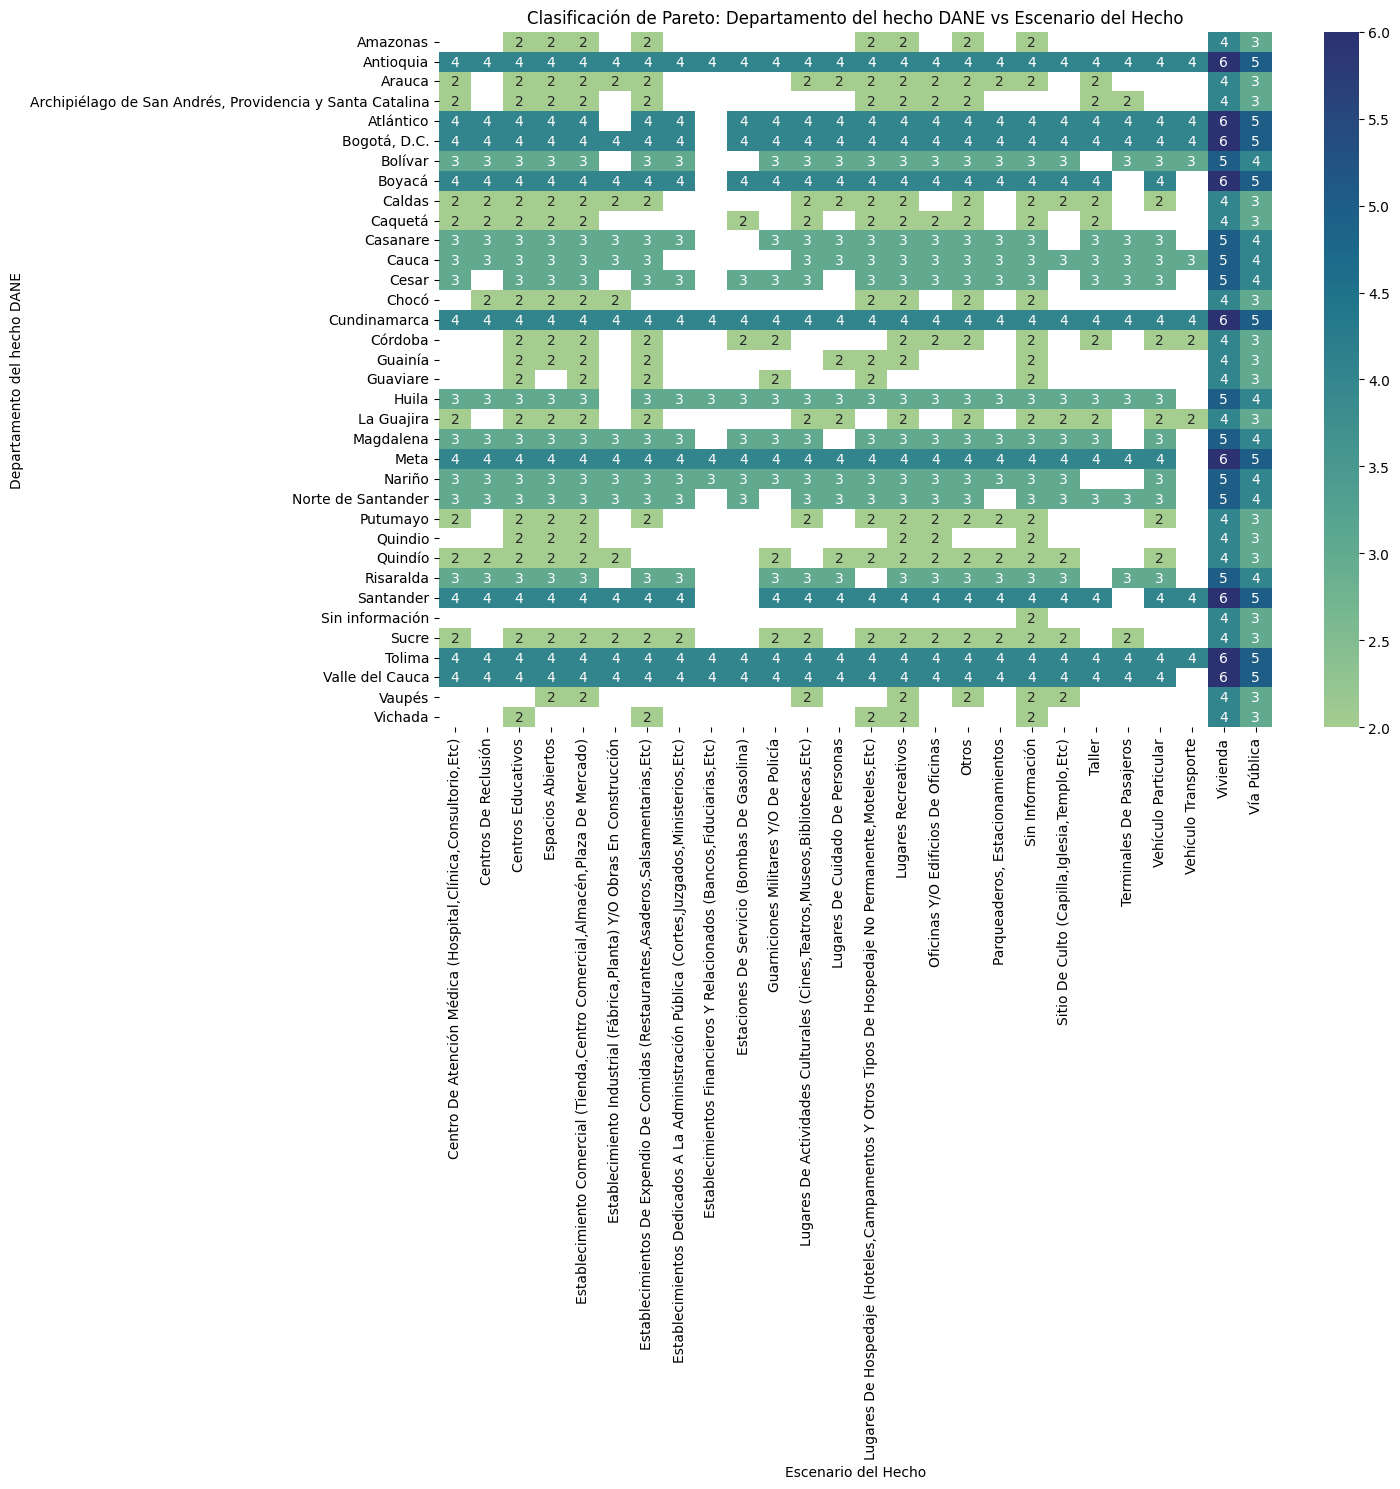

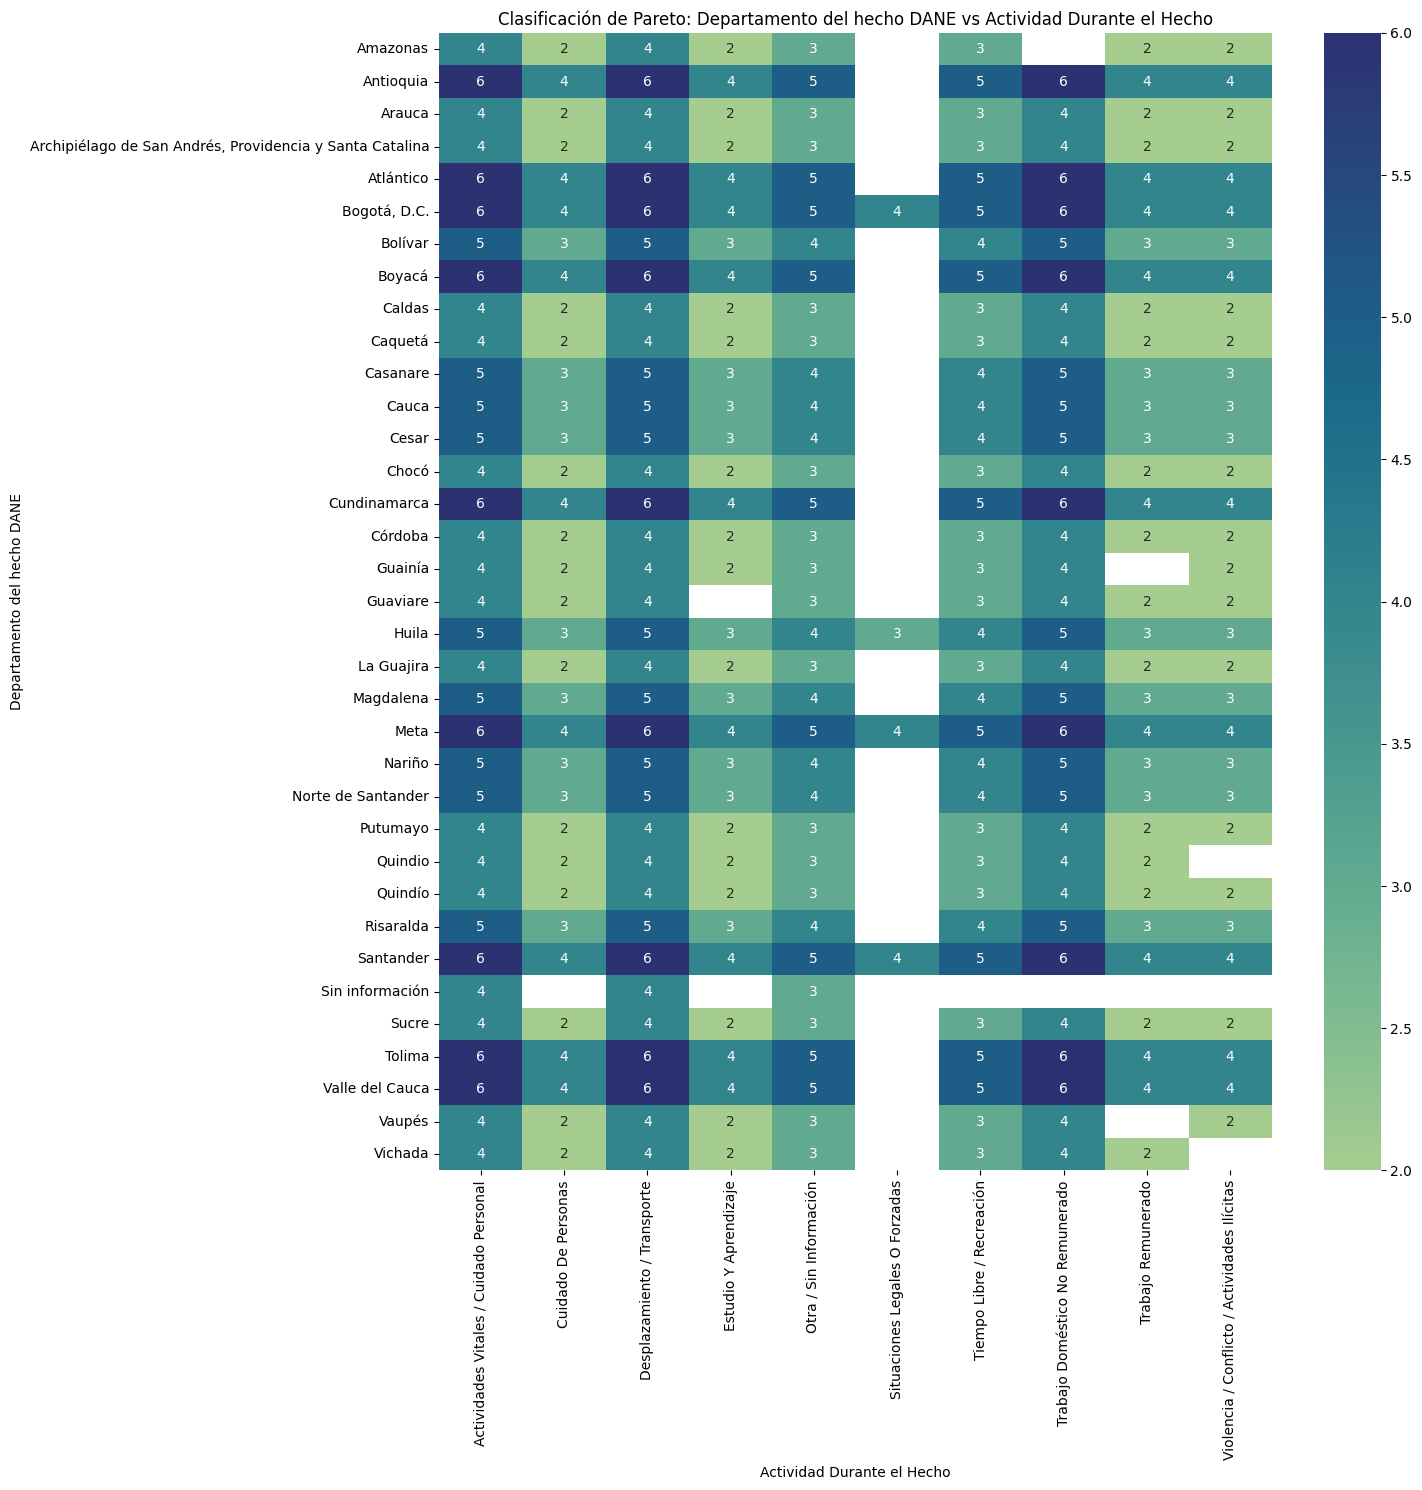

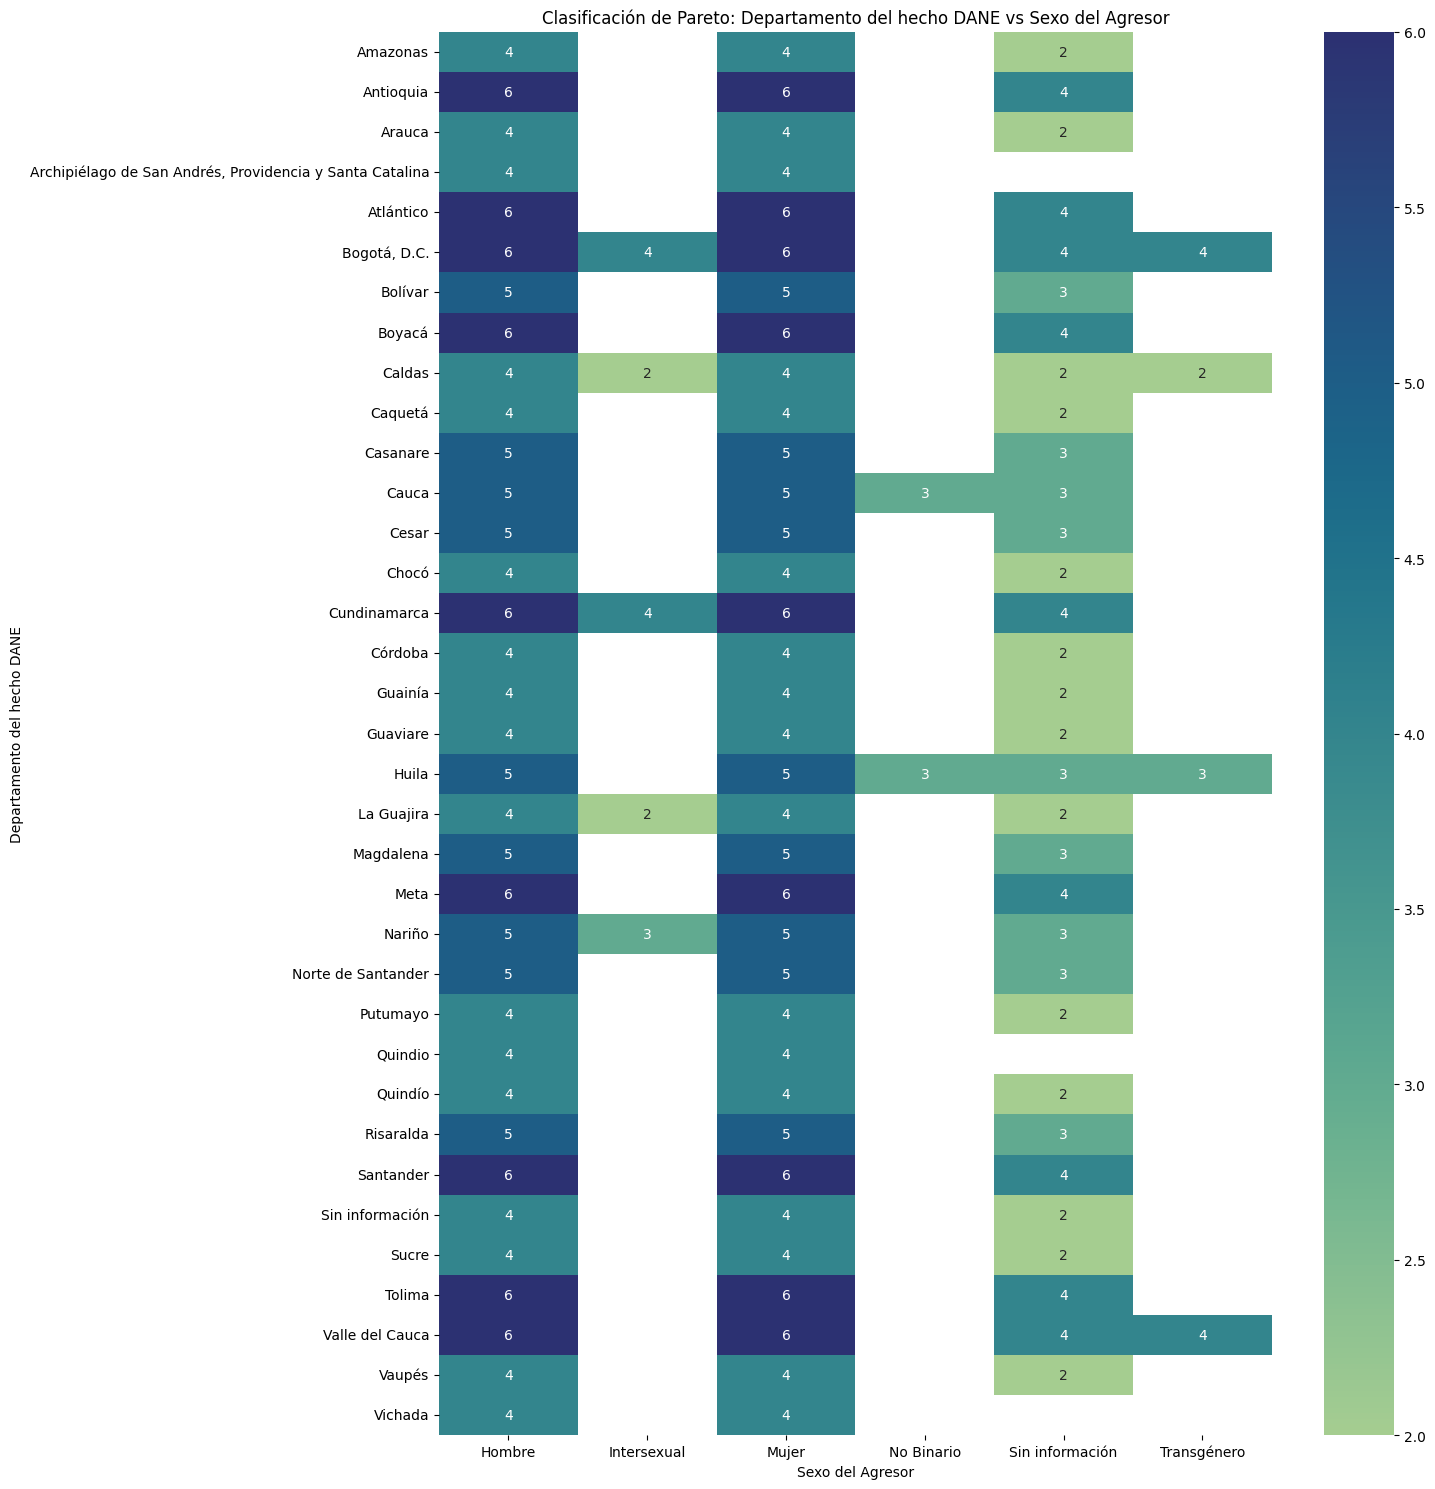

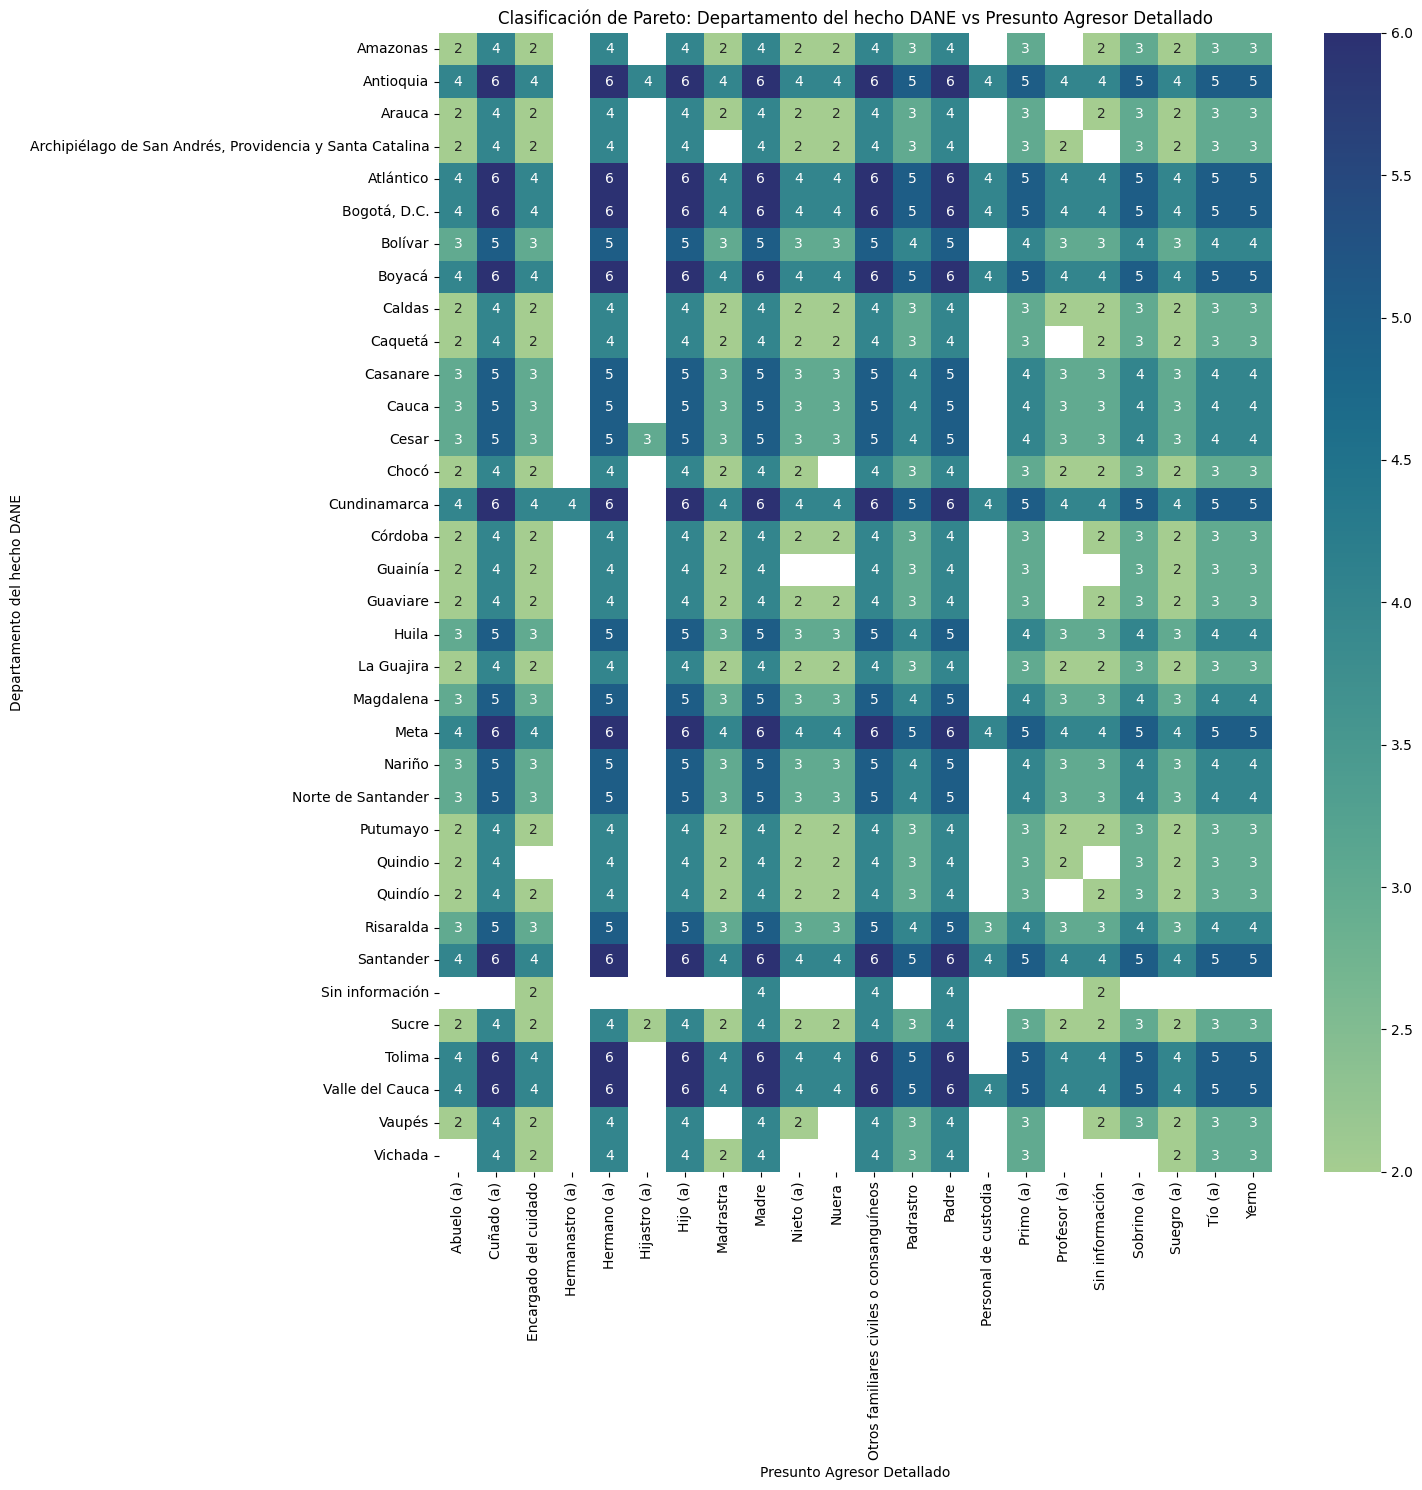

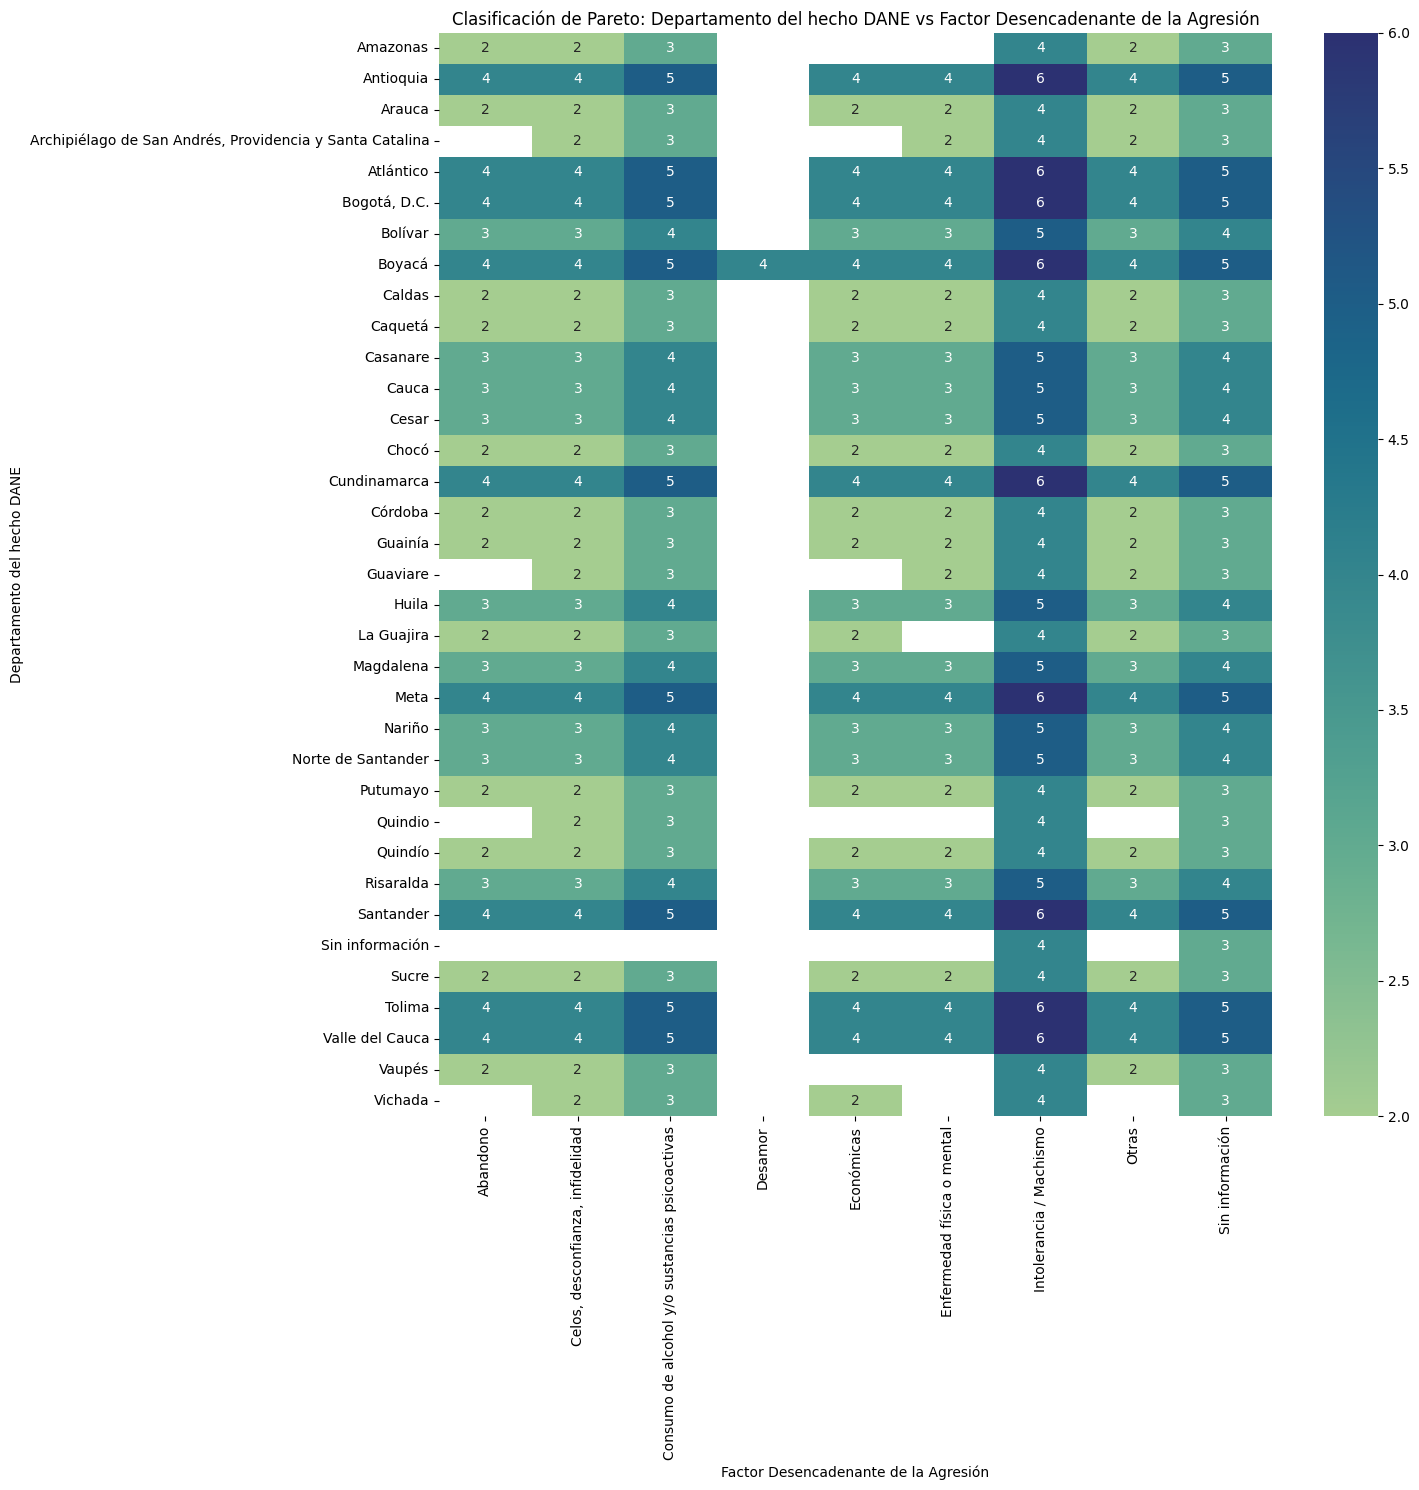

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Departamento del hecho DANE"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(15, 15))

### Escenario del Hecho

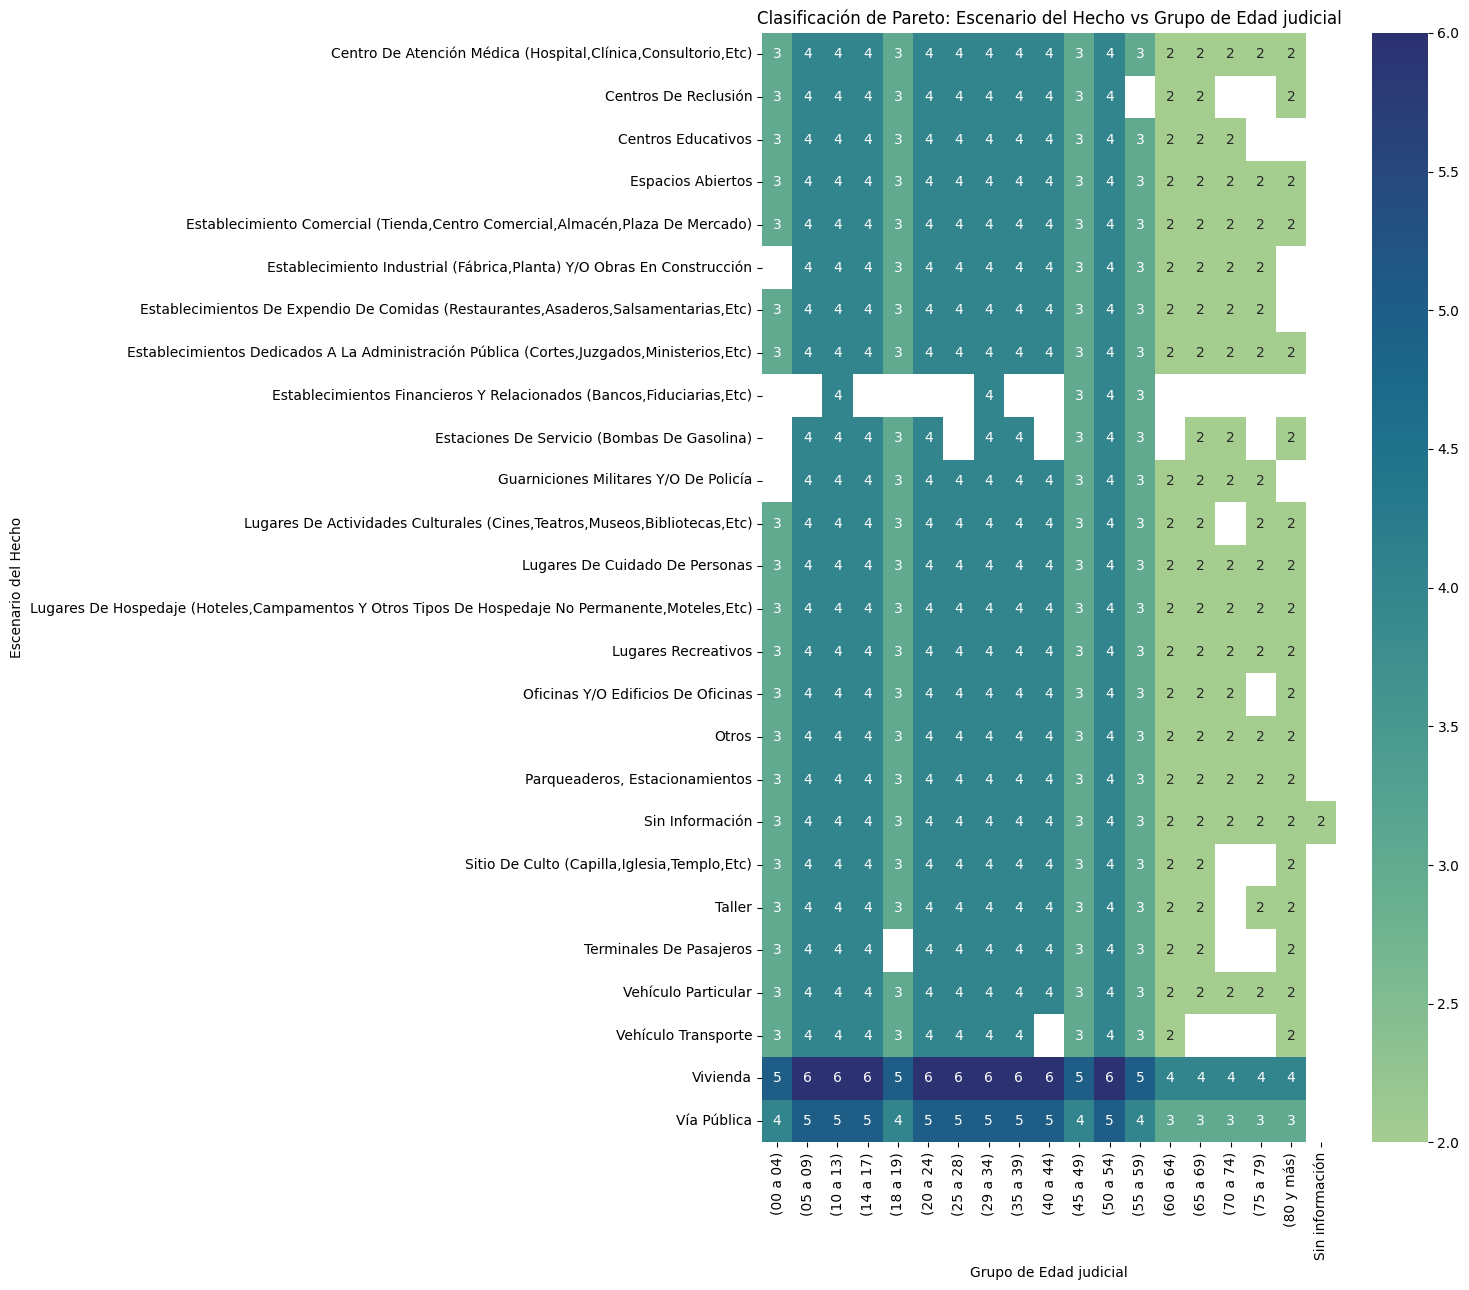

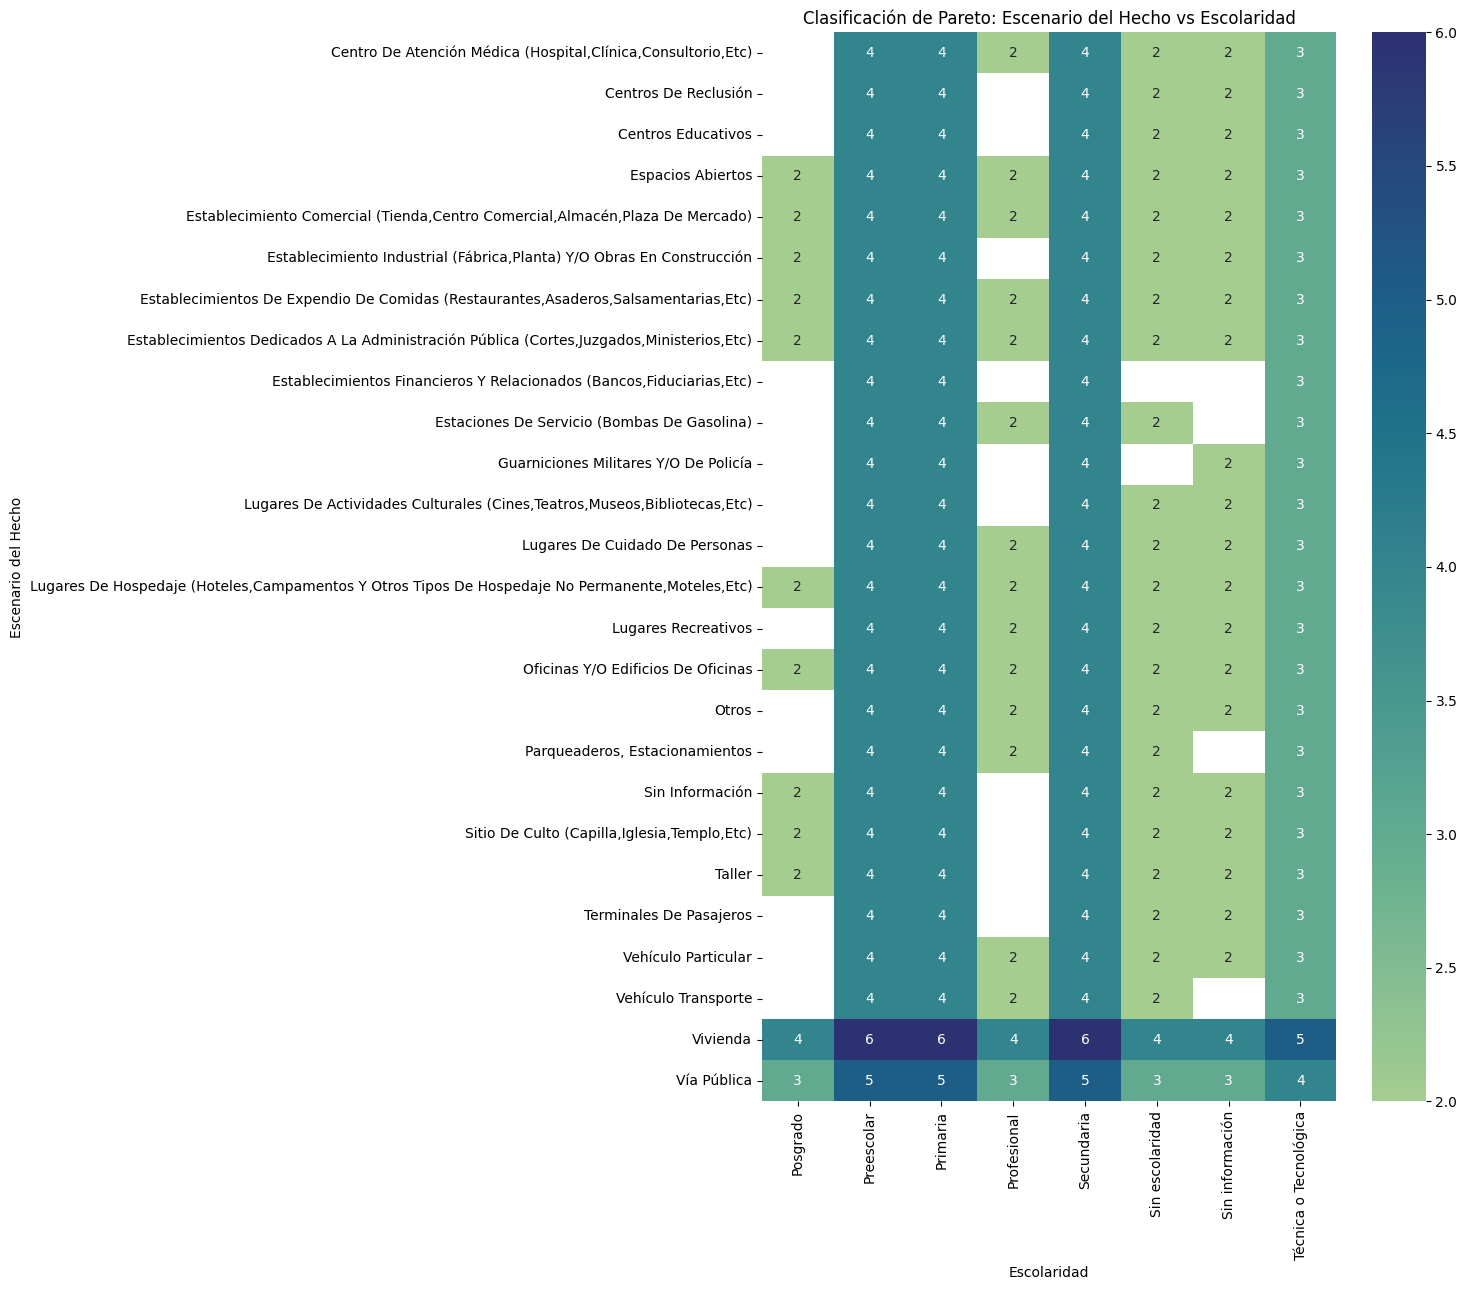

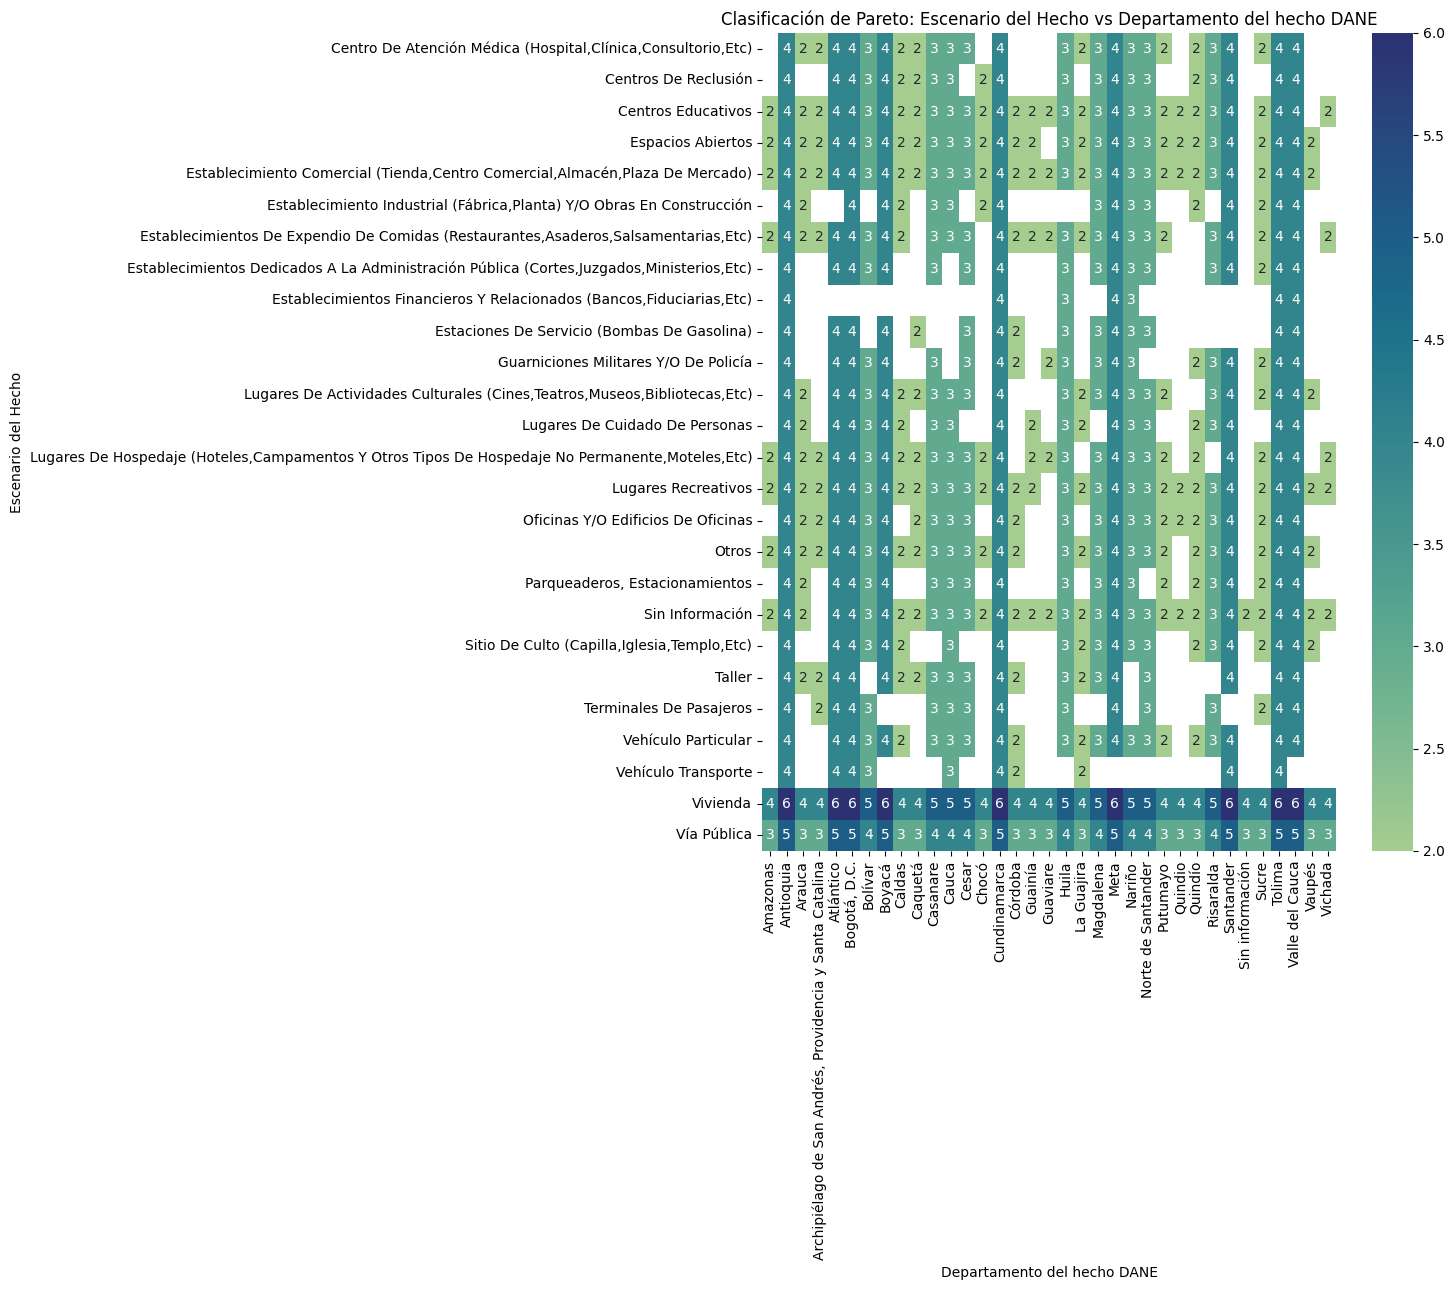

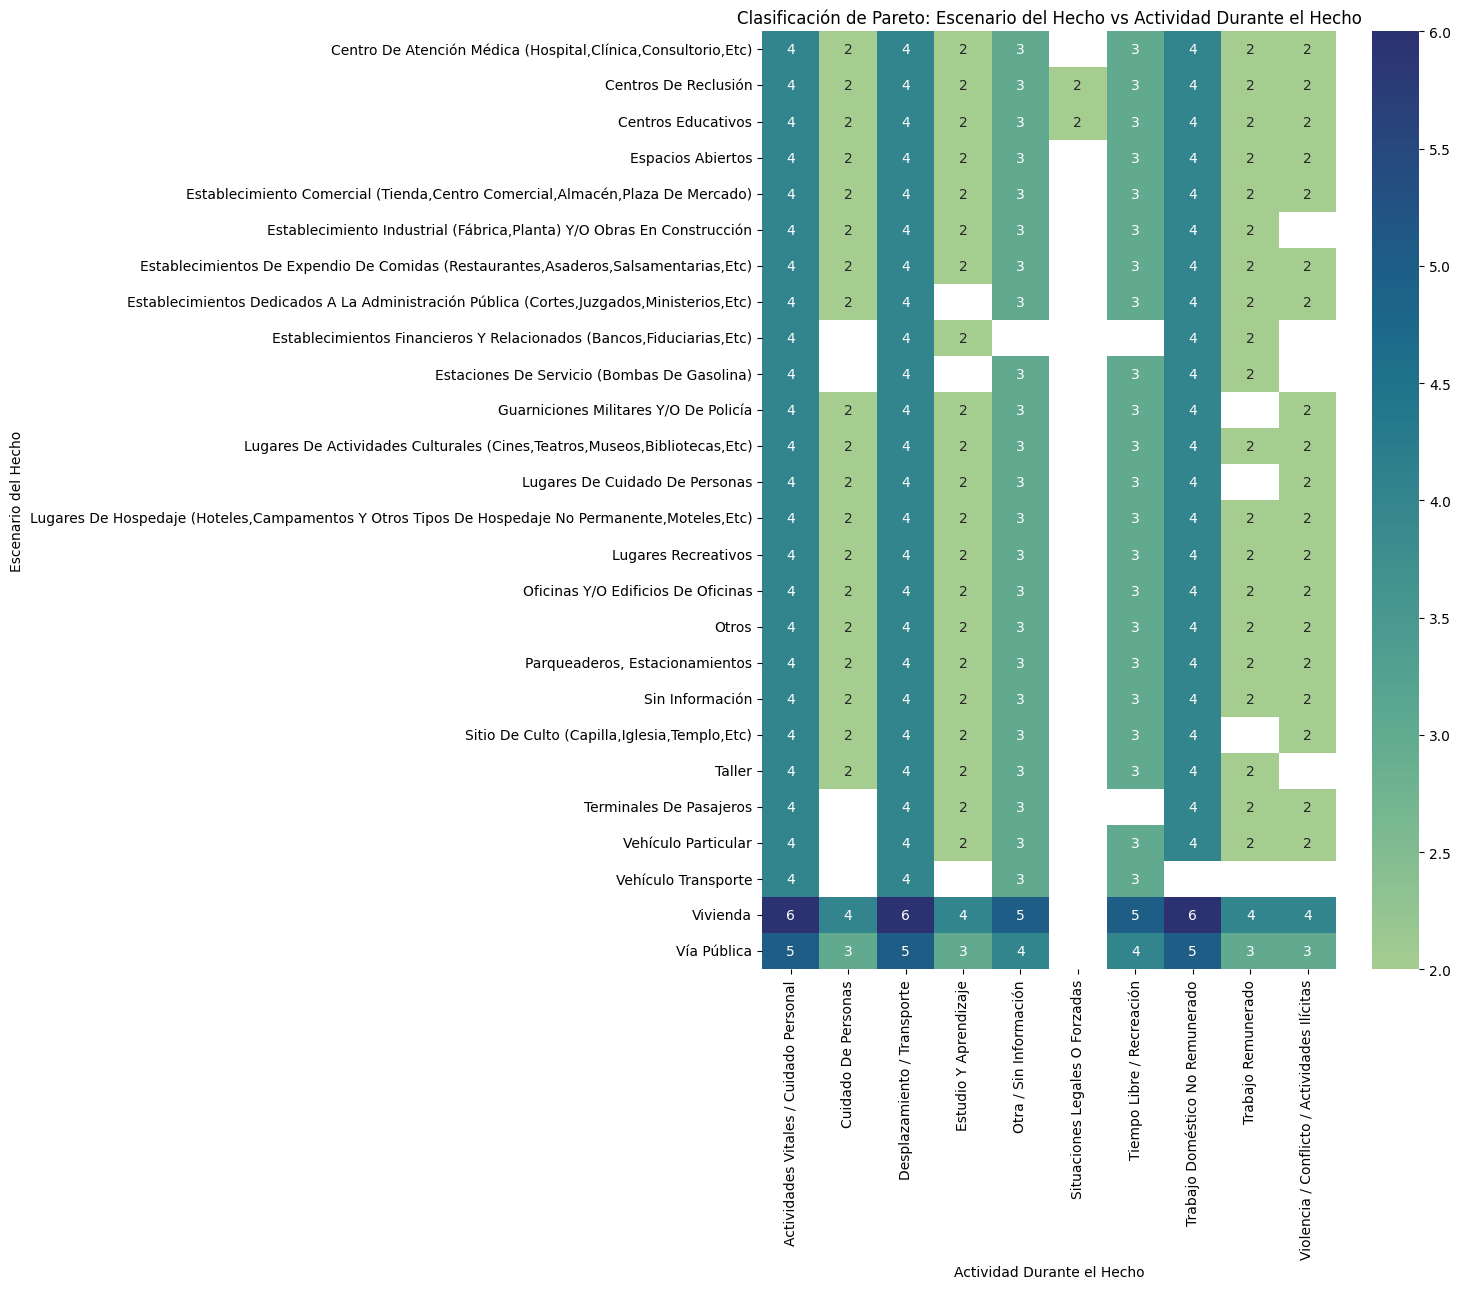

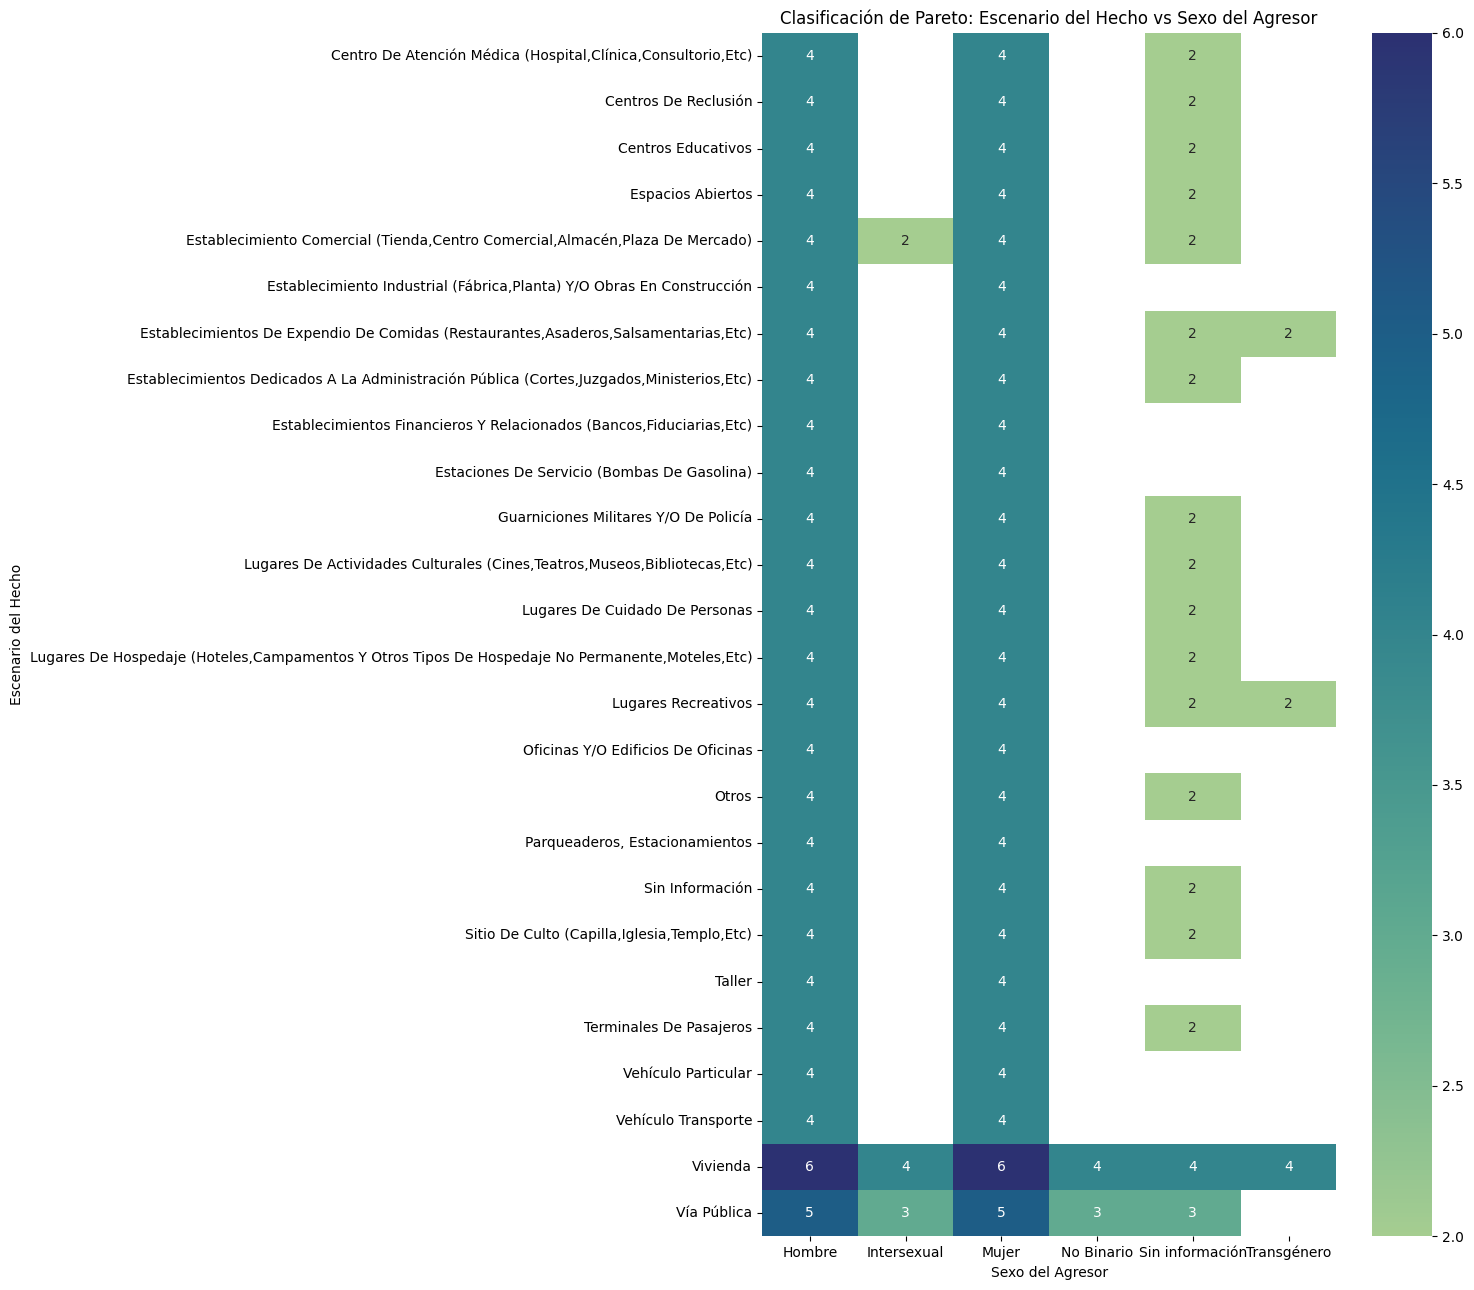

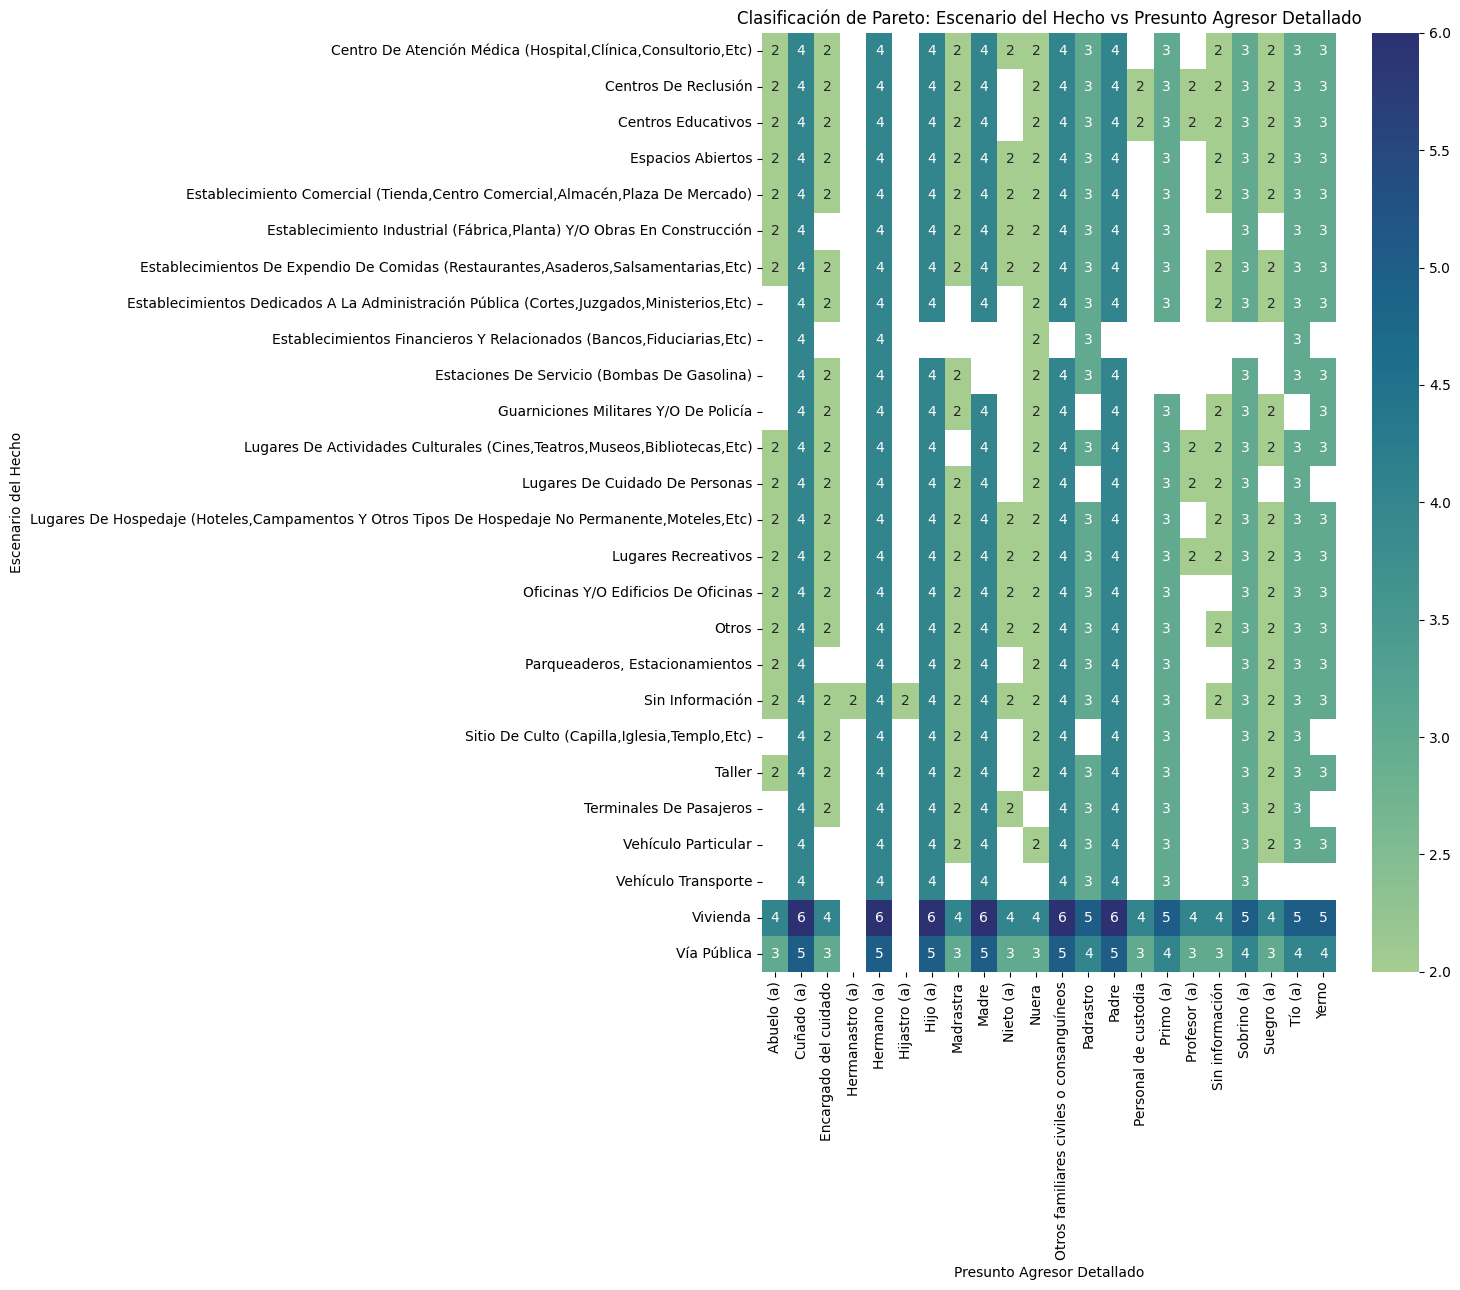

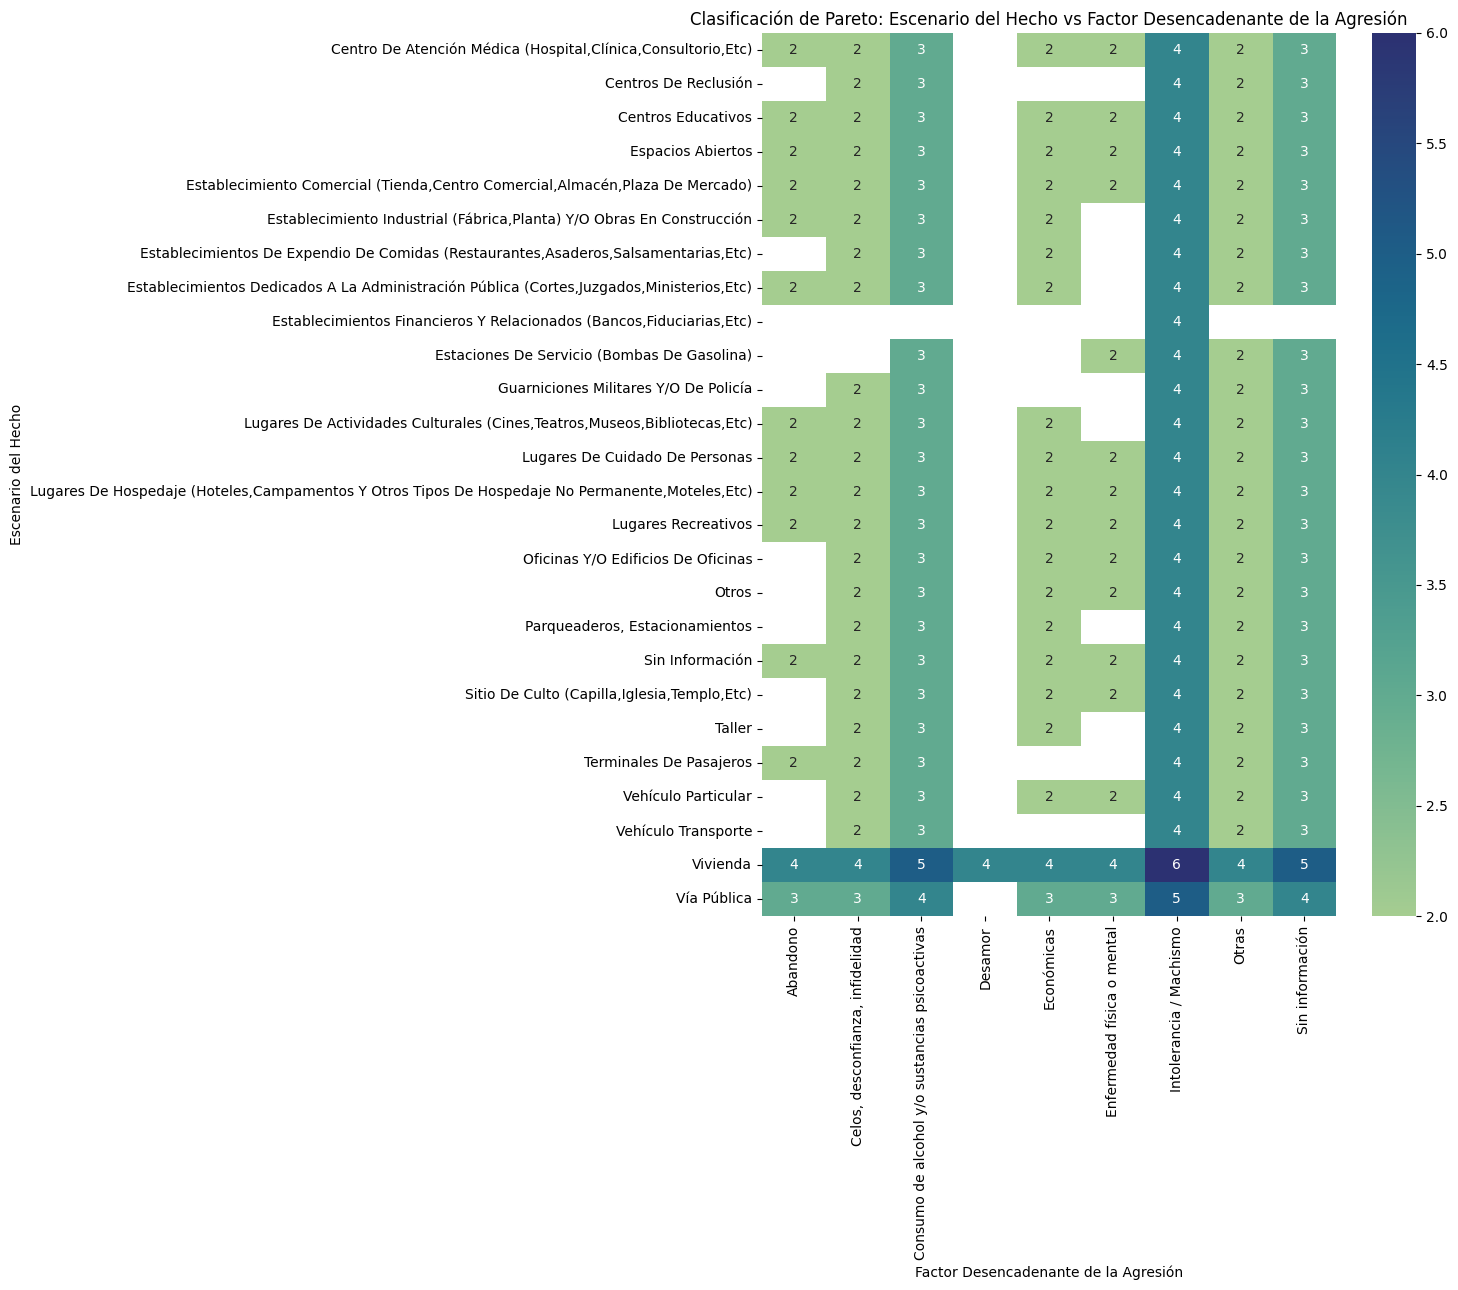

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Escenario del Hecho"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(15, 13))

### Actividad Durante el Hecho

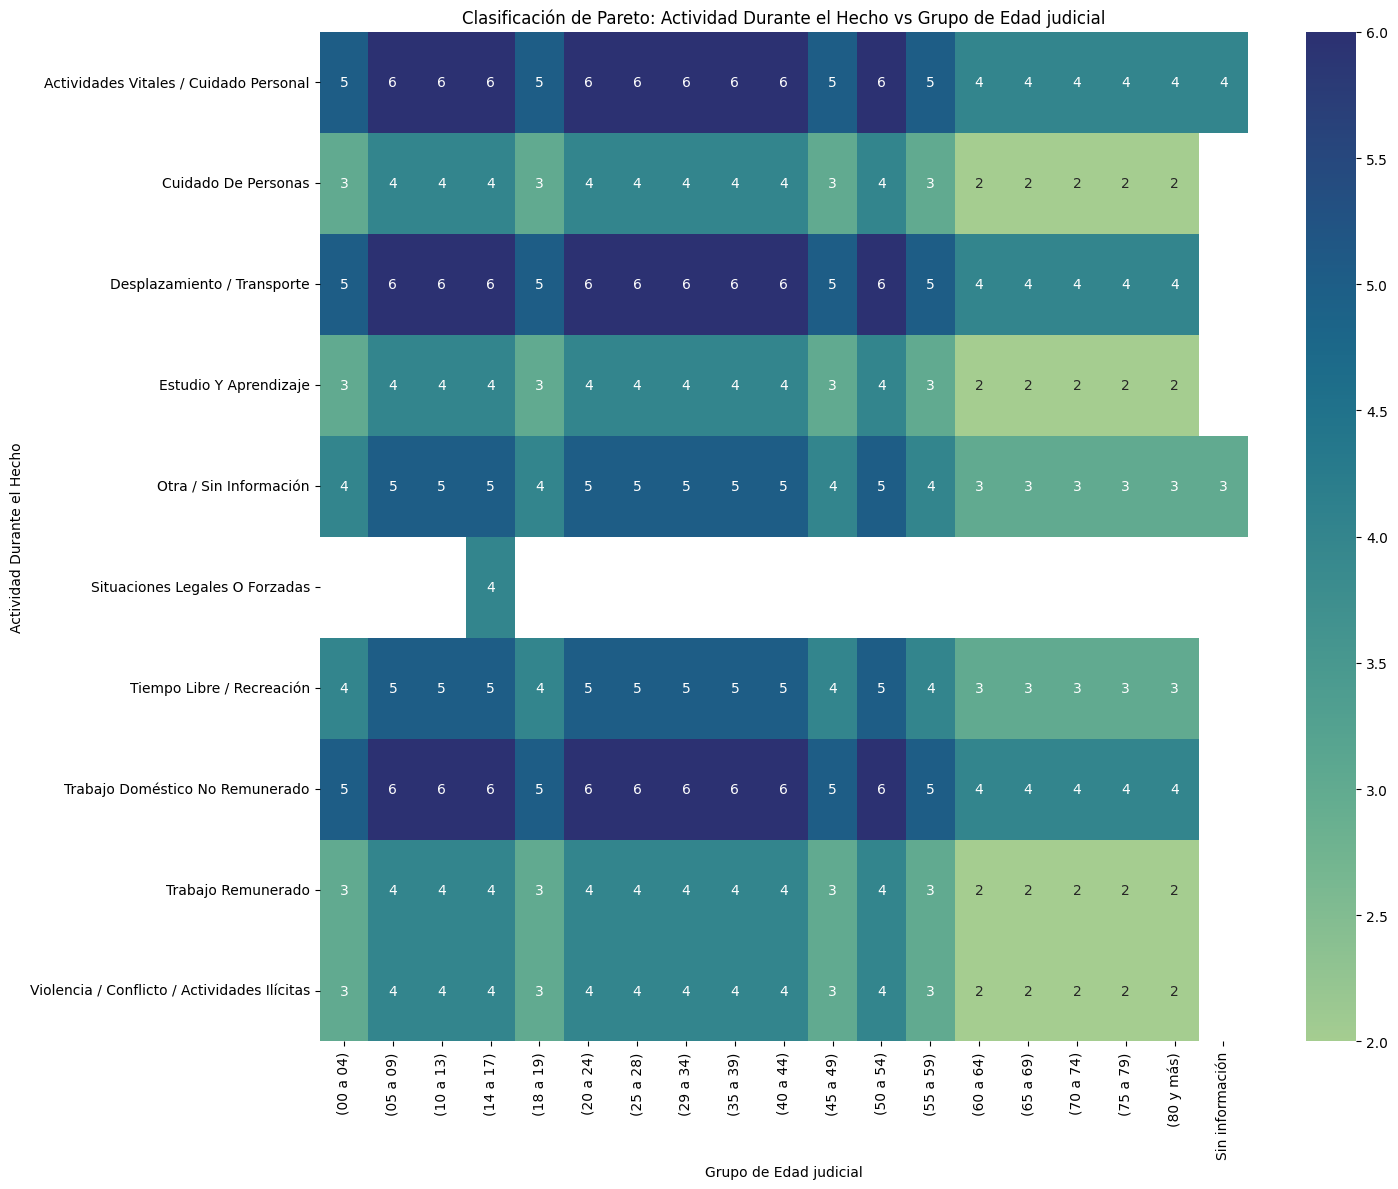

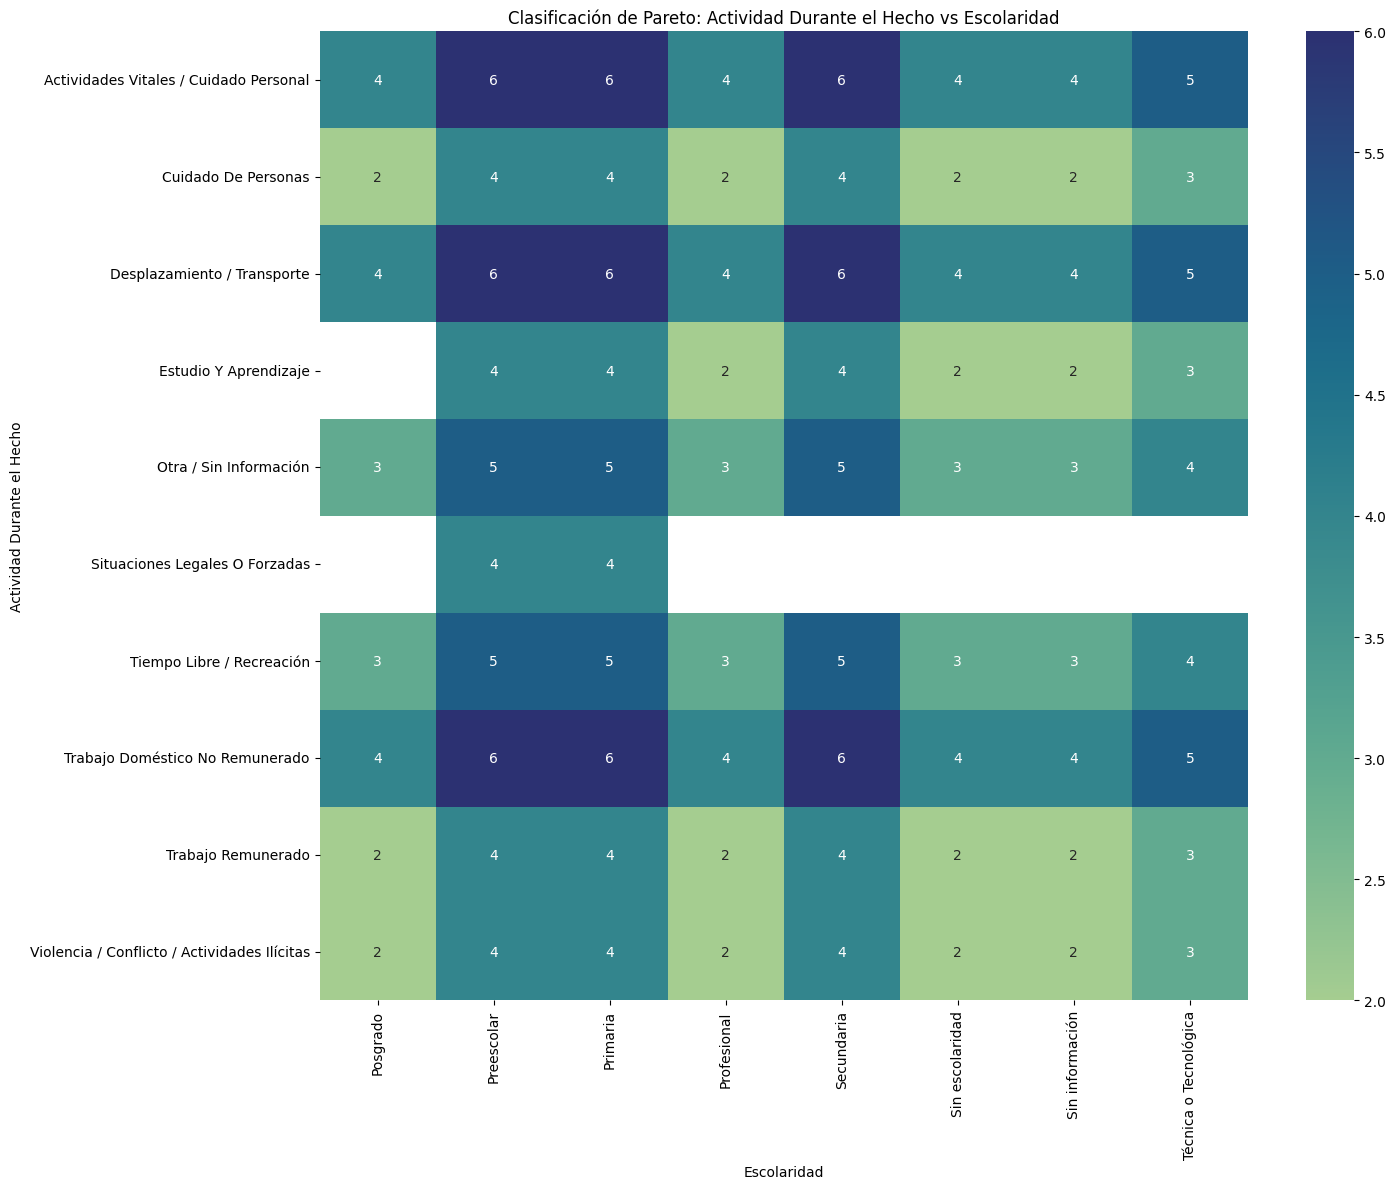

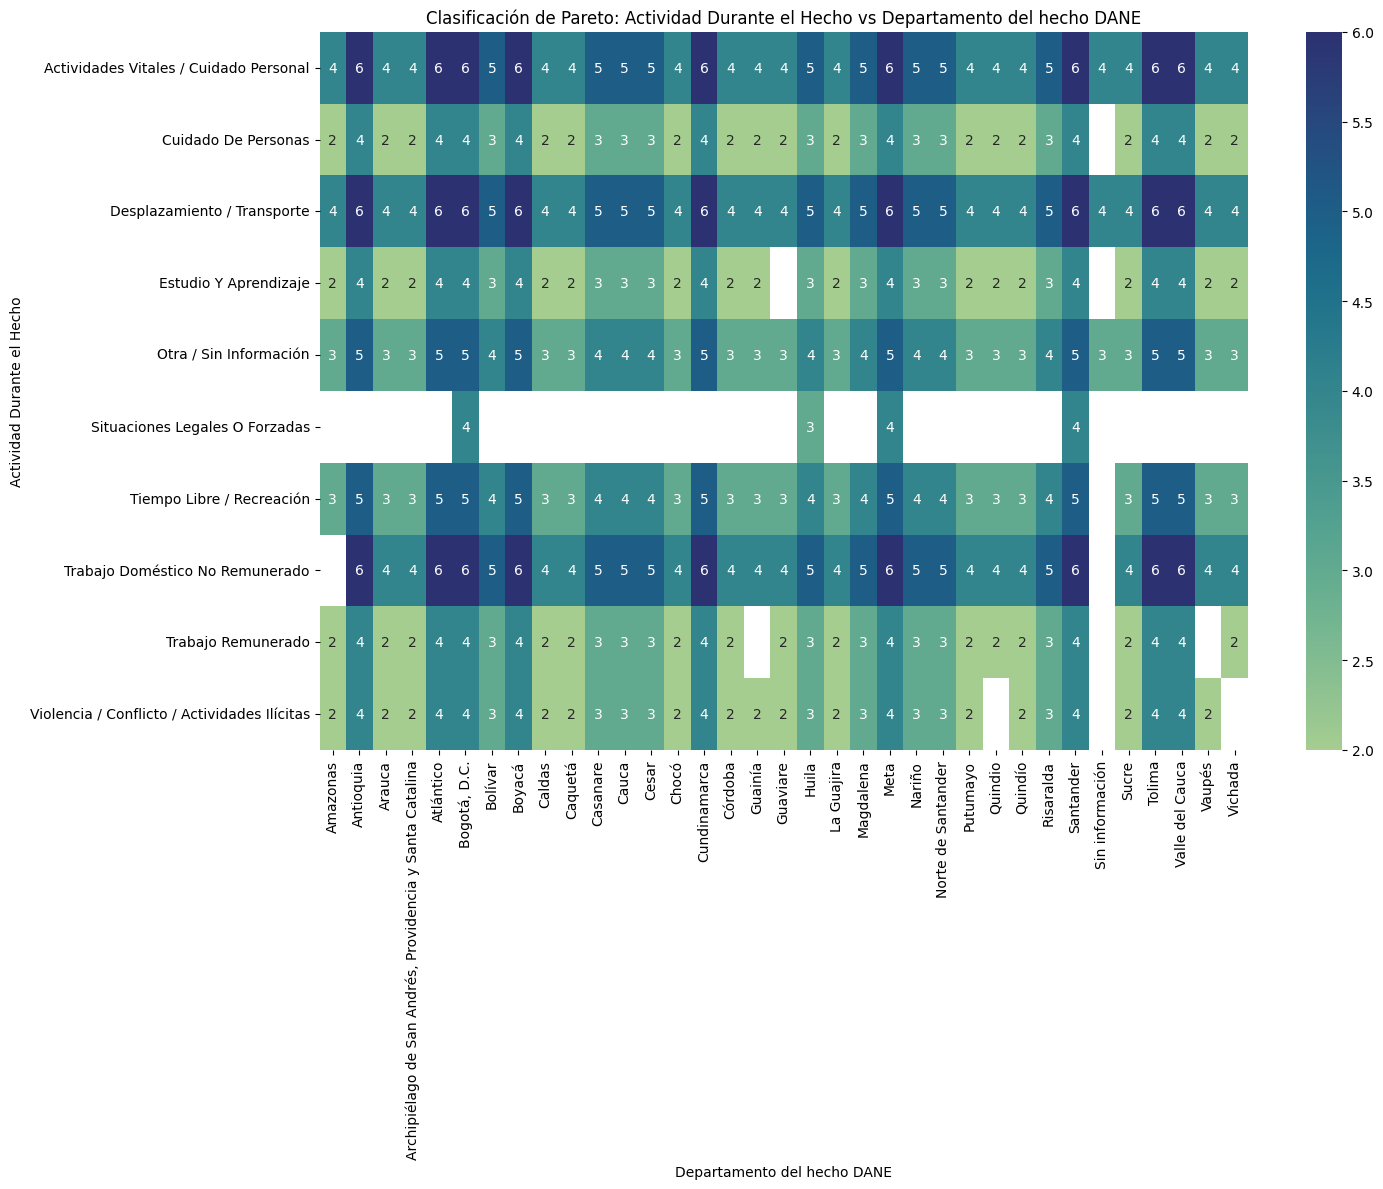

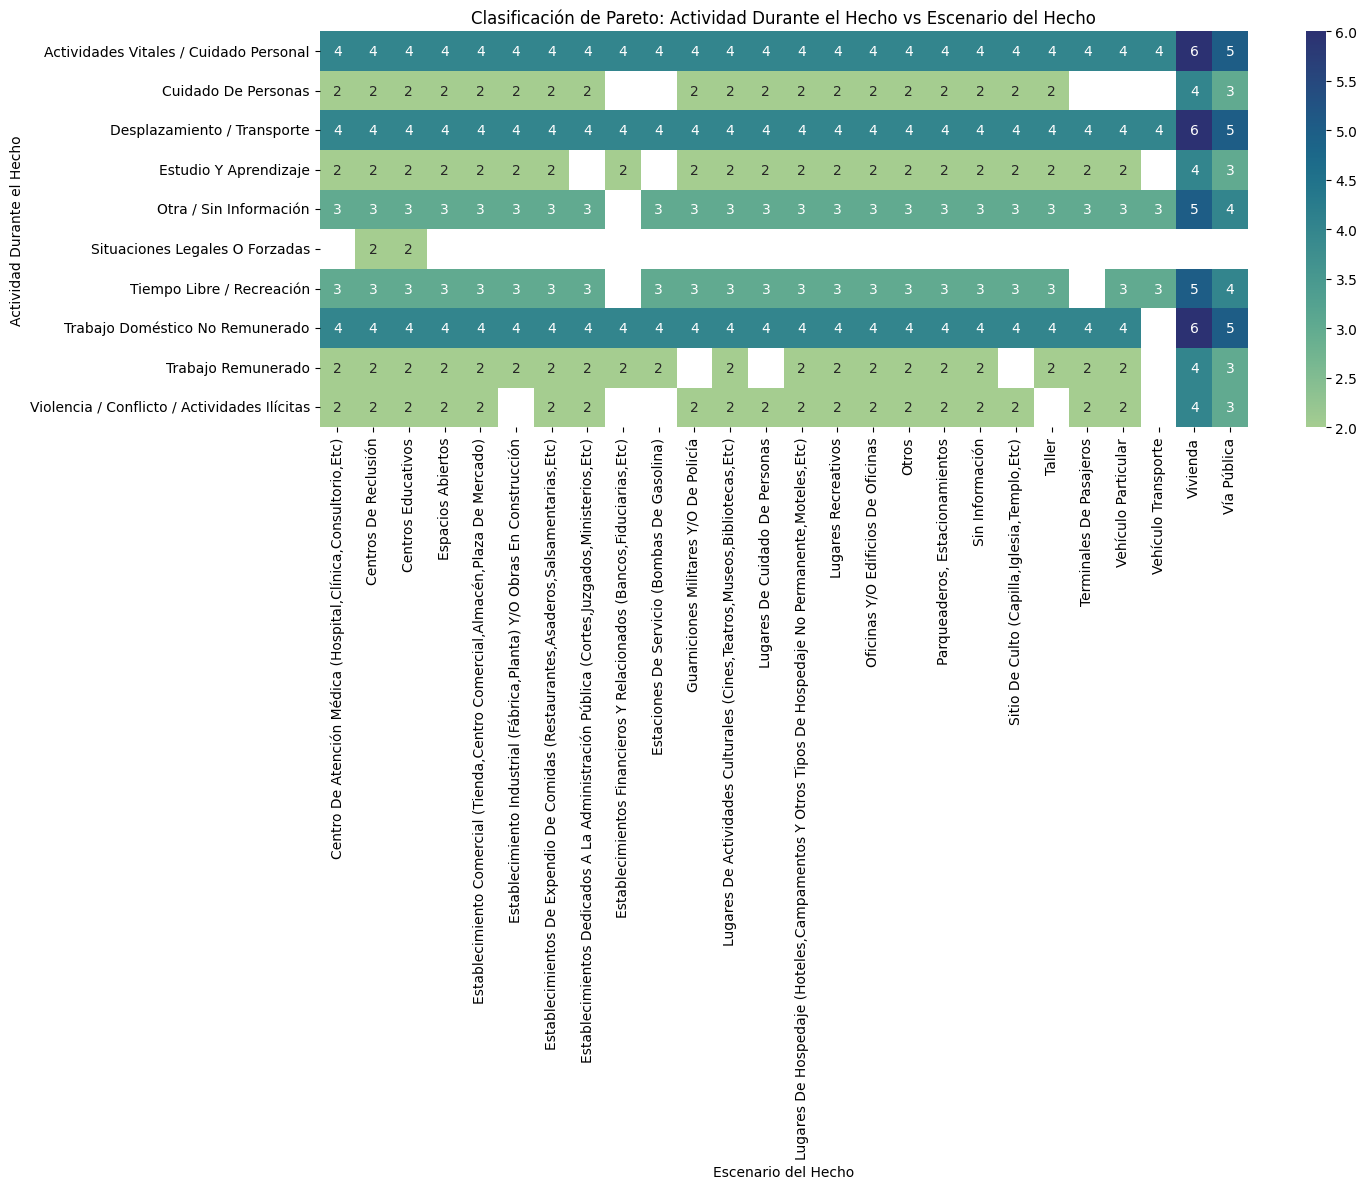

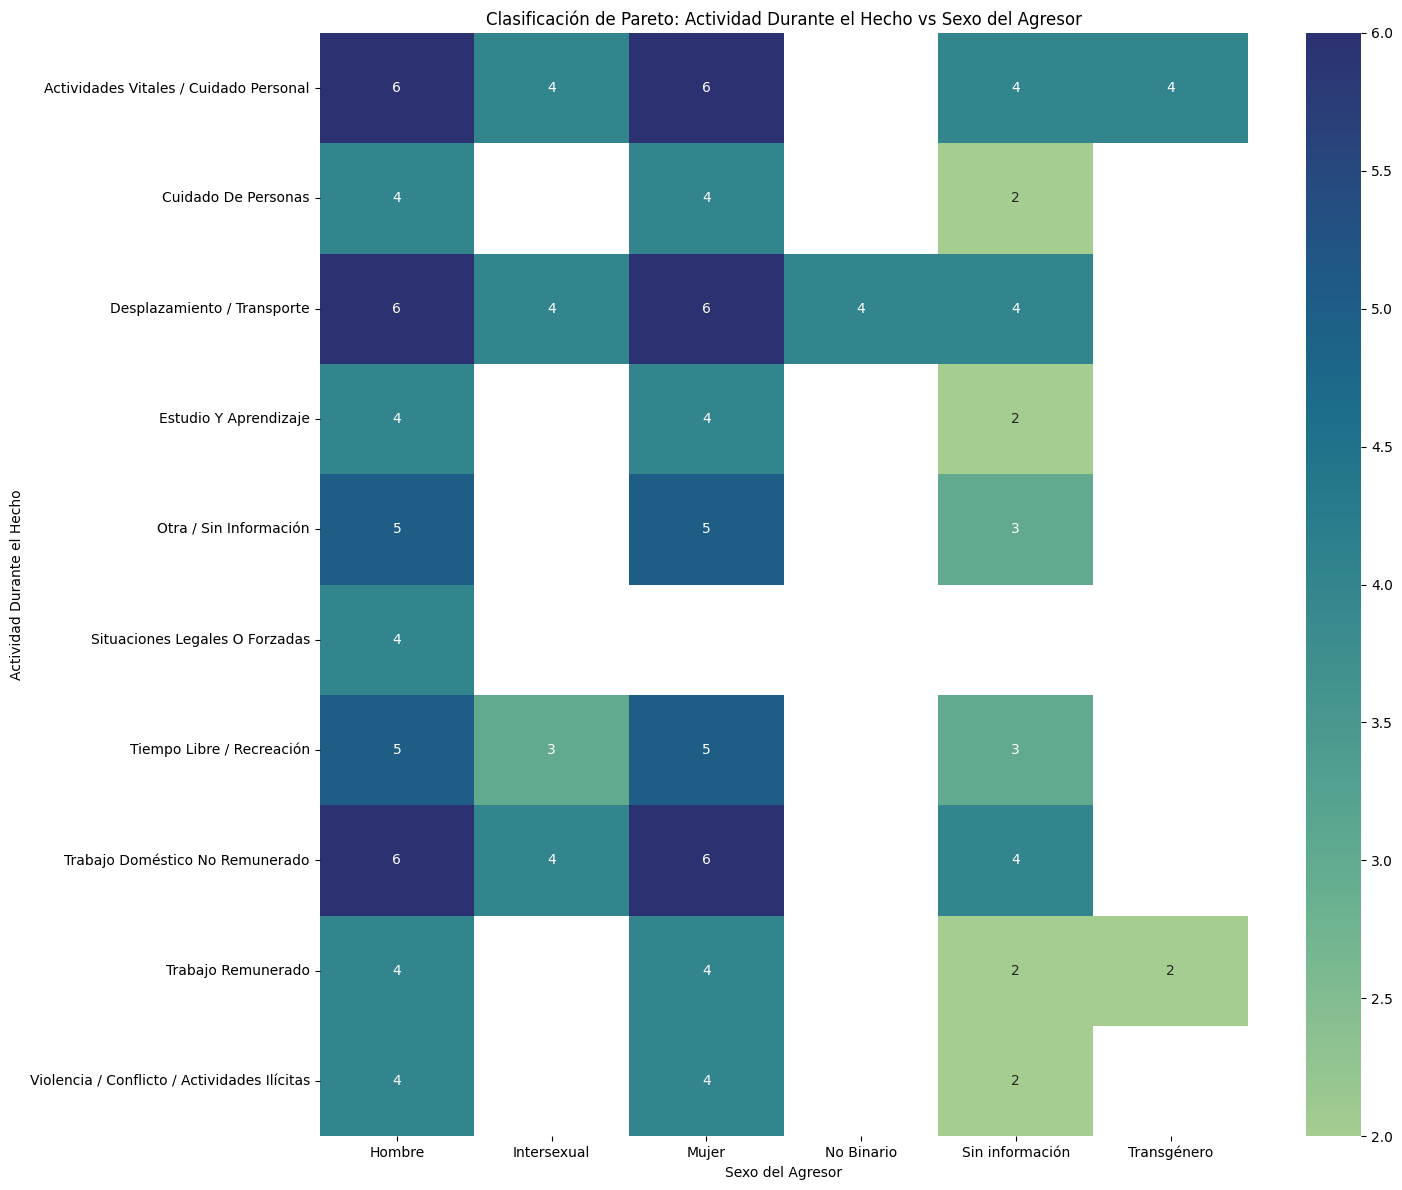

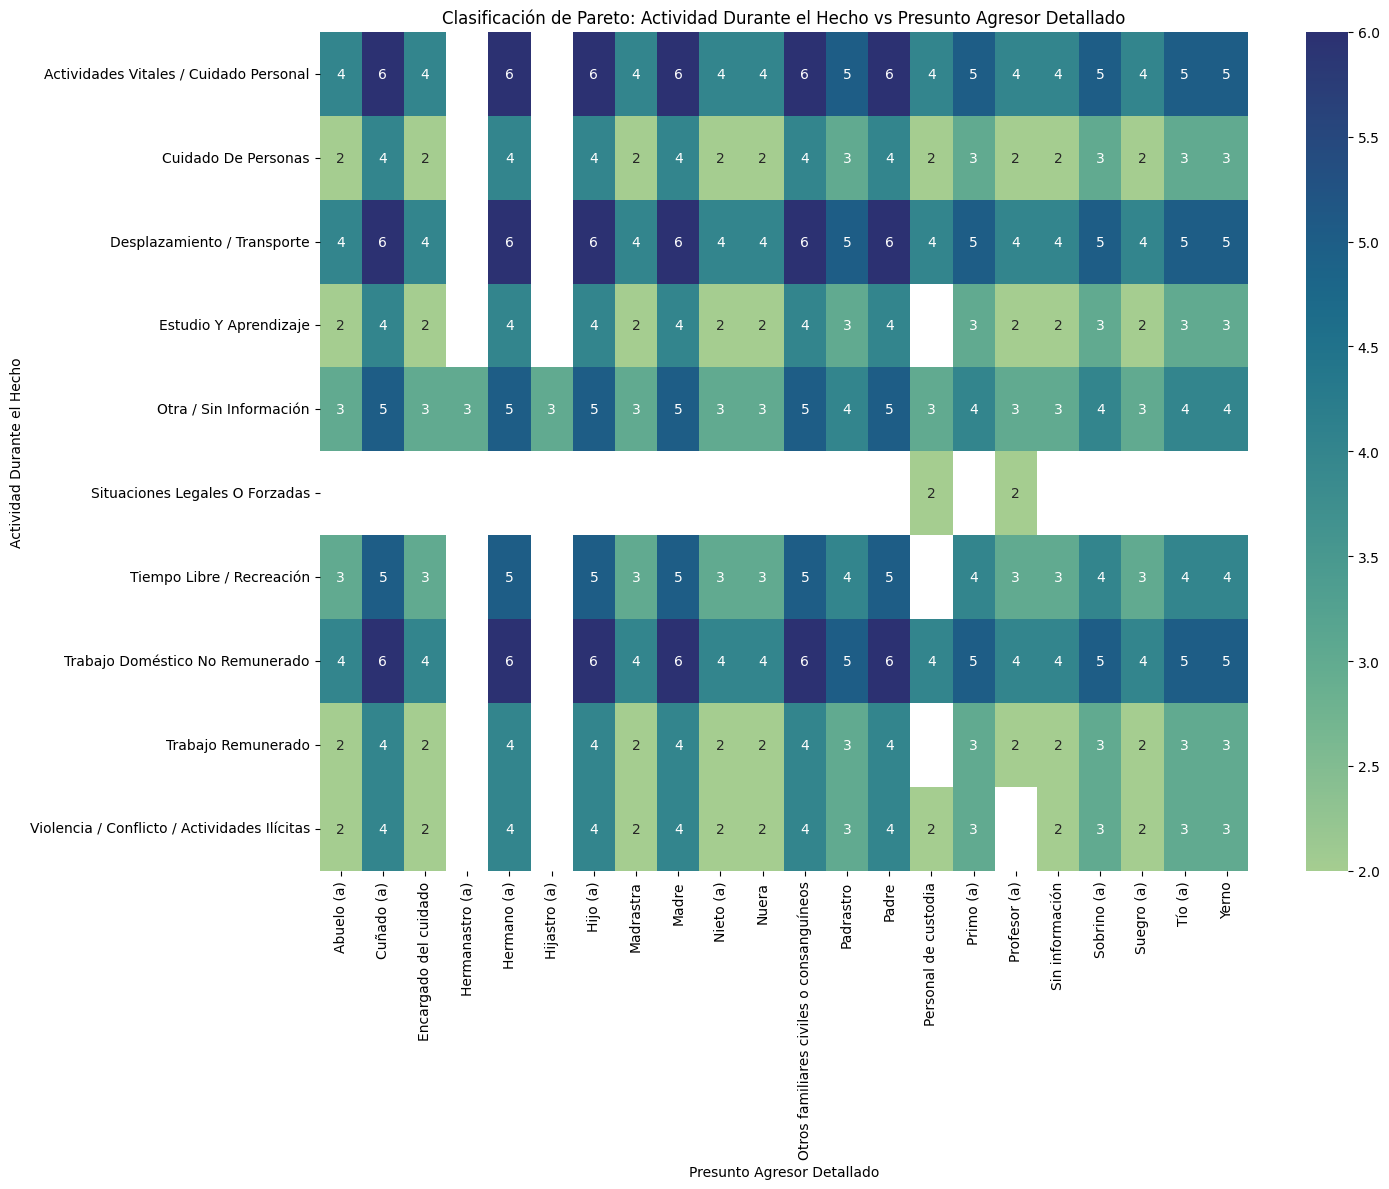

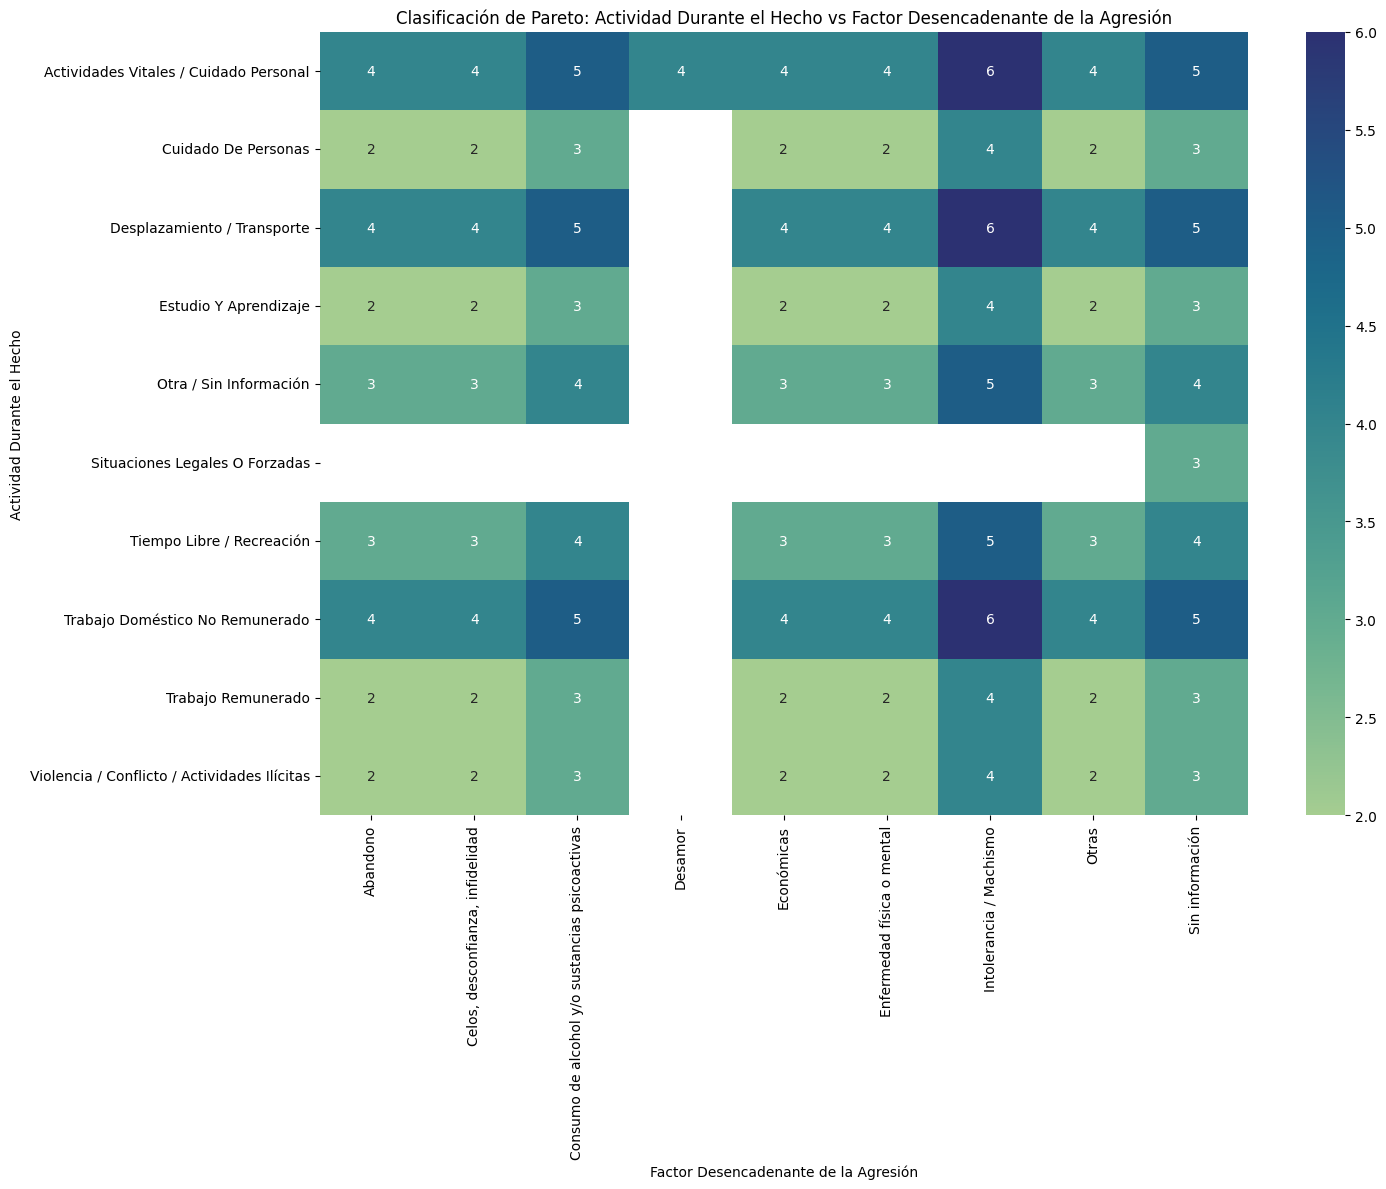

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Actividad Durante el Hecho"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(15, 12))

### Sexo del Agresor

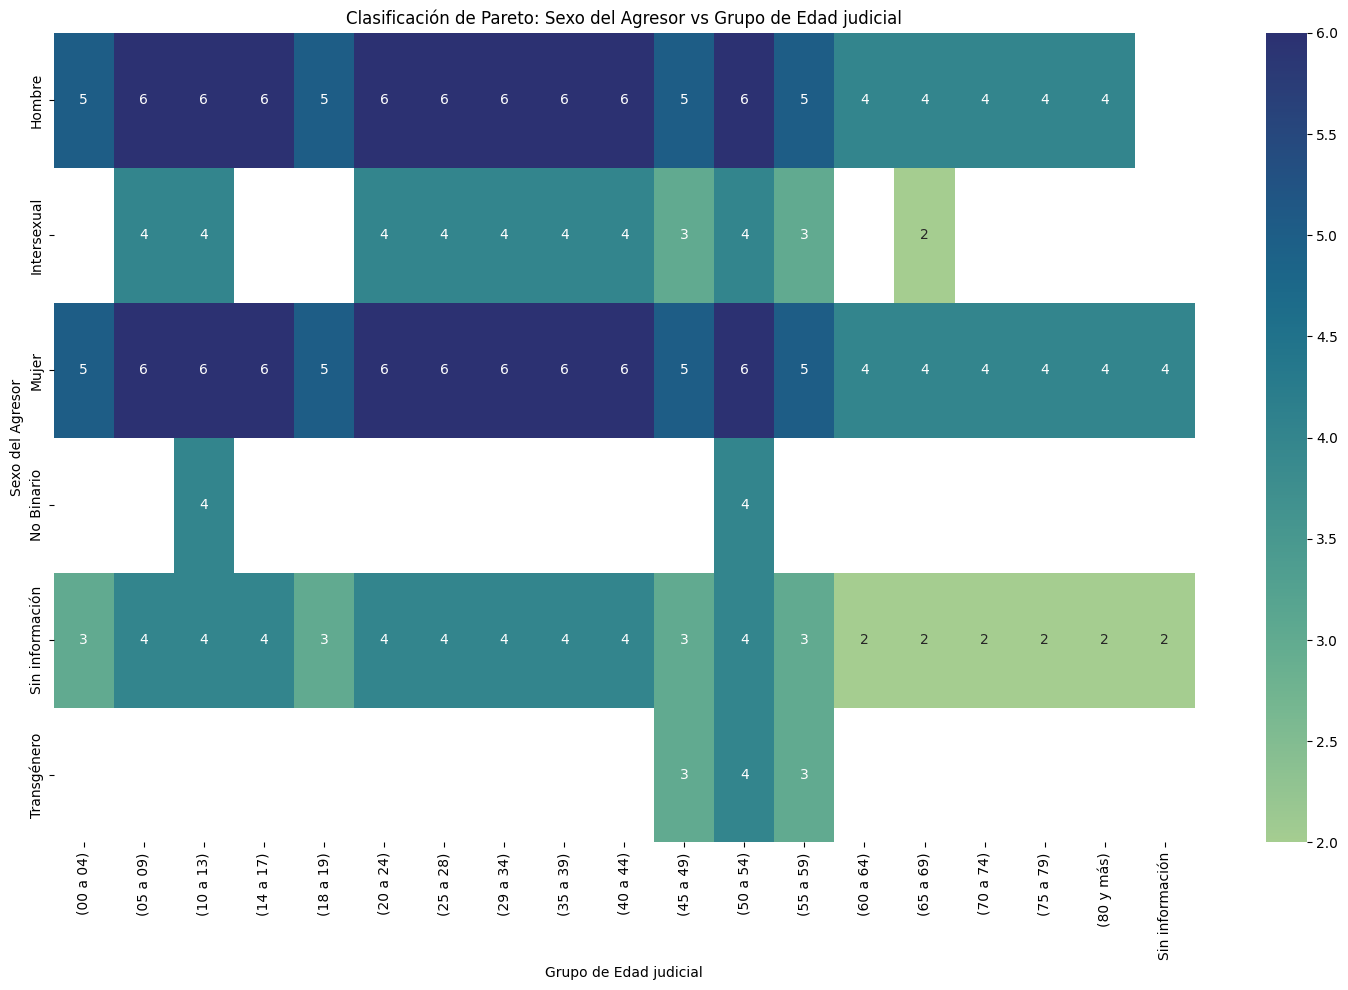

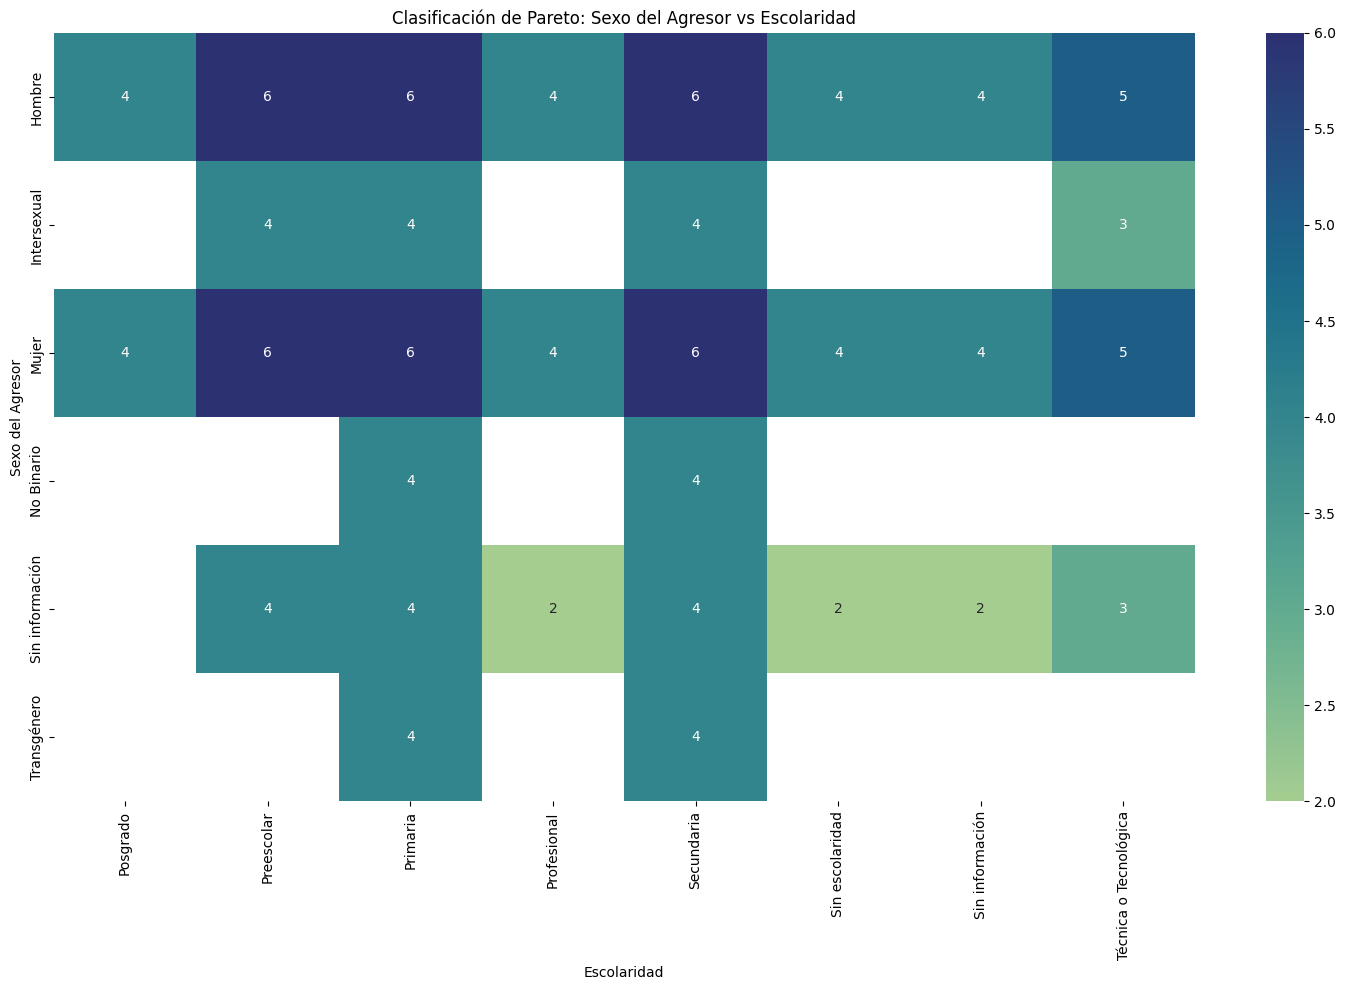

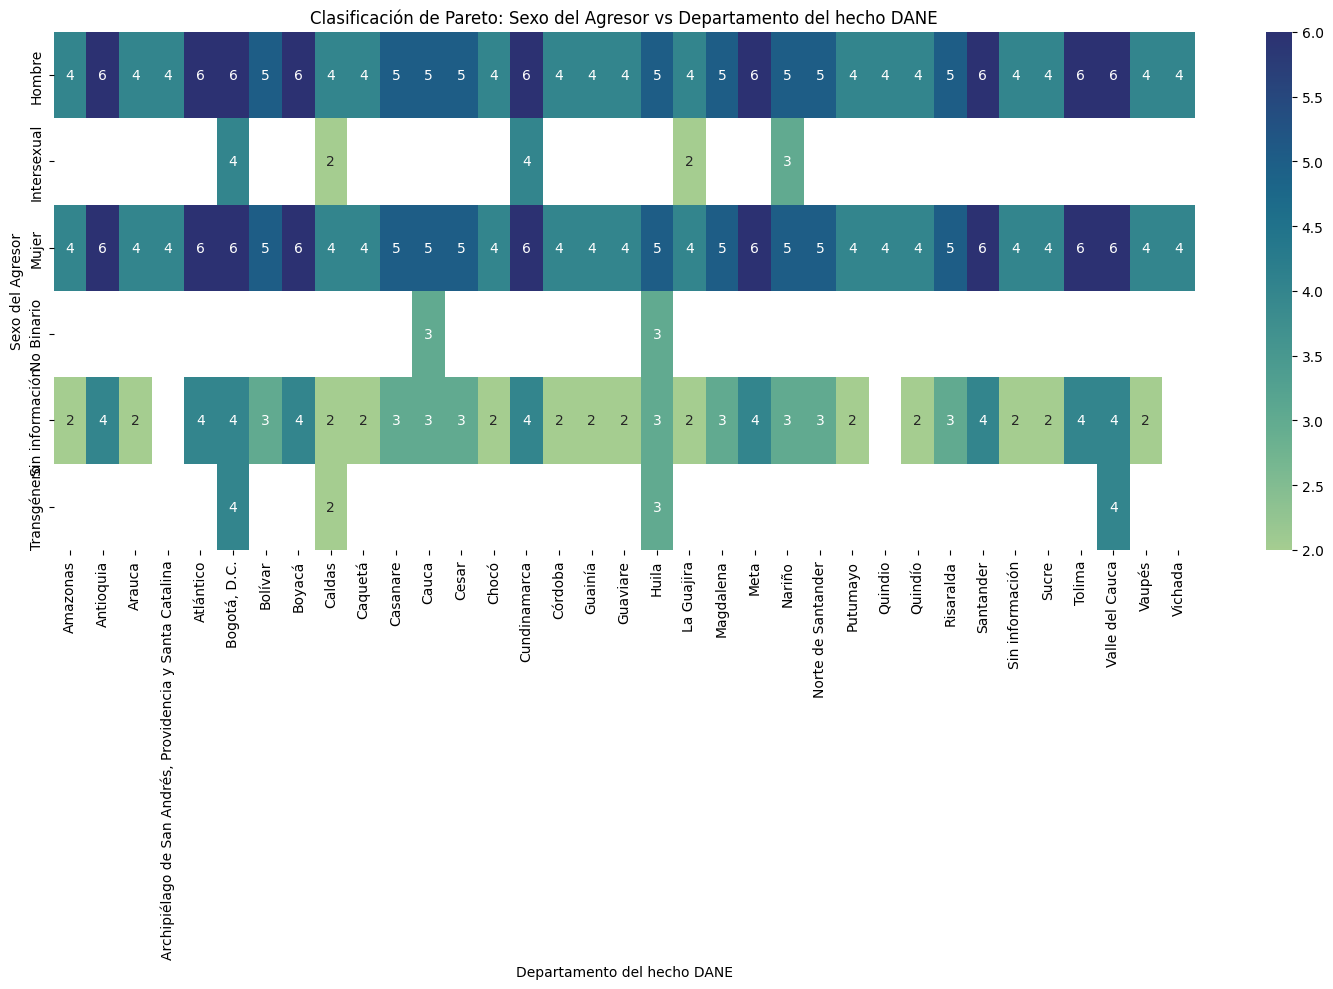

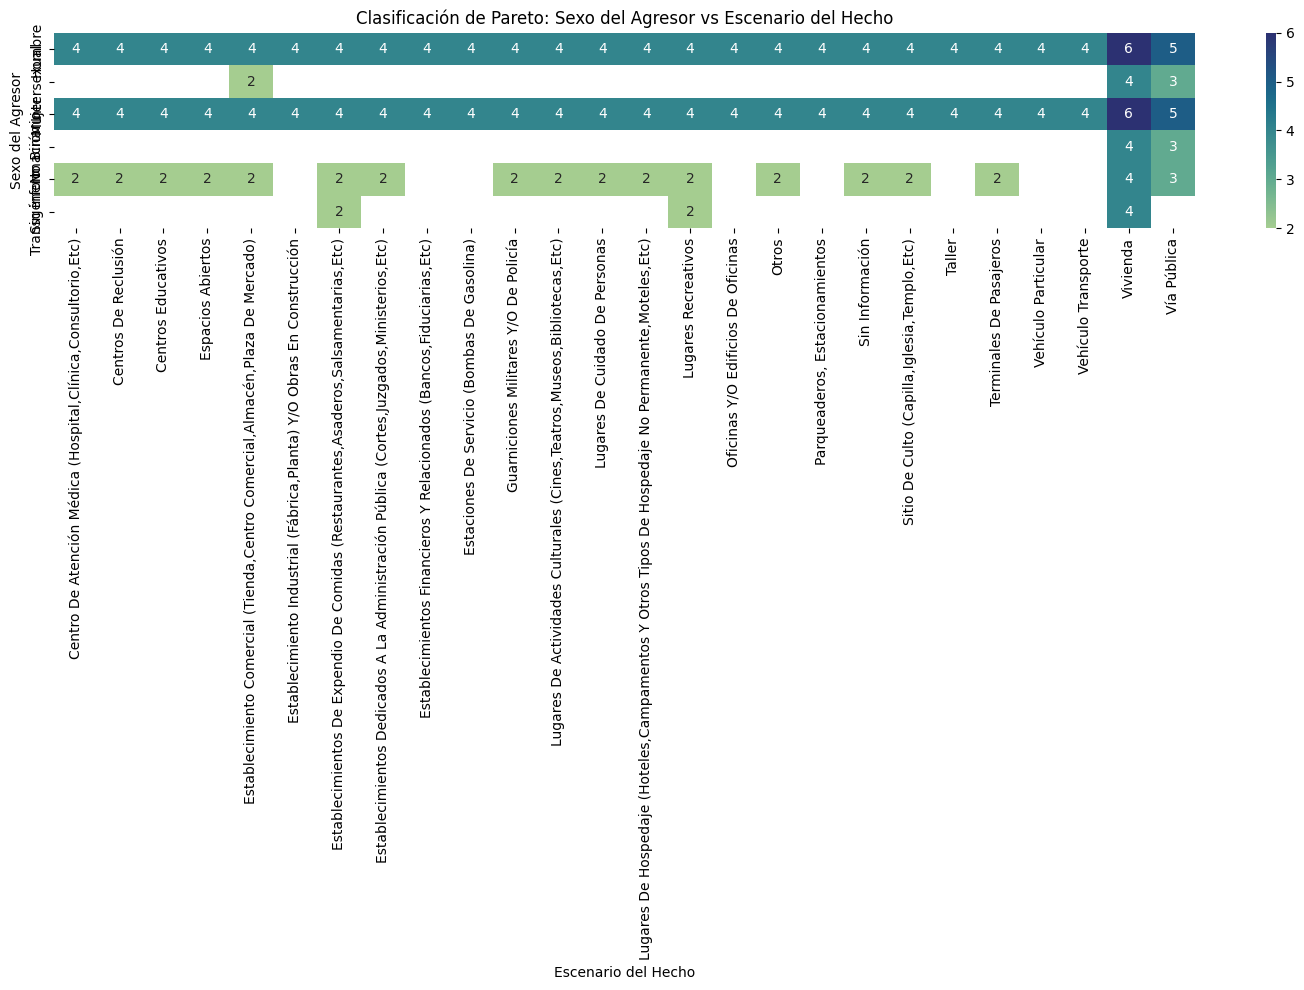

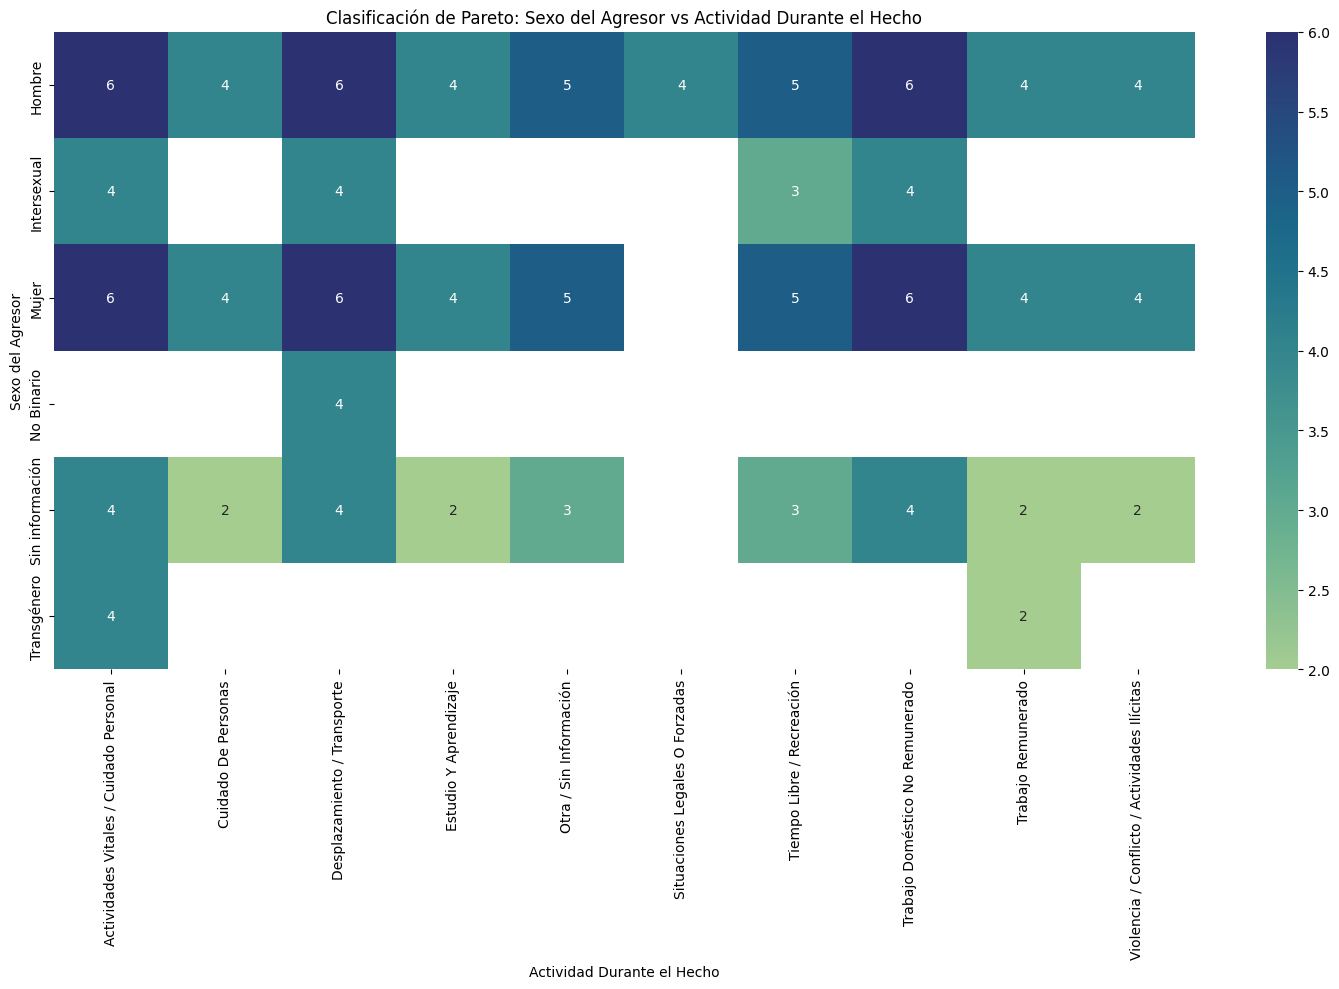

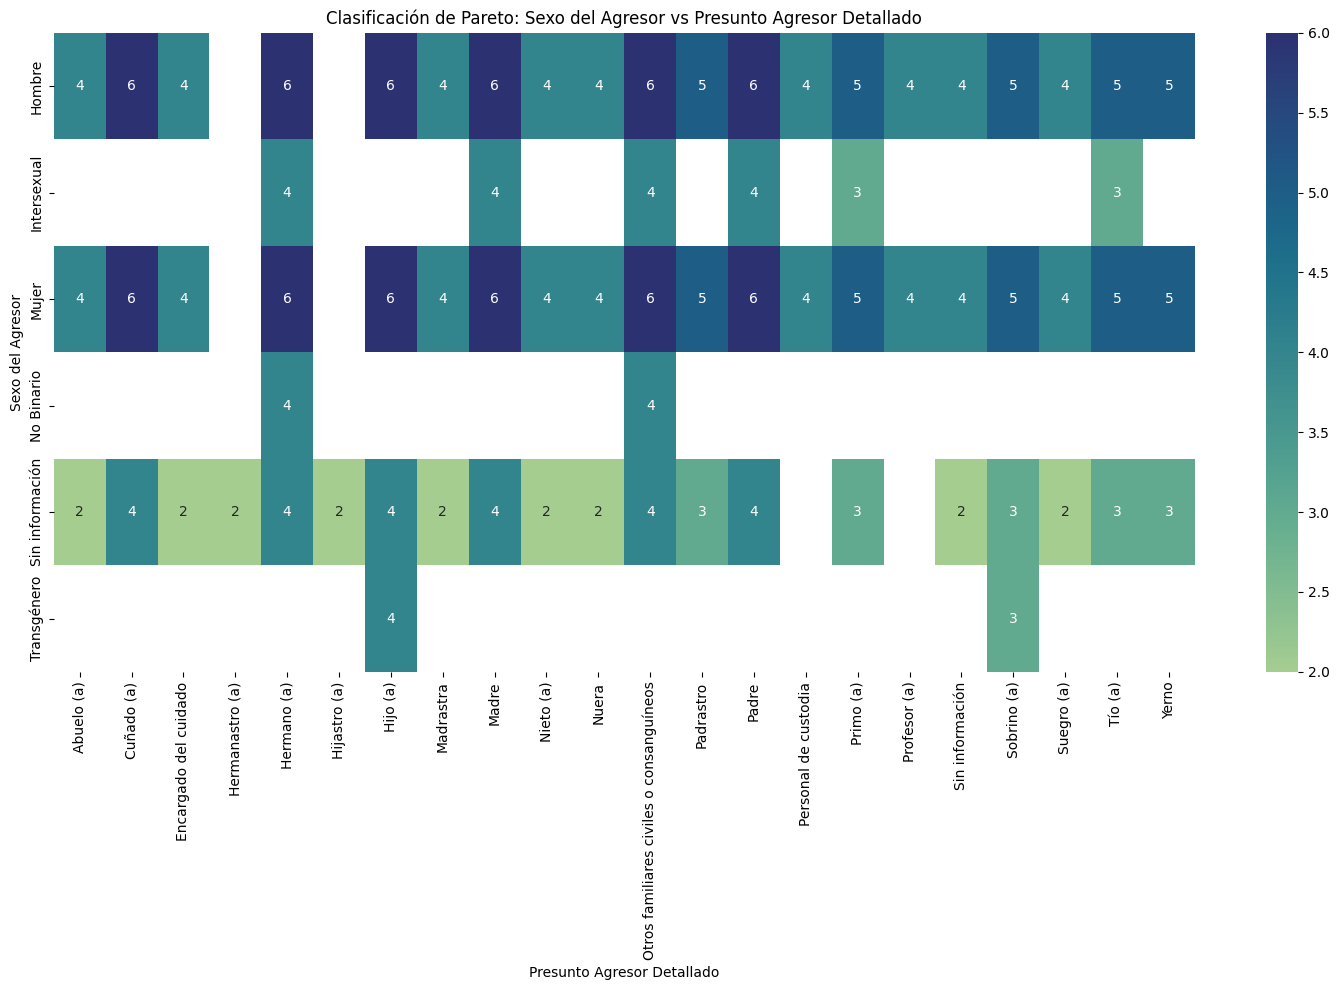

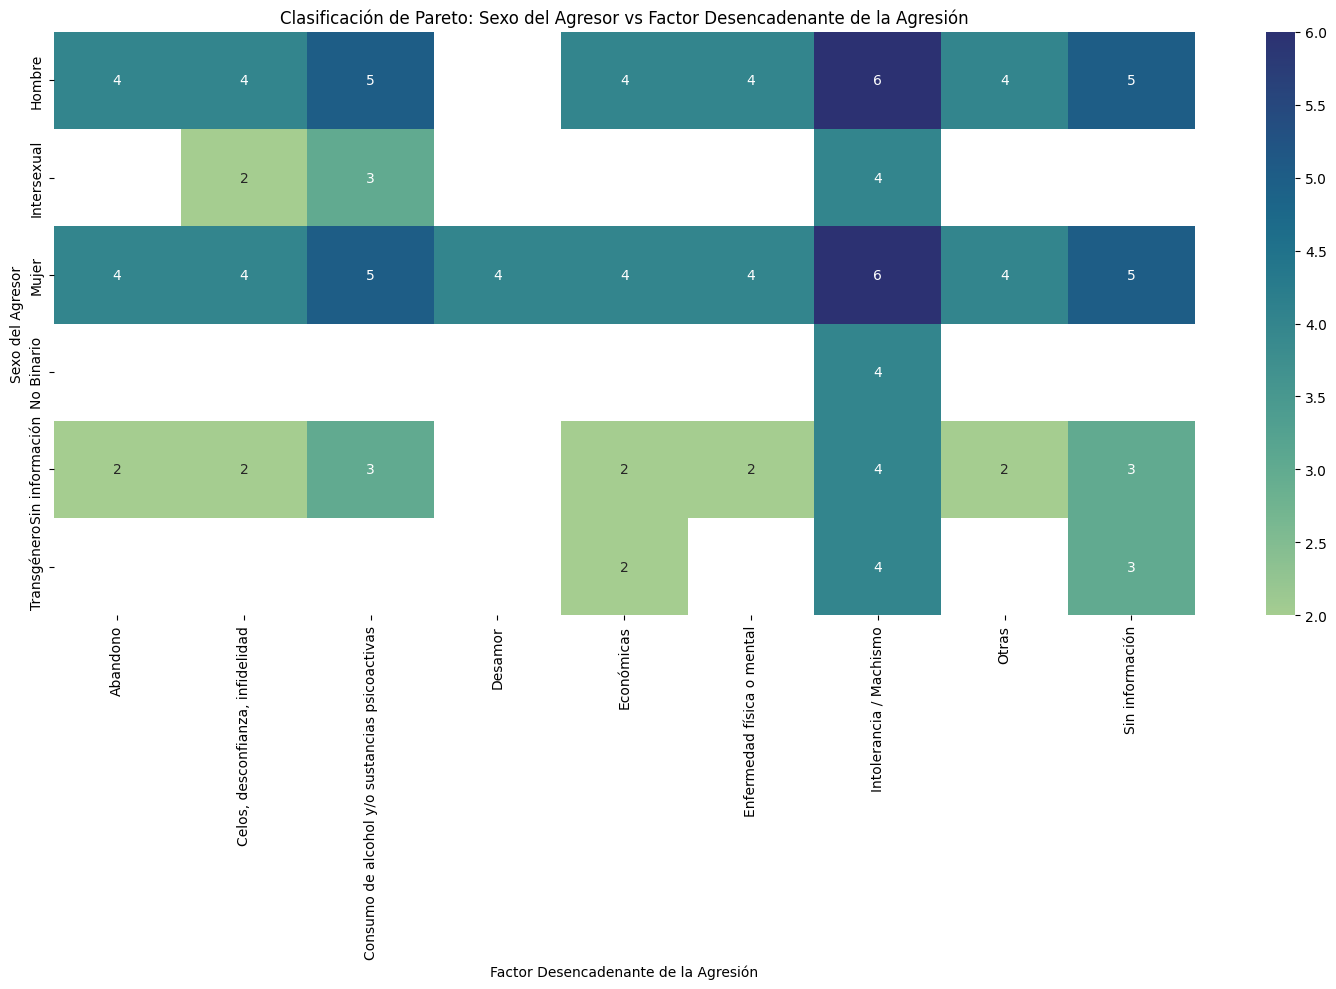

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Sexo del Agresor"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(15, 10))

### Presunto Agresor Detallado

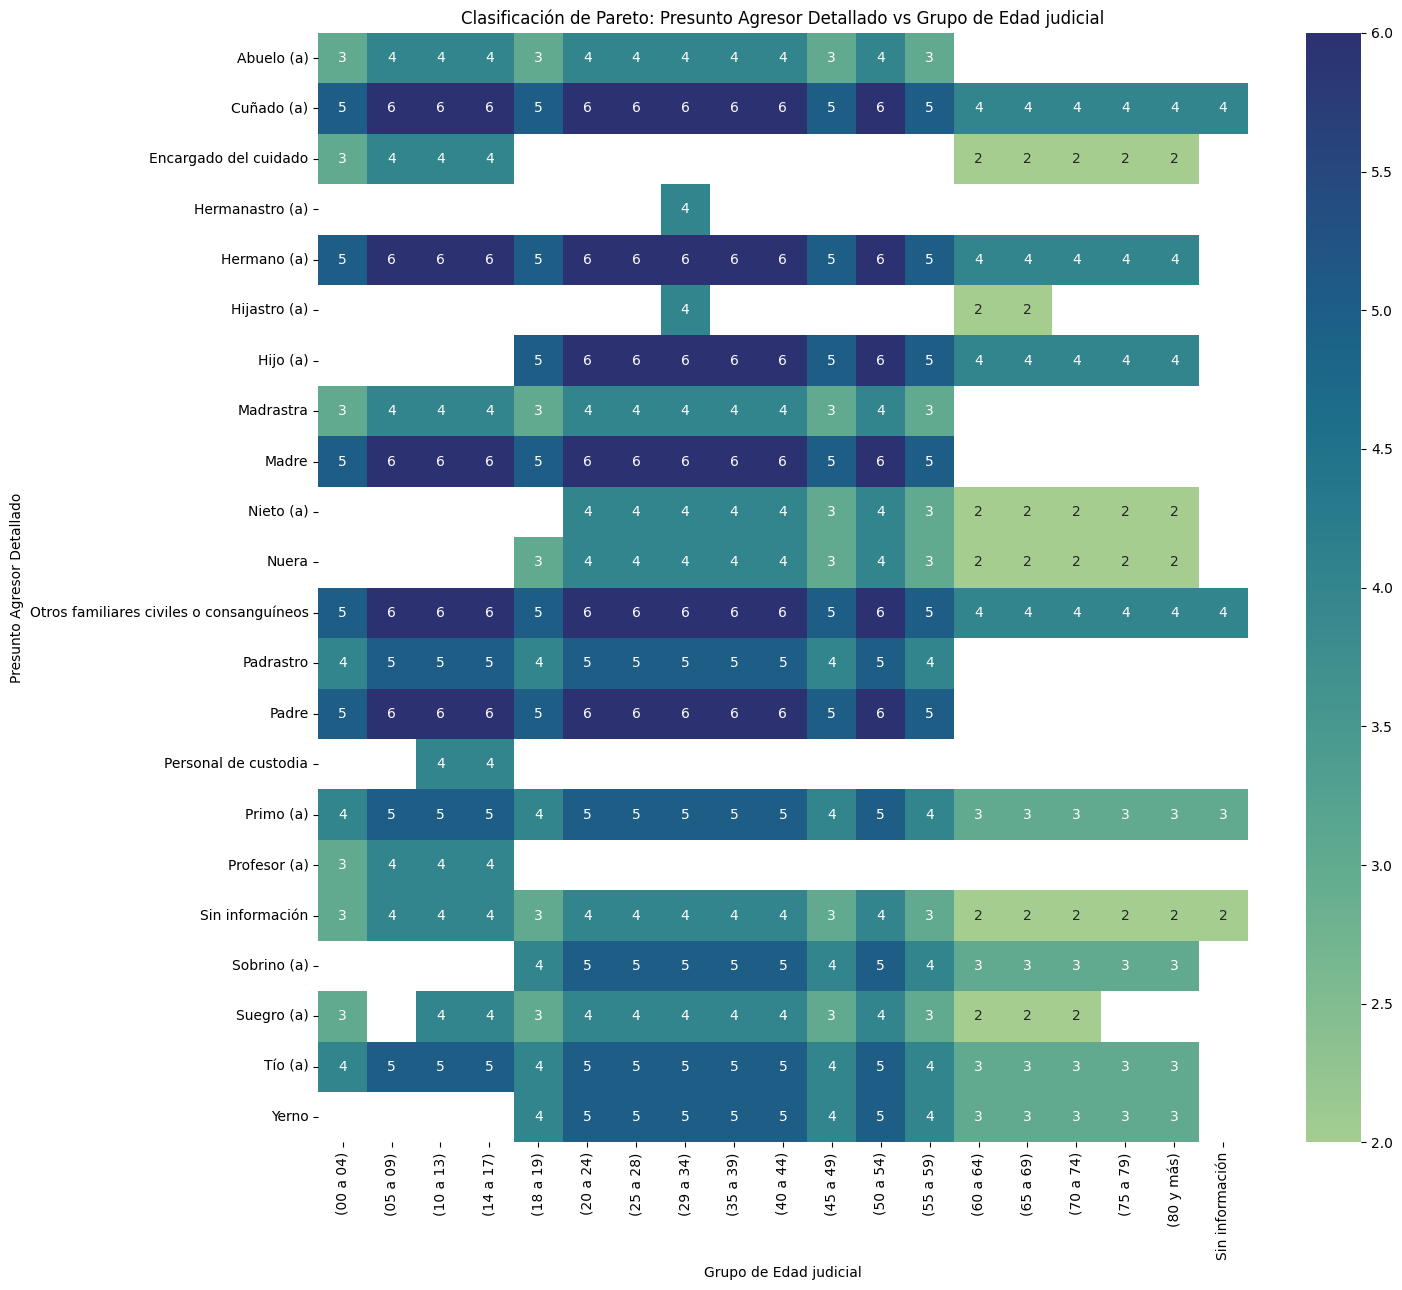

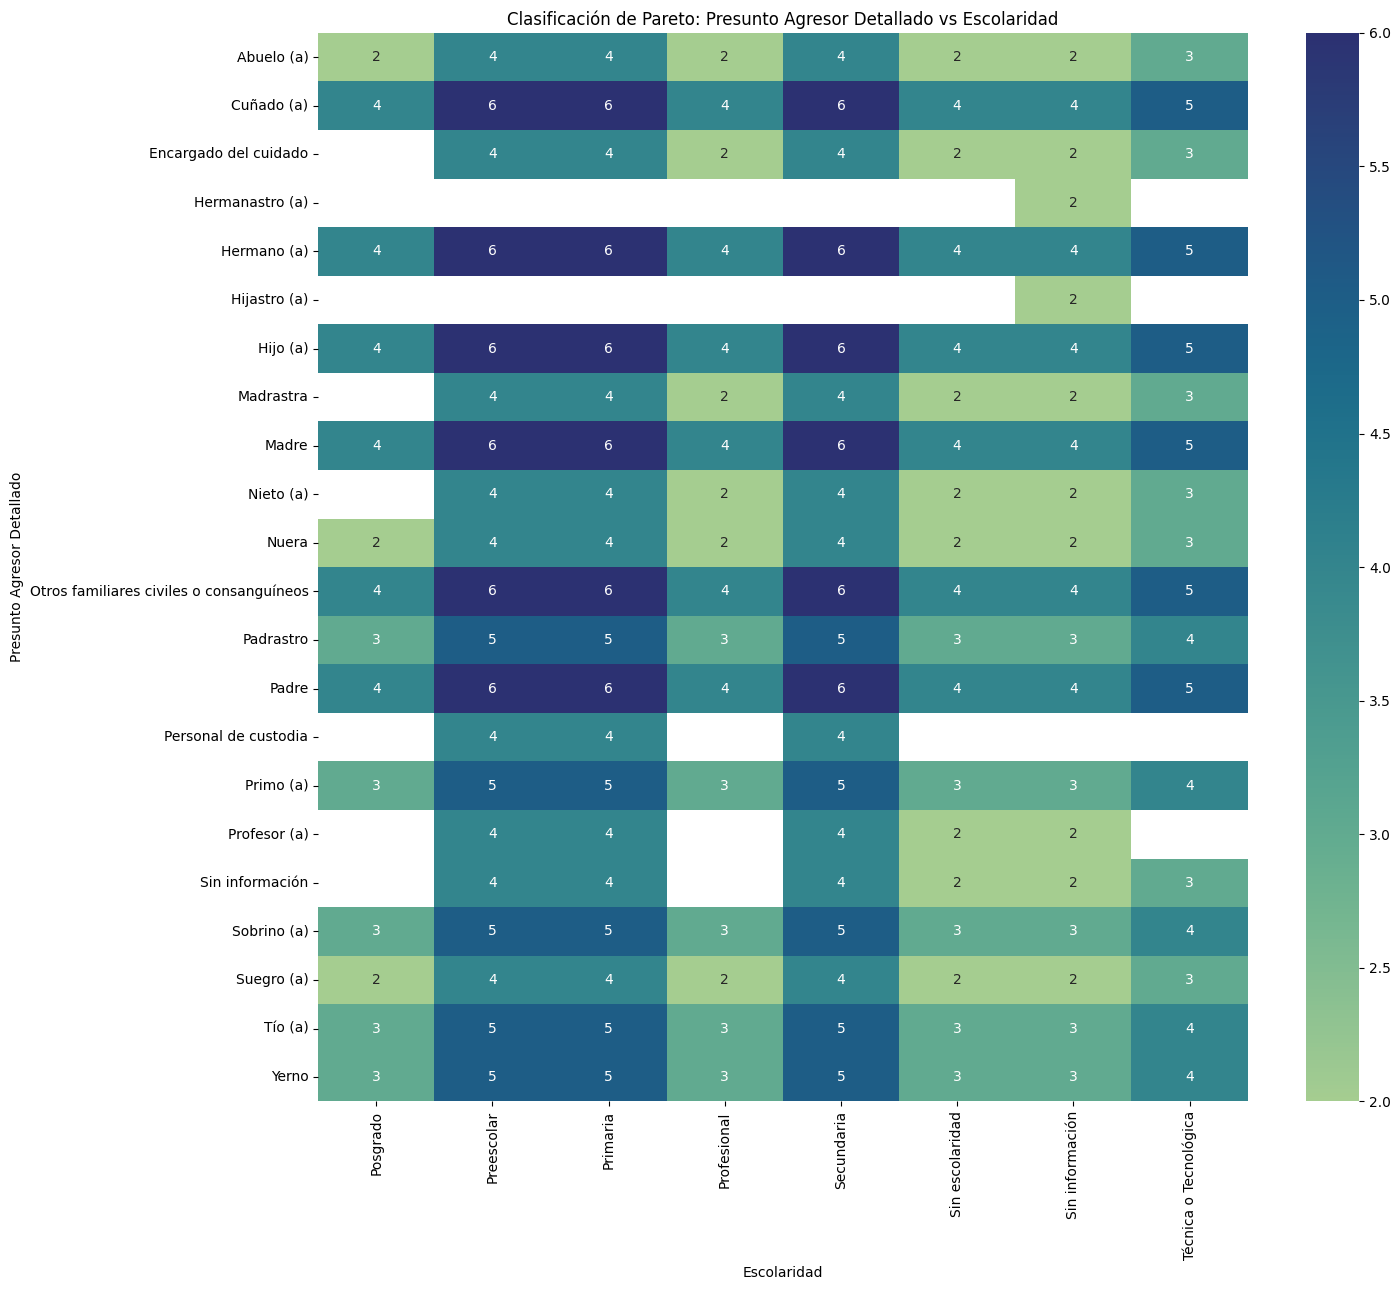

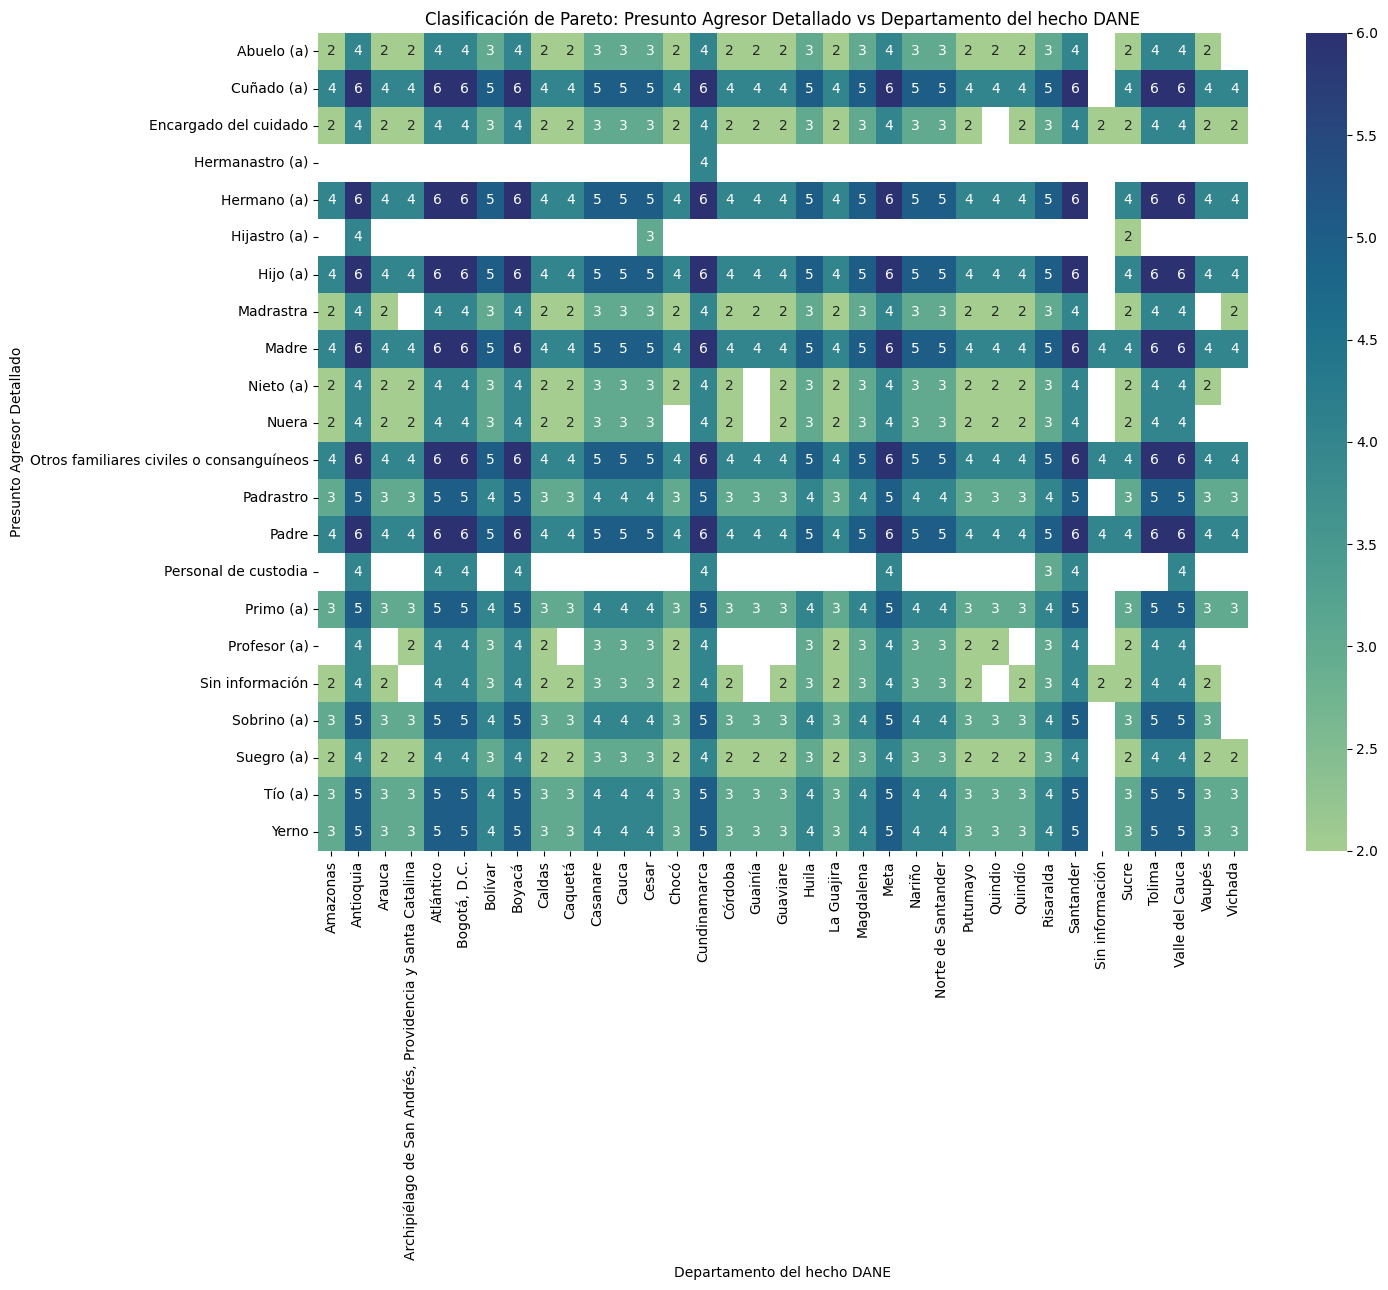

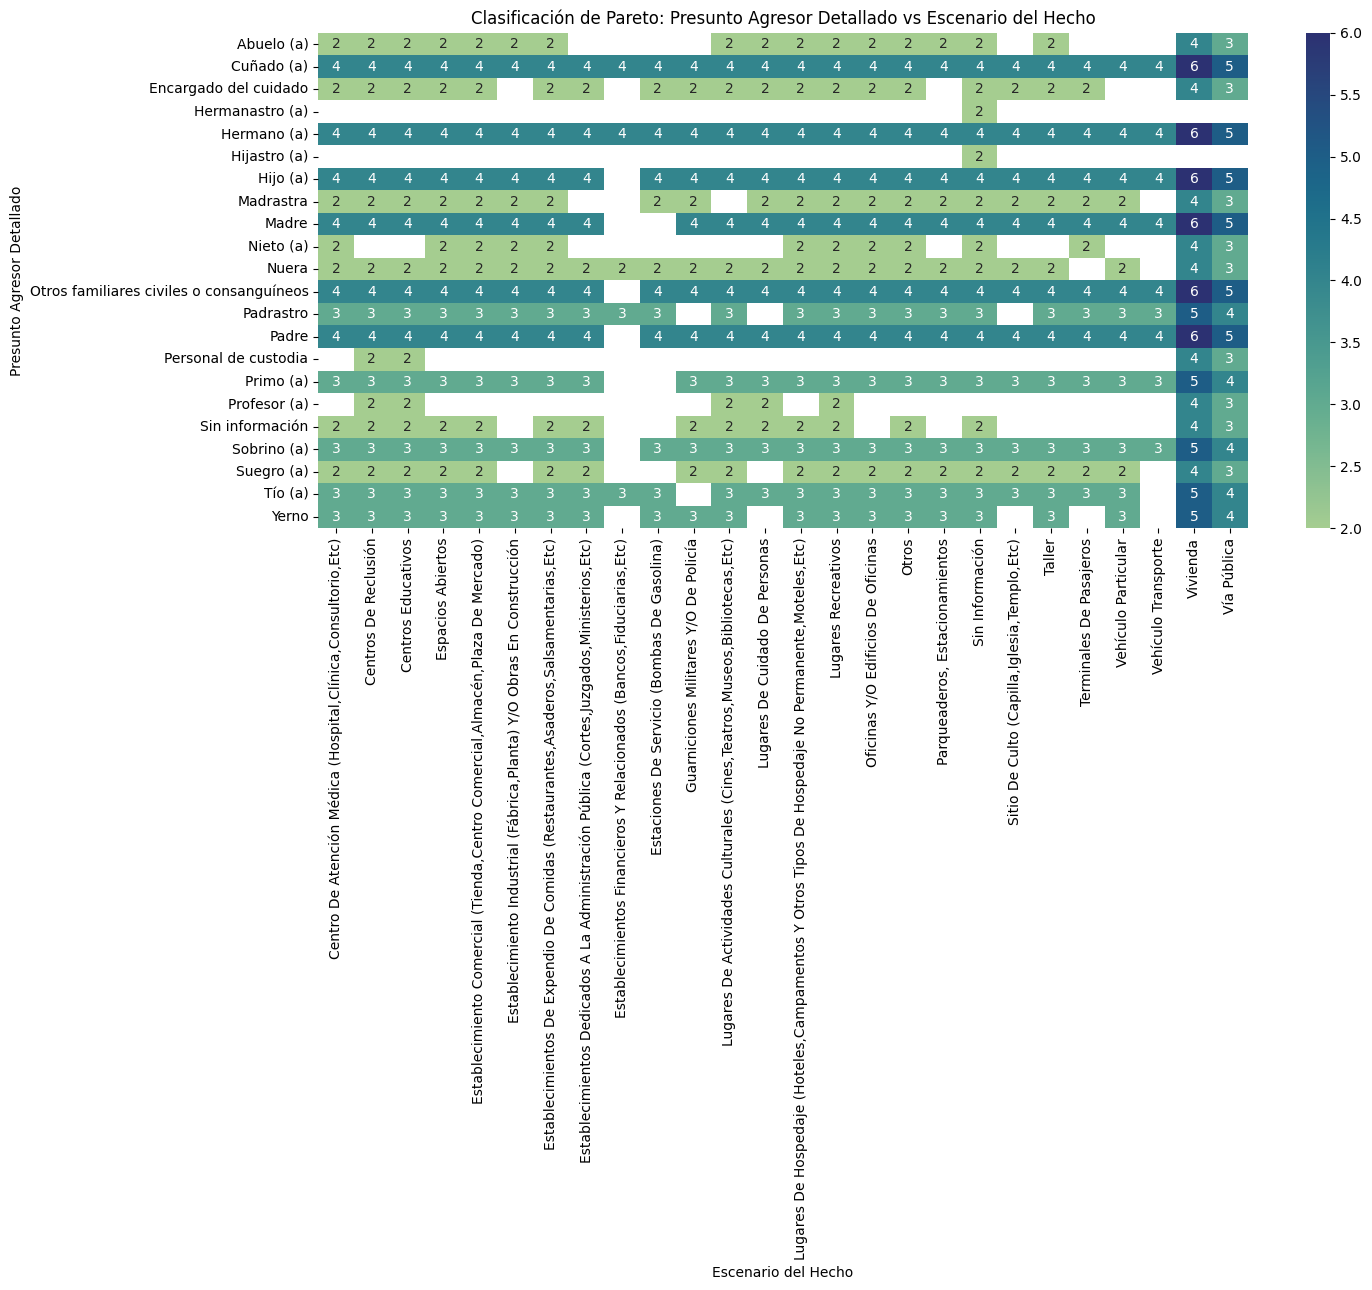

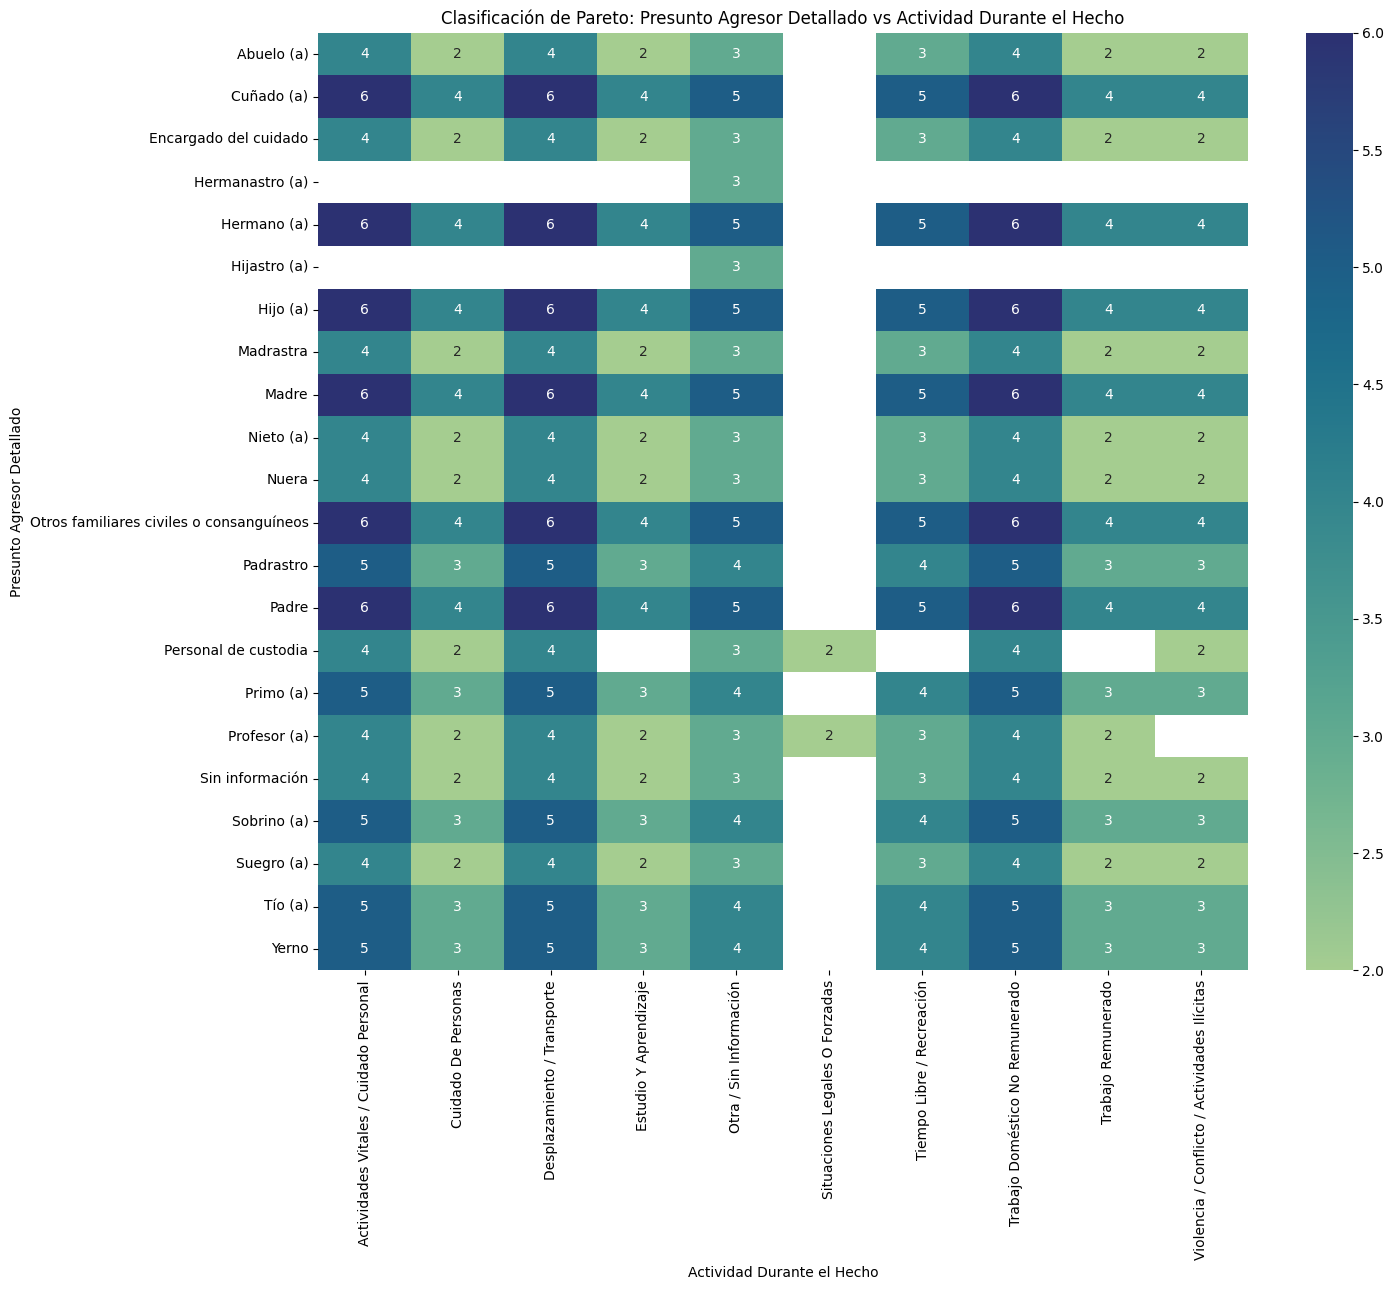

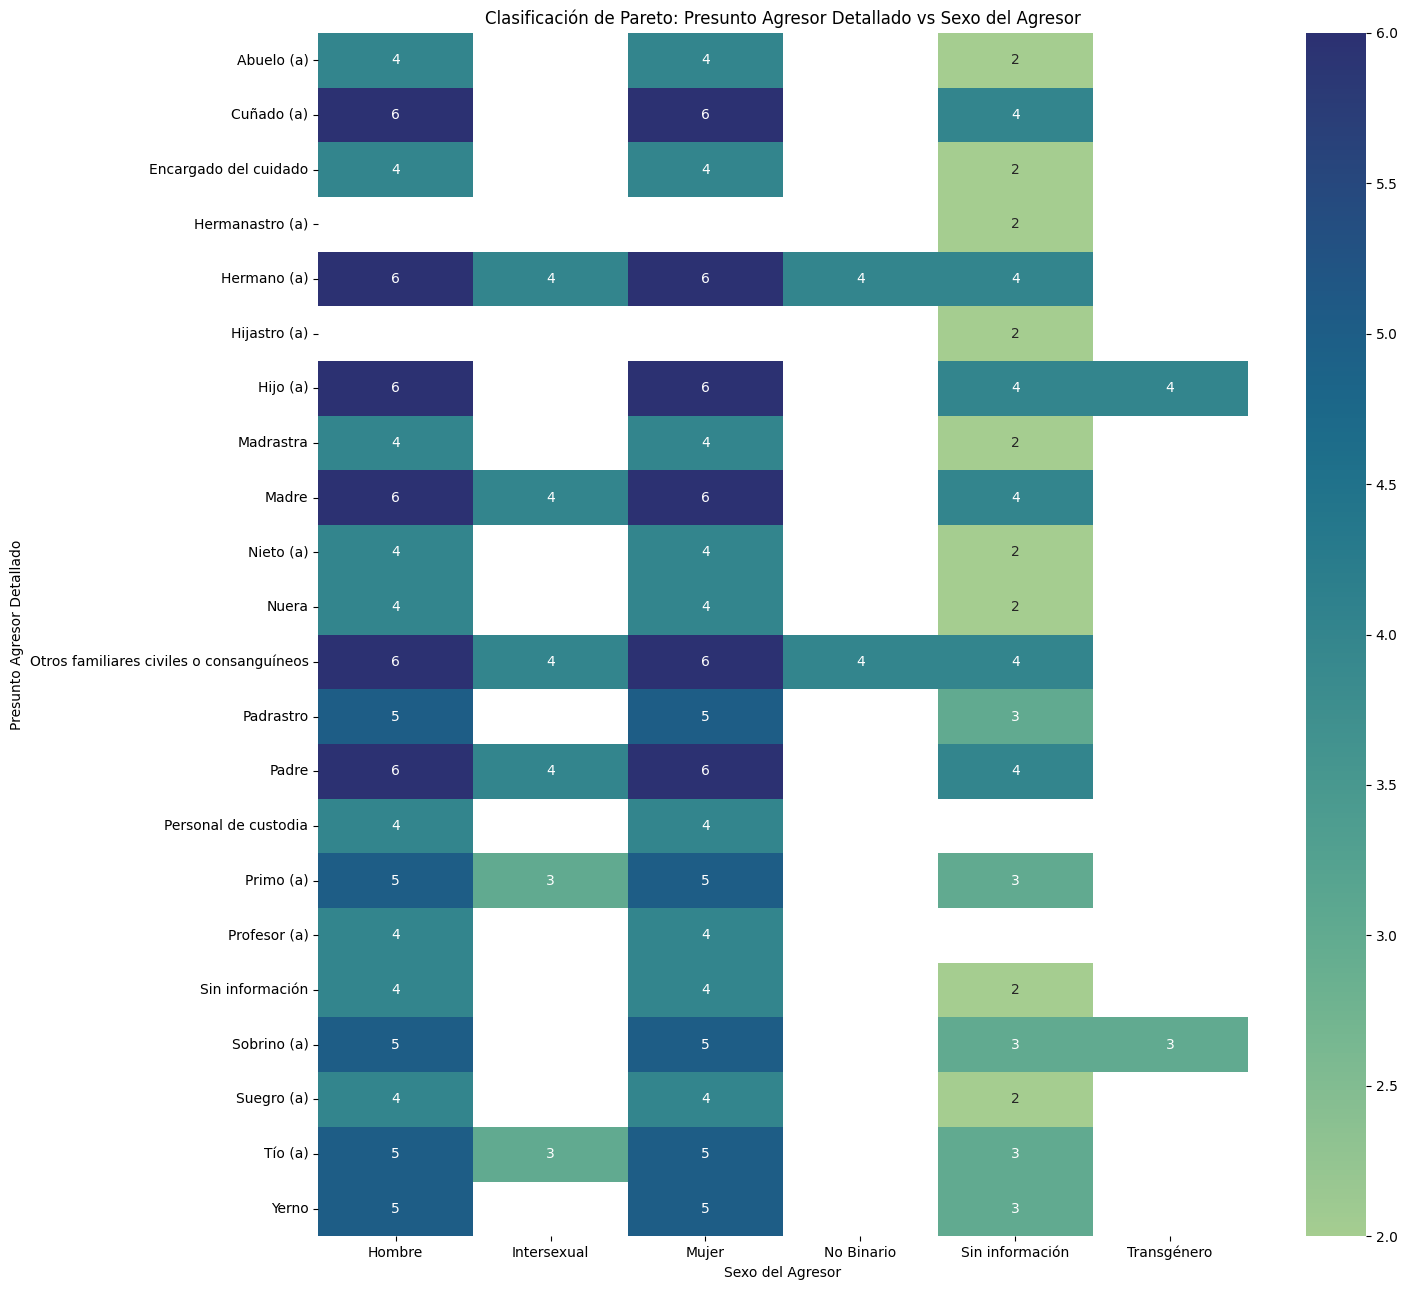

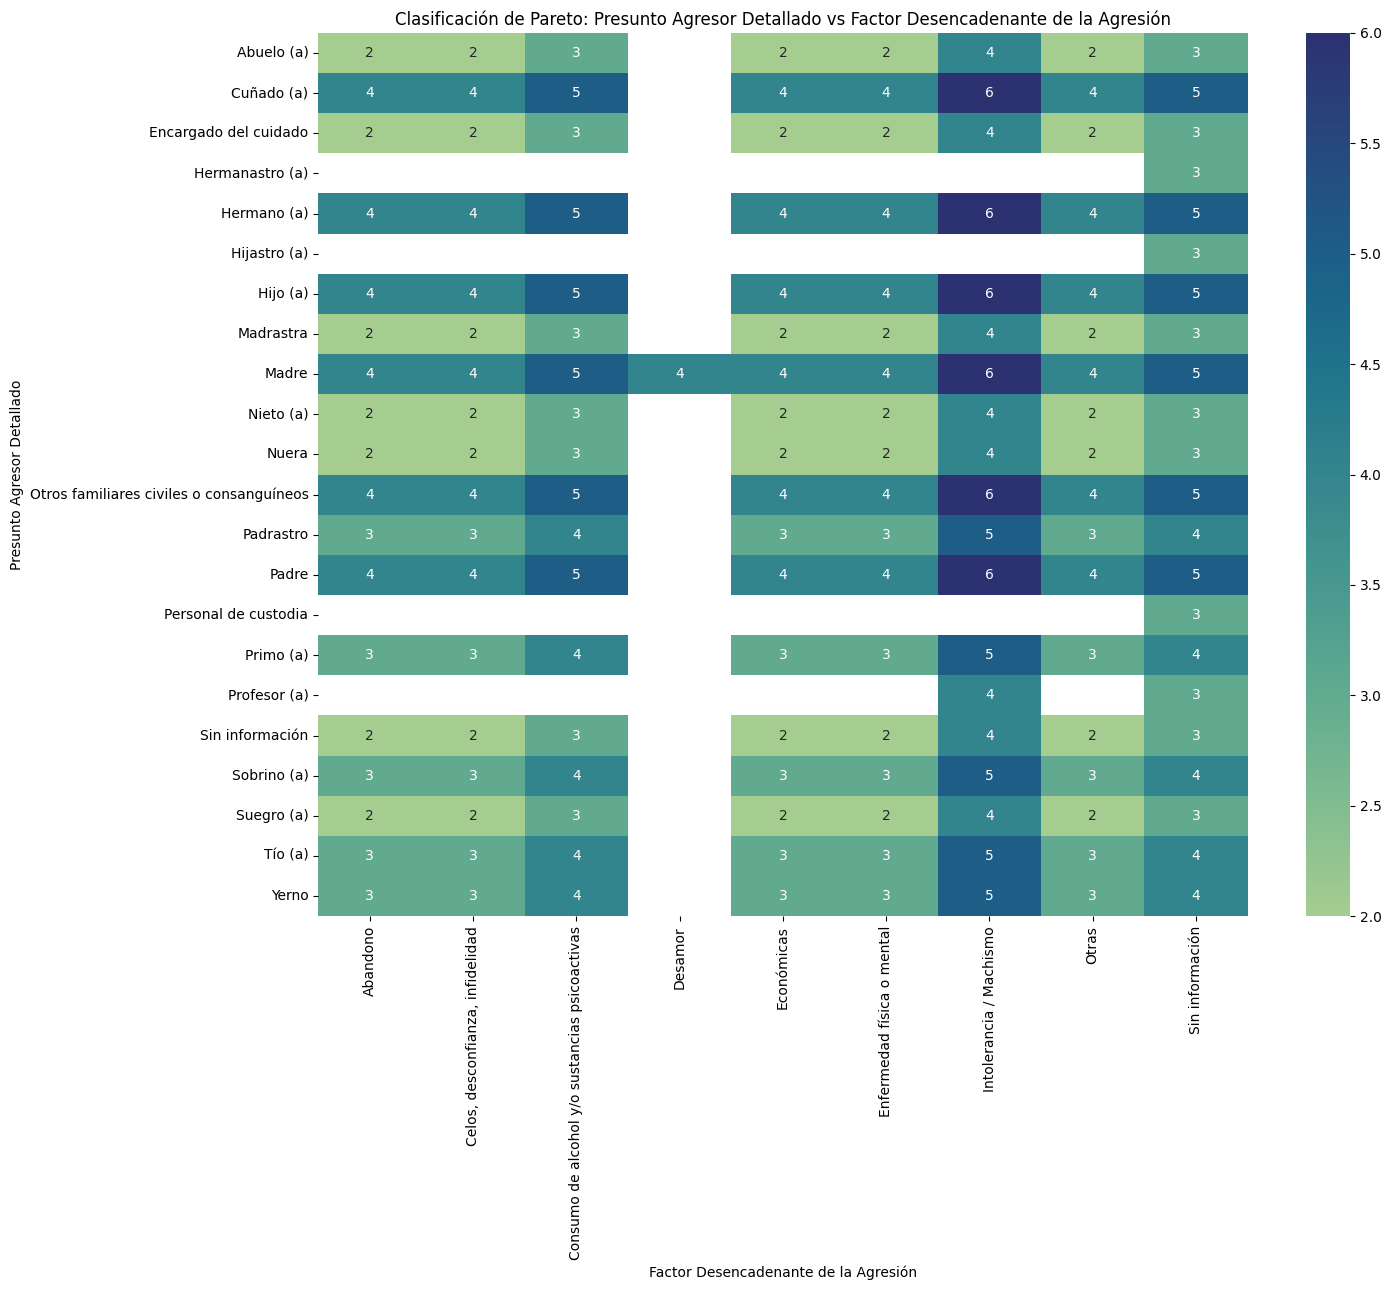

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Presunto Agresor Detallado"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(15, 13))

### Factor Desencadenante de la Agresión

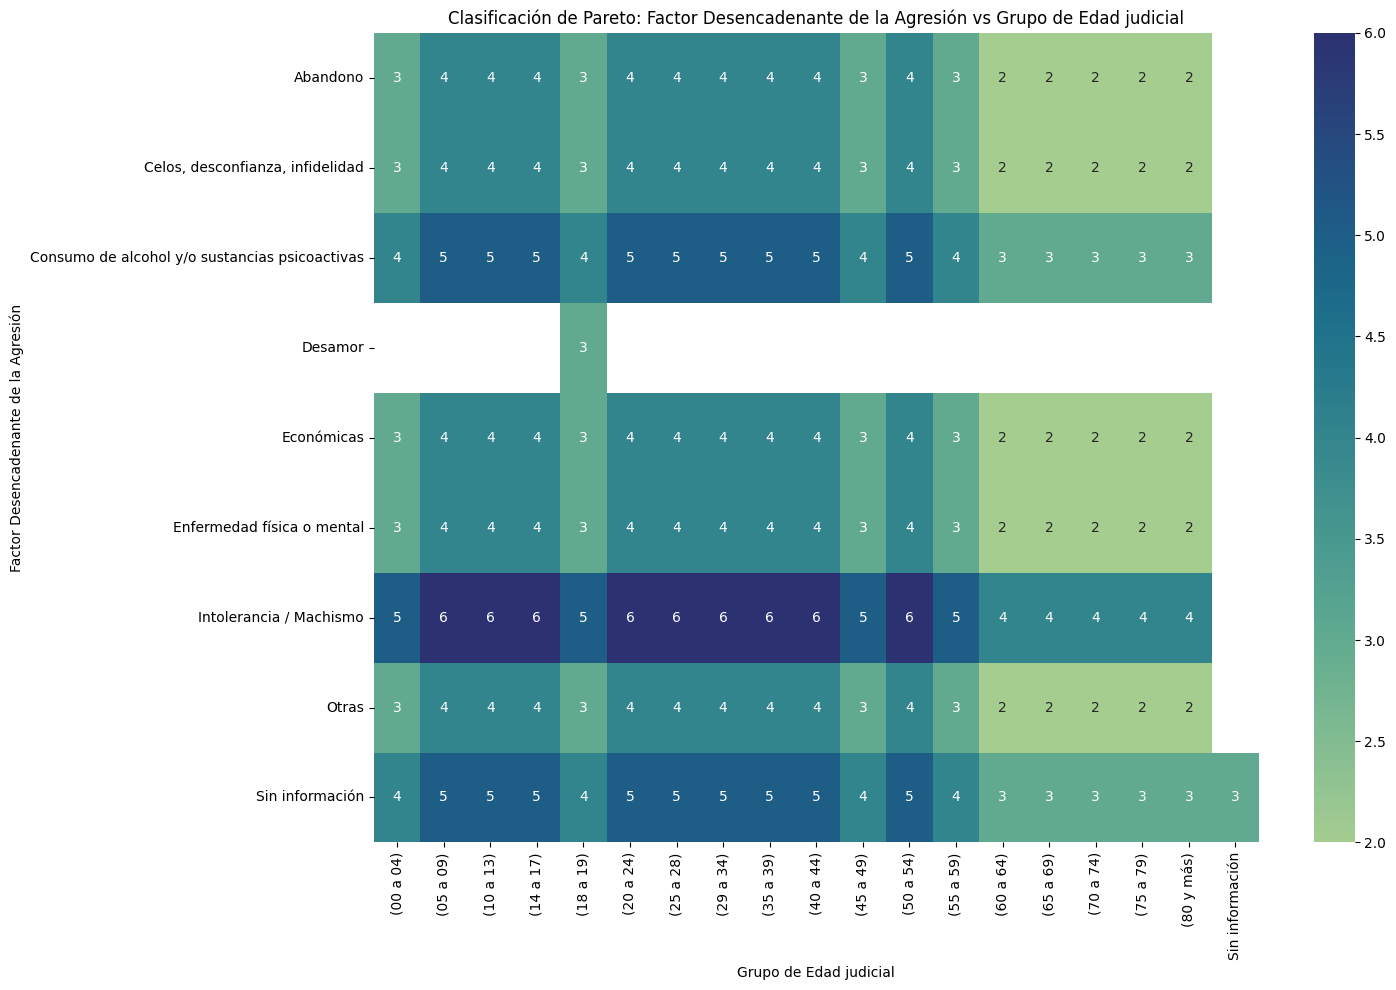

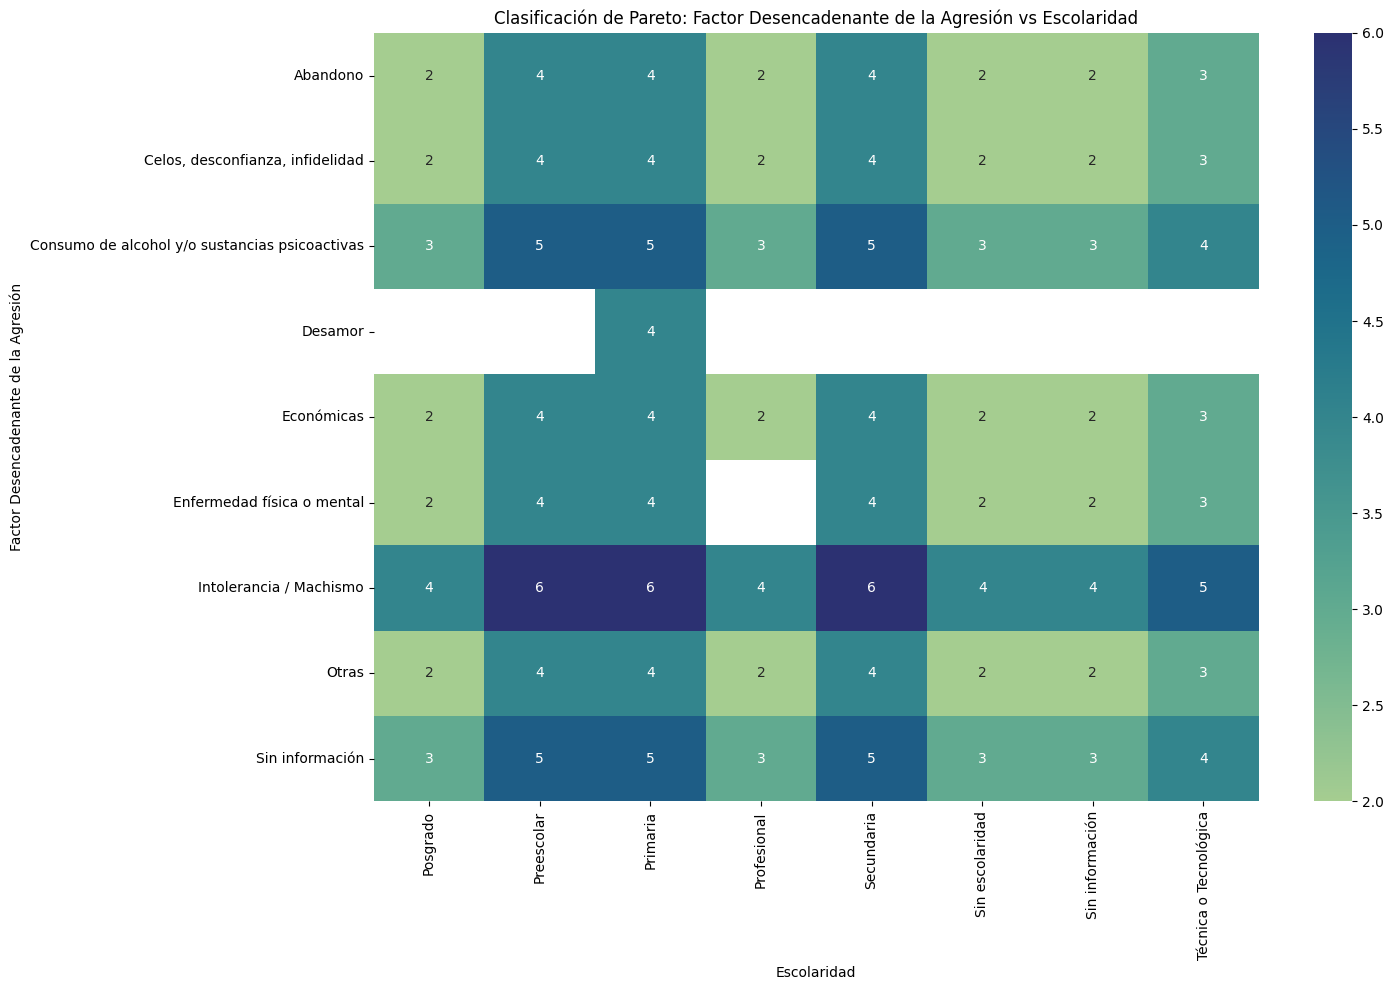

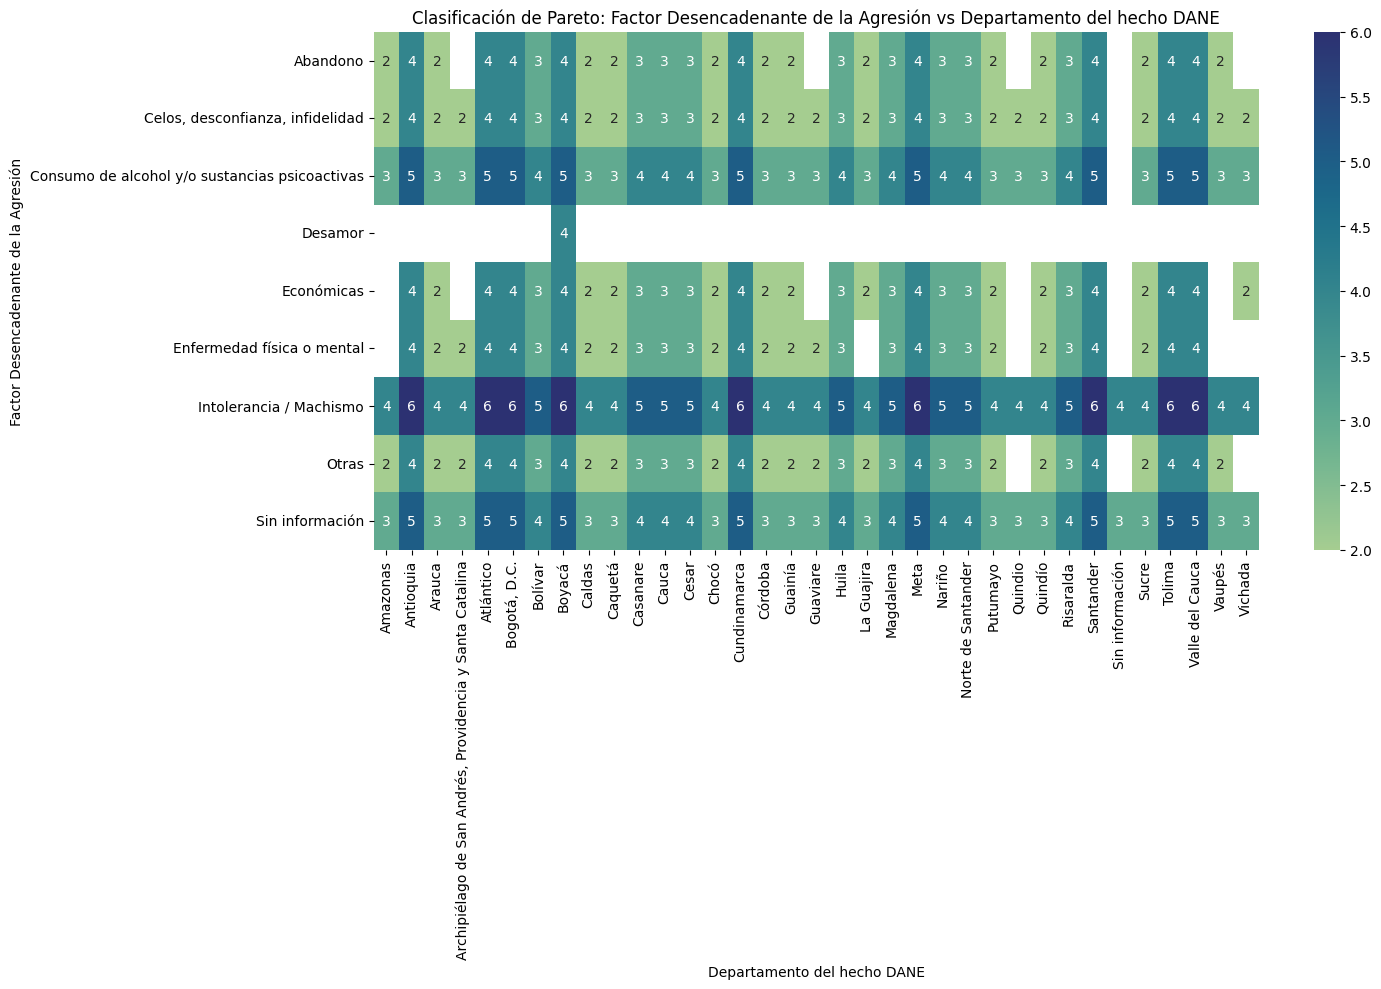

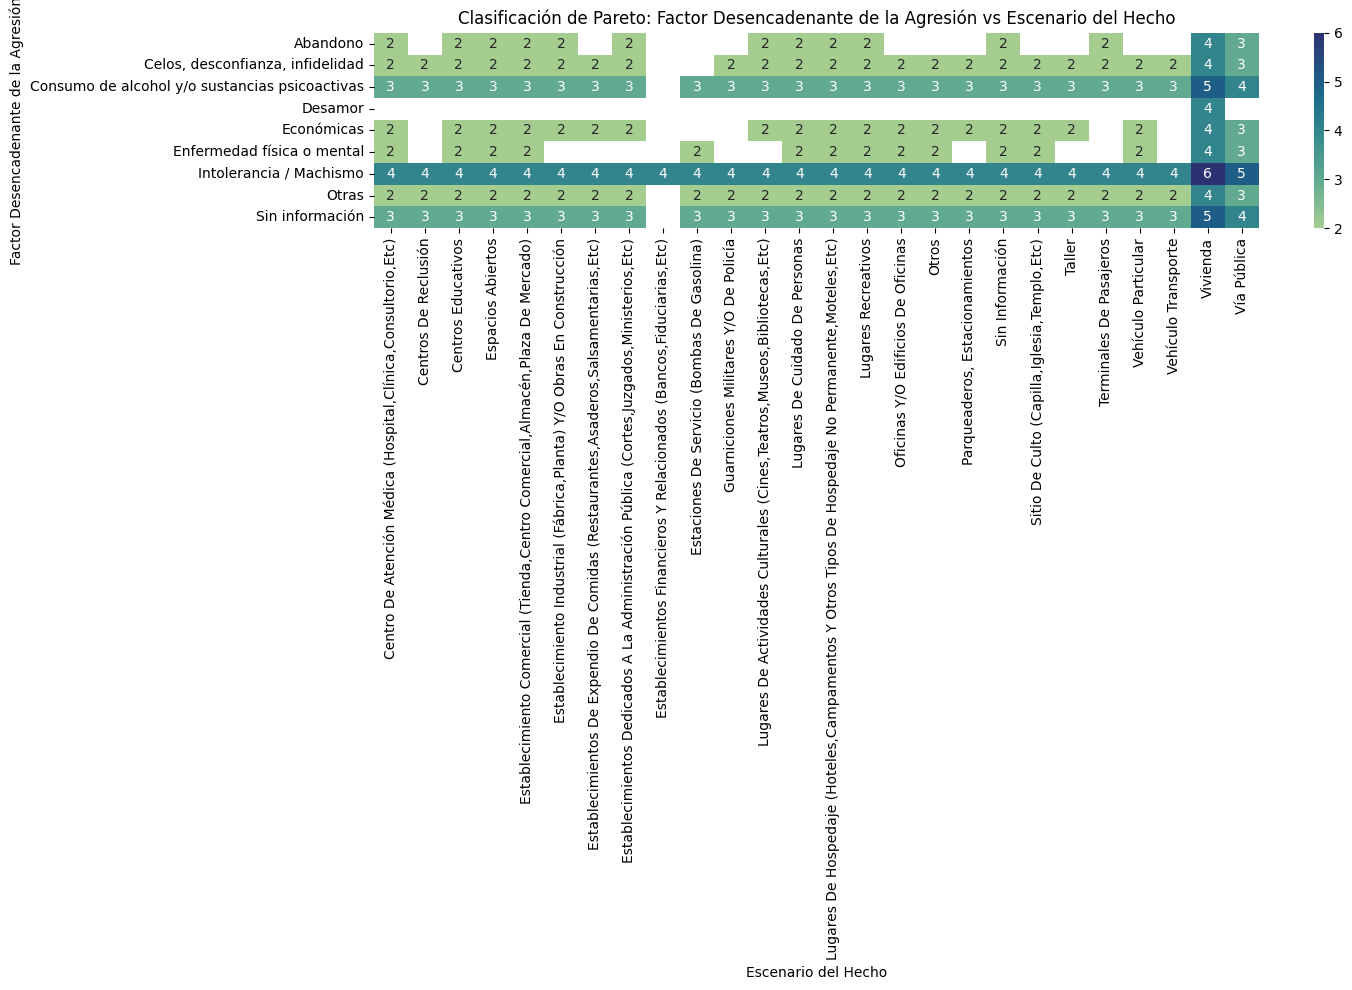

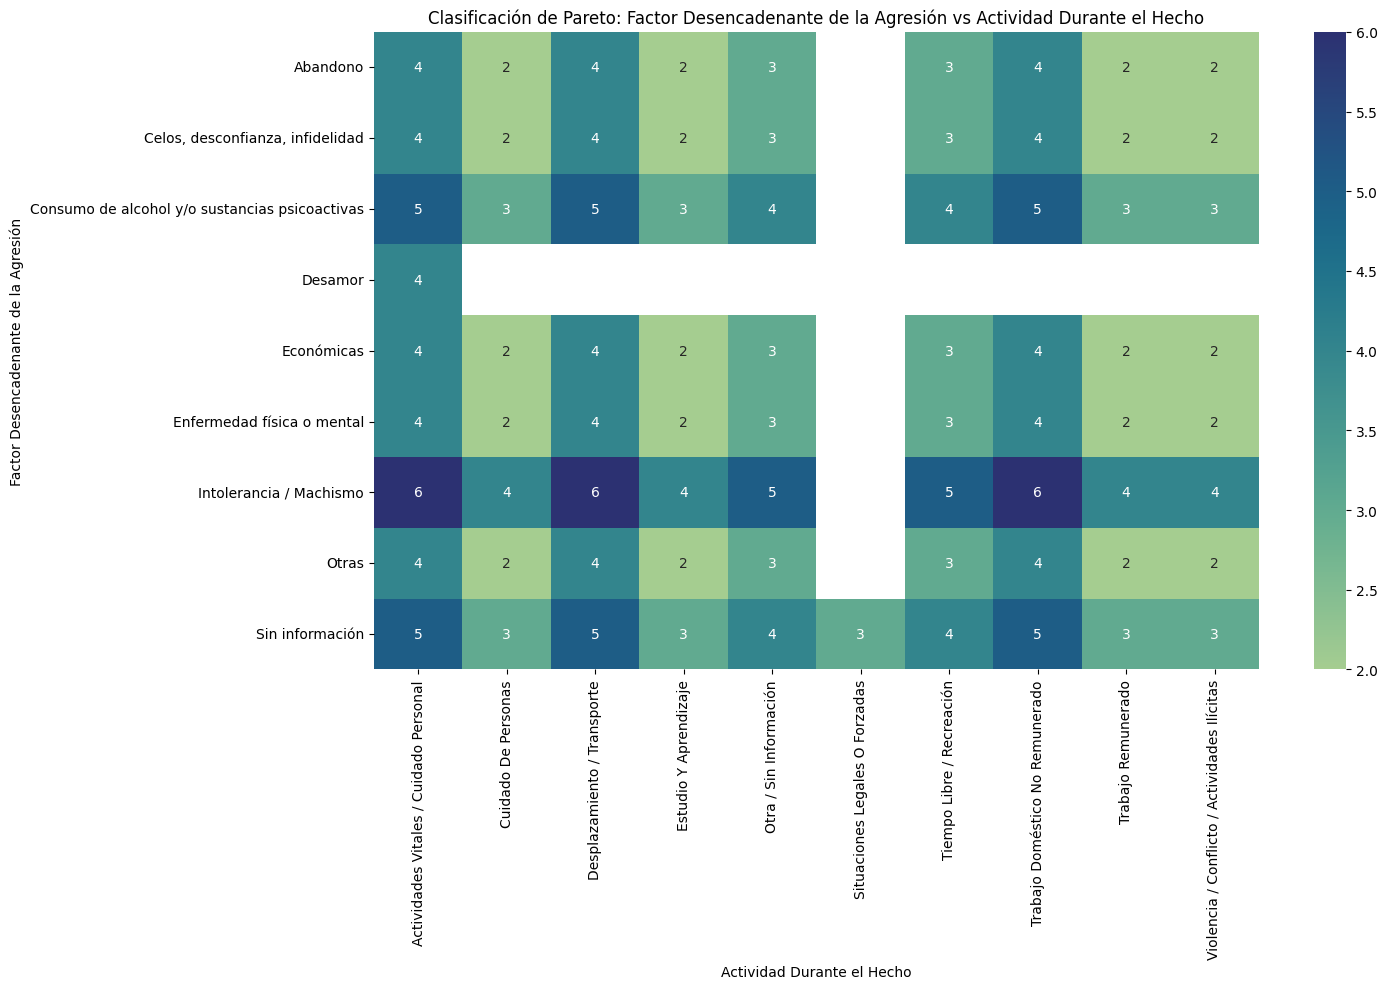

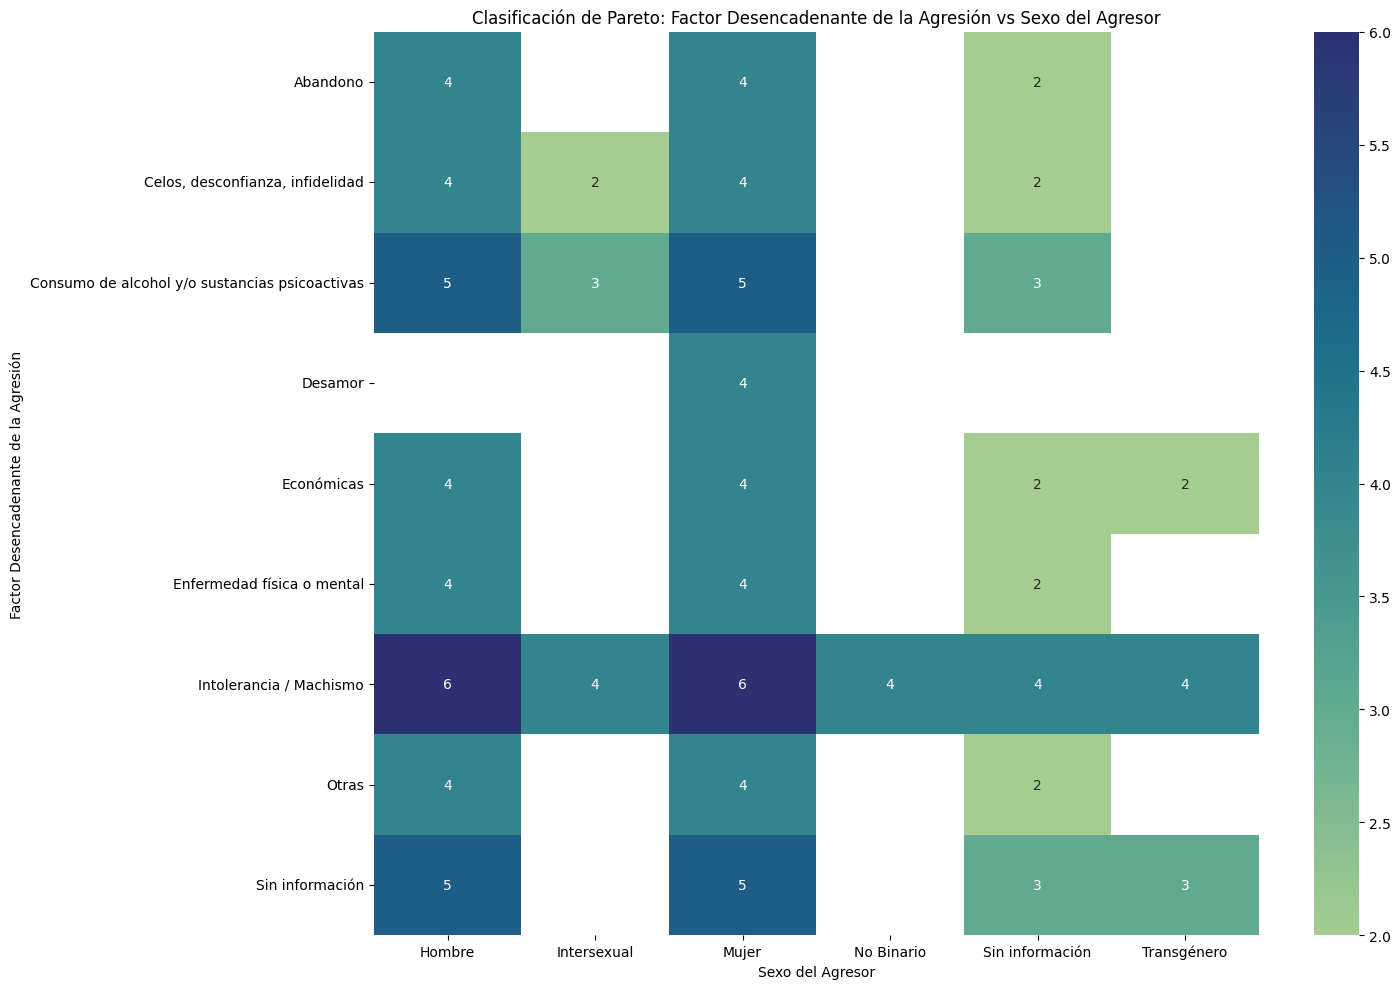

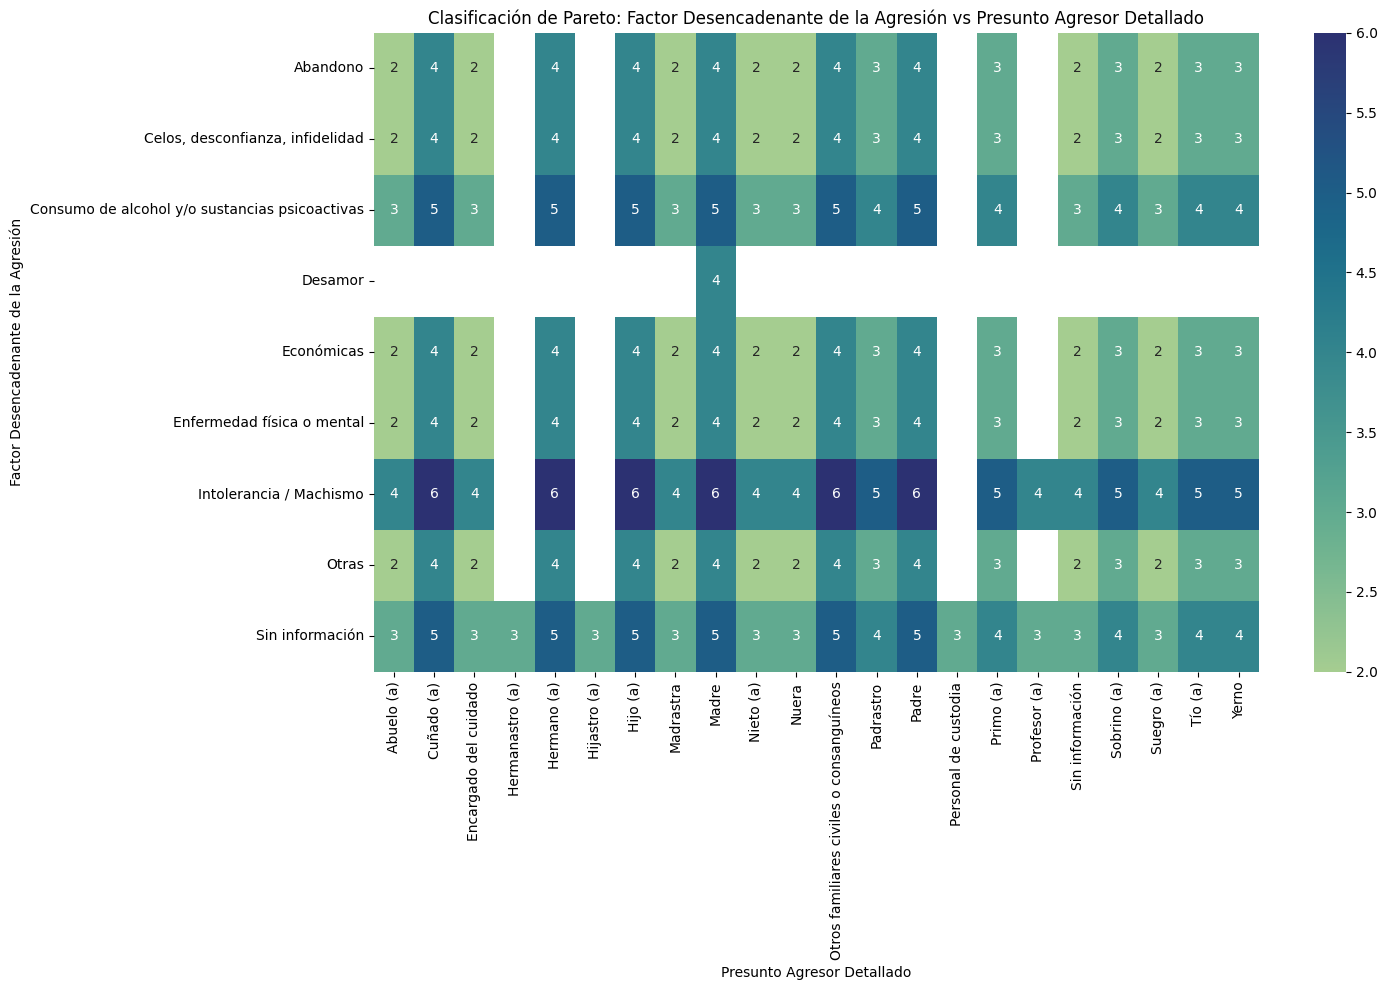

In [ ]:
# Para analizar pares con una variable fija
variable_fija = "Factor Desencadenante de la Agresión"  # Reemplazar con tu variable elegida
variables = [col.replace("_P", "") for col in intrafamiliar_pareto.columns]

# Remover la variable fija de la lista para evitar compararla consigo misma
otras_vars = [var for var in variables if var != variable_fija]

# Comparar la variable fija con cada otra variable
for var in otras_vars:
    plot_pareto_heatmap(intrafamiliar, variable_fija, var, figsize=(15, 10))

<span style="color:red">**Observaciones:**</span>

<span style="color:green">**Preguntas:**</span>

### Heatmap Pareto

<Axes: >

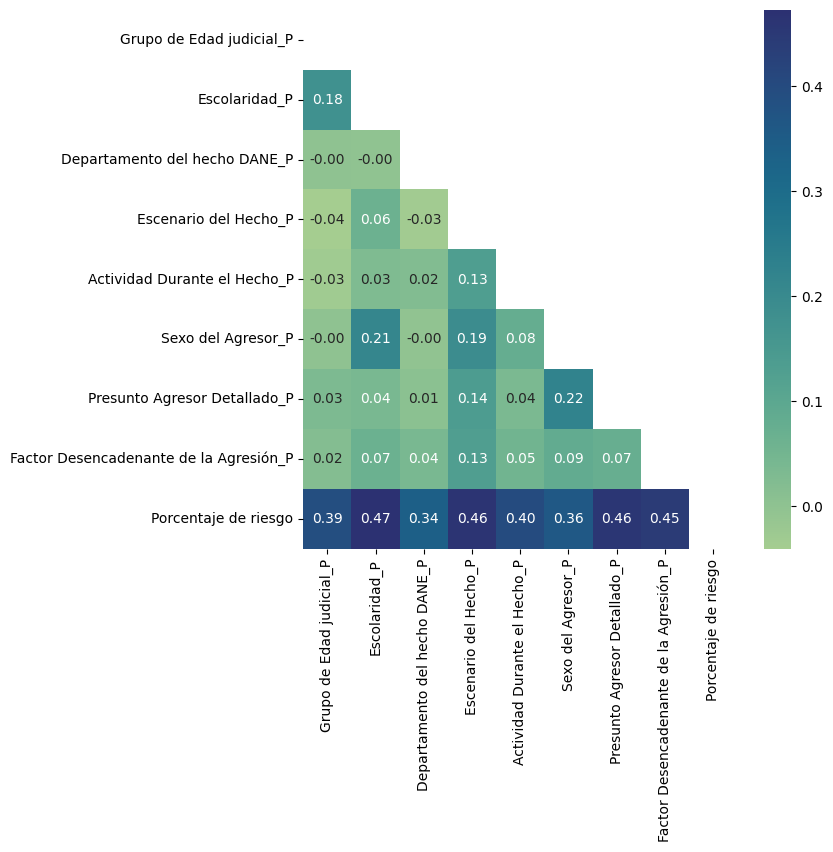

In [ ]:
plt.figure(figsize=(7,7))
mask = np.triu(np.ones_like(intrafamiliar_pareto.corr(), dtype=bool))
sns.heatmap(data=intrafamiliar_pareto.corr(), cmap='crest', annot=True, fmt='.2f', mask=mask)


In [ ]:
intrafamiliar_pareto.columns

Index(['Grupo de Edad judicial_P', 'Escolaridad_P',
       'Departamento del hecho DANE_P', 'Escenario del Hecho_P',
       'Actividad Durante el Hecho_P', 'Sexo del Agresor_P',
       'Presunto Agresor Detallado_P',
       'Factor Desencadenante de la Agresión_P', 'Porcentaje de riesgo'],
      dtype='object')

In [ ]:
intrafamiliar_final = intrafamiliar.drop(columns=['Grupo de Edad judicial_P', 'Escolaridad_P',
       'Departamento del hecho DANE_P', 'Escenario del Hecho_P',
       'Actividad Durante el Hecho_P', 'Sexo del Agresor_P',
       'Presunto Agresor Detallado_P',
       'Factor Desencadenante de la Agresión_P', 'Total Pareto'])

In [ ]:
intrafamiliar_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Año del hecho                         236840 non-null  int64  
 1   Sexo de la victima                    236840 non-null  object 
 2   Grupo de Edad judicial                236840 non-null  object 
 3   País de Nacimiento                    236840 non-null  object 
 4   Escolaridad                           236840 non-null  object 
 5   Identidad de Género                   236840 non-null  object 
 6   Pertenencia Grupal                    236840 non-null  object 
 7   Departamento del hecho DANE           236840 non-null  object 
 8   Escenario del Hecho                   236840 non-null  object 
 9   Actividad Durante el Hecho            236840 non-null  object 
 10  Sexo del Agresor                      236840 non-null  object 
 11  

## Selección final de variables

In [ ]:
intrafamiliar_pareto = intrafamiliar_pareto.drop(columns='Porcentaje de riesgo')
intrafamiliar_pareto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 8 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   Grupo de Edad judicial_P                236840 non-null  int64
 1   Escolaridad_P                           236840 non-null  int64
 2   Departamento del hecho DANE_P           236840 non-null  int64
 3   Escenario del Hecho_P                   236840 non-null  int64
 4   Actividad Durante el Hecho_P            236840 non-null  int64
 5   Sexo del Agresor_P                      236840 non-null  int64
 6   Presunto Agresor Detallado_P            236840 non-null  int64
 7   Factor Desencadenante de la Agresión_P  236840 non-null  int64
dtypes: int64(8)
memory usage: 14.5 MB


In [ ]:
intrafamiliar_pareto_s = intrafamiliar_pareto.copy()

In [ ]:
columna_comparacion = "Grupo de Edad judicial_P"

print(f"Porcentaje de 6 entre {columna_comparacion} y")

for columna in intrafamiliar_pareto_s.columns:
    if columna != columna_comparacion:
        intrafamiliar_pareto_s[columna_comparacion + "vs" + columna] = (
            intrafamiliar_pareto_s[columna_comparacion] + intrafamiliar_pareto_s[columna]
        )
        cuantos_6 = intrafamiliar_pareto_s[
            intrafamiliar_pareto_s[columna_comparacion + "vs" + columna] == 6
        ]
        porcentaje_6 = round(cuantos_6.shape[0] / intrafamiliar_pareto_s.shape[0], 2)

        print(f"{columna}:", porcentaje_6)

Porcentaje de 6 entre Grupo de Edad judicial_P y
Escolaridad_P: 0.61
Departamento del hecho DANE_P: 0.52
Escenario del Hecho_P: 0.53
Actividad Durante el Hecho_P: 0.57
Sexo del Agresor_P: 0.71
Presunto Agresor Detallado_P: 0.51
Factor Desencadenante de la Agresión_P: 0.51


In [ ]:
# Comprobar que las nuevas columas fueron añadidas
intrafamiliar_pareto_s.head()

Grupo de Edad judicial_P  Escolaridad_P  Departamento del hecho DANE_P  \
0                         3              3                              3   
1                         2              1                              3   
2                         2              1                              3   
3                         2              1                              2   
4                         3              1                              3   

   Escenario del Hecho_P  Actividad Durante el Hecho_P  Sexo del Agresor_P  \
0                      2                             3                   3   
1                      3                             2                   3   
2                      1                             3                   3   
3                      3                             3                   3   
4                      2                             3                   3   

   Presunto Agresor Detallado_P  Factor Desencadenante de la Agresión_P  \
0                             3                                       3   
1                             3                                       3   
2                             3                                       3   
3                             1                                       3   
4                             3                                       3   

   Grupo de Edad judicial_PvsEscolaridad_P  \
0                                        6   
1                                        3   
2                                        3   
3                                        3   
4                                        4   

   Grupo de Edad judicial_PvsDepartamento del hecho DANE_P  \
0                                                  6         
1                                                  5         
2                                                  5         
3                                                  4         
4                                                  6         

   Grupo de Edad judicial_PvsEscenario del Hecho_P  \
0                                                5   
1                                                5   
2                                                3   
3                                                5   
4                                                5   

   Grupo de Edad judicial_PvsActividad Durante el Hecho_P  \
0                                                  6        
1                                                  4        
2                                                  5        
3                                                  5        
4                                                  6        

   Grupo de Edad judicial_PvsSexo del Agresor_P  \
0                                             6   
1                                             5   
2                                             5   
3                                             5   
4                                             6   

   Grupo de Edad judicial_PvsPresunto Agresor Detallado_P  \
0                                                  6        
1                                                  5        
2                                                  5        
3                                                  3        
4                                                  6        

   Grupo de Edad judicial_PvsFactor Desencadenante de la Agresión_P  
0                                                  6                 
1                                                  5                 
2                                                  5                 
3                                                  5                 
4                                                  6

In [ ]:
# Comprobar que el porcentaje de 6 es correcto
intrafamiliar_pareto_s["Grupo de Edad judicial_PvsEscolaridad_P"].value_counts(
    normalize=True
)

Grupo de Edad judicial_PvsEscolaridad_P
6    0.611941
5    0.198075
4    0.119224
3    0.060328
2    0.010433
Name: proportion, dtype: float64

In [ ]:
vars_pareto = intrafamiliar_pareto_s.columns

# Crear un DataFrame vacío para los resultados
matriz_porcentajes = pd.DataFrame(index=vars_pareto, columns=vars_pareto)

for var1 in vars_pareto:
    for var2 in vars_pareto:
        if var1 != var2:
            # Calcular porcentaje donde la suma es 6
            conteo_6 = (
                intrafamiliar_pareto_s[var1] + intrafamiliar_pareto_s[var2] == 6
            ).sum()
            porcentaje = round(conteo_6 / intrafamiliar_pareto_s.shape[0], 2)
            matriz_porcentajes.loc[var1, var2] = porcentaje
        else:
            matriz_porcentajes.loc[var1, var2] = 0  # o np.nan si prefieres

matriz_porcentajes

Grupo de Edad judicial_P Escolaridad_P  \
Grupo de Edad judicial_P                                      0          0.61   
Escolaridad_P                                              0.61             0   
Departamento del hecho DANE_P                              0.52          0.59   
Escenario del Hecho_P                                      0.53          0.62   
Actividad Durante el Hecho_P                               0.57          0.65   
Sexo del Agresor_P                                         0.71          0.81   
Presunto Agresor Detallado_P                               0.51          0.58   
Factor Desencadenante de la Agresión_P                     0.51          0.58   

                                       Departamento del hecho DANE_P  \
Grupo de Edad judicial_P                                        0.52   
Escolaridad_P                                                   0.59   
Departamento del hecho DANE_P                                      0   
Escenario del Hecho_P                                           0.55   
Actividad Durante el Hecho_P                                    0.59   
Sexo del Agresor_P                                              0.72   
Presunto Agresor Detallado_P                                    0.53   
Factor Desencadenante de la Agresión_P                          0.53   

                                       Escenario del Hecho_P  \
Grupo de Edad judicial_P                                0.53   
Escolaridad_P                                           0.62   
Departamento del hecho DANE_P                           0.55   
Escenario del Hecho_P                                      0   
Actividad Durante el Hecho_P                            0.62   
Sexo del Agresor_P                                      0.75   
Presunto Agresor Detallado_P                            0.56   
Factor Desencadenante de la Agresión_P                  0.55   

                                       Actividad Durante el Hecho_P  \
Grupo de Edad judicial_P                                       0.57   
Escolaridad_P                                                  0.65   
Departamento del hecho DANE_P                                  0.59   
Escenario del Hecho_P                                          0.62   
Actividad Durante el Hecho_P                                      0   
Sexo del Agresor_P                                              0.8   
Presunto Agresor Detallado_P                                   0.58   
Factor Desencadenante de la Agresión_P                         0.58   

                                       Sexo del Agresor_P  \
Grupo de Edad judicial_P                             0.71   
Escolaridad_P                                        0.81   
Departamento del hecho DANE_P                        0.72   
Escenario del Hecho_P                                0.75   
Actividad Durante el Hecho_P                          0.8   
Sexo del Agresor_P                                      0   
Presunto Agresor Detallado_P                         0.71   
Factor Desencadenante de la Agresión_P               0.71   

                                       Presunto Agresor Detallado_P  \
Grupo de Edad judicial_P                                       0.51   
Escolaridad_P                                                  0.58   
Departamento del hecho DANE_P                                  0.53   
Escenario del Hecho_P                                          0.56   
Actividad Durante el Hecho_P                                   0.58   
Sexo del Agresor_P                                             0.71   
Presunto Agresor Detallado_P                                      0   
Factor Desencadenante de la Agresión_P                         0.51   

                                       Factor Desencadenante de la Agresión_P  
Grupo de Edad judicial_P                                                 0.51  
Escolaridad_P                                                            0.58  
Departamento 

Text(0.5, 1.0, 'Porcentaje de números 6 entre las variables')

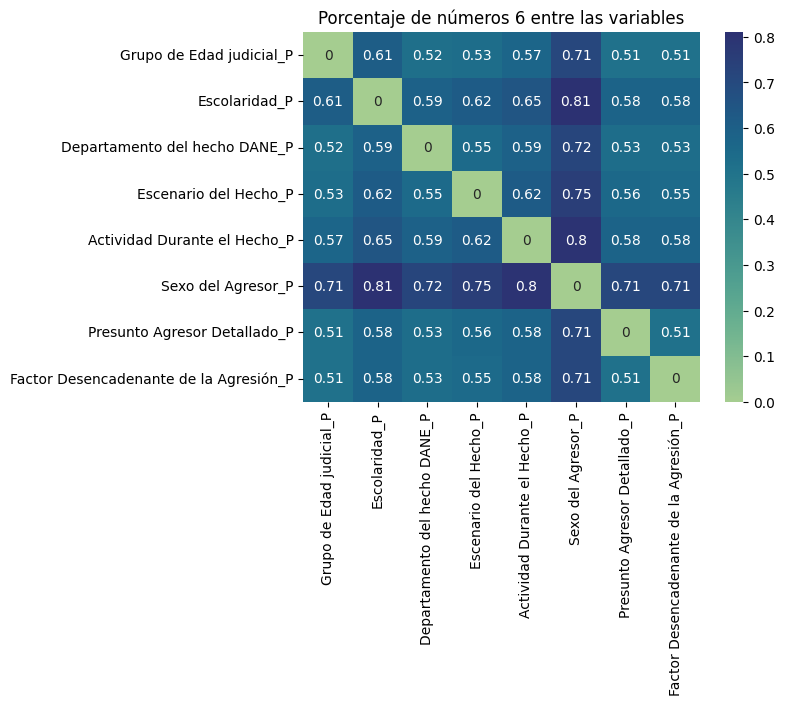

In [ ]:
sns.heatmap(data=matriz_porcentajes.astype(float), cmap="crest", annot=True)  # fmt=".2f"
plt.title("Porcentaje de números 6 entre las variables")

In [ ]:
intrafamiliar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Año del hecho                           236840 non-null  int64  
 1   Sexo de la victima                      236840 non-null  object 
 2   Grupo de Edad judicial                  236840 non-null  object 
 3   País de Nacimiento                      236840 non-null  object 
 4   Escolaridad                             236840 non-null  object 
 5   Identidad de Género                     236840 non-null  object 
 6   Pertenencia Grupal                      236840 non-null  object 
 7   Departamento del hecho DANE             236840 non-null  object 
 8   Escenario del Hecho                     236840 non-null  object 
 9   Actividad Durante el Hecho              236840 non-null  object 
 10  Sexo del Agresor                        2368

In [ ]:
intrafamiliar_modelo = intrafamiliar.copy()

In [ ]:
intrafamiliar_modelo.columns

Index(['Año del hecho', 'Sexo de la victima', 'Grupo de Edad judicial',
       'País de Nacimiento', 'Escolaridad', 'Identidad de Género',
       'Pertenencia Grupal', 'Departamento del hecho DANE',
       'Escenario del Hecho', 'Actividad Durante el Hecho', 'Sexo del Agresor',
       'Presunto Agresor Detallado', 'Factor Desencadenante de la Agresión',
       'Grupo de Edad judicial_P', 'Escolaridad_P',
       'Departamento del hecho DANE_P', 'Escenario del Hecho_P',
       'Actividad Durante el Hecho_P', 'Sexo del Agresor_P',
       'Presunto Agresor Detallado_P',
       'Factor Desencadenante de la Agresión_P', 'Total Pareto',
       'Porcentaje de riesgo'],
      dtype='object')

In [ ]:
intrafamiliar_modelo = intrafamiliar_modelo.drop(
    columns=[
        "Grupo de Edad judicial_P",
        "Escolaridad_P",
        "Departamento del hecho DANE_P",
        "Escenario del Hecho_P",
        "Actividad Durante el Hecho_P",
        "Sexo del Agresor_P",
        "Presunto Agresor Detallado_P",
        "Factor Desencadenante de la Agresión_P",
        "Total Pareto",
    ]
)

In [ ]:
intrafamiliar_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236840 entries, 0 to 236839
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Año del hecho                         236840 non-null  int64  
 1   Sexo de la victima                    236840 non-null  object 
 2   Grupo de Edad judicial                236840 non-null  object 
 3   País de Nacimiento                    236840 non-null  object 
 4   Escolaridad                           236840 non-null  object 
 5   Identidad de Género                   236840 non-null  object 
 6   Pertenencia Grupal                    236840 non-null  object 
 7   Departamento del hecho DANE           236840 non-null  object 
 8   Escenario del Hecho                   236840 non-null  object 
 9   Actividad Durante el Hecho            236840 non-null  object 
 10  Sexo del Agresor                      236840 non-null  object 
 11  

In [ ]:
intrafamiliar_modelo["Sexo del Agresor"].value_counts()

Sexo del Agresor
Hombre             161167
Mujer               73157
Sin información      2491
Intersexual            19
Transgénero             4
No Binario              2
Name: count, dtype: int64

In [ ]:
# Renombrar categorías de manera adecuada
intrafamiliar_modelo["Sexo del Agresor"] = intrafamiliar["Sexo del Agresor"].replace(
    {
        "Sin información": "Otros",
        "Intersexual": "Otros",
        "Transgénero": "Otros",
        "No Binario": "Otros",
    }
)

In [ ]:
intrafamiliar_modelo["Sexo del Agresor"].value_counts()

Sexo del Agresor
Hombre    161167
Mujer      73157
Otros       2516
Name: count, dtype: int64

In [ ]:
intrafamiliar_modelo["Factor Desencadenante de la Agresión"].value_counts()

Factor Desencadenante de la Agresión
Intolerancia / Machismo                           167780
Consumo de alcohol y/o sustancias psicoactivas     37305
Sin información                                    16881
Celos, desconfianza, infidelidad                    7718
Otras                                               3634
Económicas                                          2178
Abandono                                             725
Enfermedad física o mental                           618
Desamor                                                1
Name: count, dtype: int64

In [ ]:
# Renombrar categorías de manera adecuada
intrafamiliar_modelo["Factor Desencadenante de la Agresión"] = intrafamiliar[
    "Factor Desencadenante de la Agresión"
].replace(
    {
        "Intolerancia / Machismo": "Intolerancia o Machismo",
        "Sin información": "Otros",
        "Celos, desconfianza, infidelidad": "Otros",
        "Otras": "Otros",
        "Económicas": "Otros",
        "Abandono": "Otros",
        "Enfermedad física o mental": "Otros",
        "Desamor": "Otros",
    }
)

In [ ]:
intrafamiliar_modelo["Factor Desencadenante de la Agresión"].value_counts()

Factor Desencadenante de la Agresión
Intolerancia o Machismo                           167780
Consumo de alcohol y/o sustancias psicoactivas     37305
Otros                                              31755
Name: count, dtype: int64

In [ ]:
intrafamiliar_modelo.to_csv("intrafamiliar_modelo.csv")